<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Cryptocurrency/Bitcoin/Bitcoin_1D_High.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "mczielinski/bitcoin-historical-data"
data_resample = '1D'
data_label = 'High'
data_label_name = 'y'
start_date = '1 Jan 2009'
finish_date = '1 Jan 2019'
is_duka = False
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

Saving kaggle.json to kaggle.json
boosterBytes
DeepLearning_grid_1_AutoML_20190724_234634_model_4.zip
DeepLearning_grid_1_AutoML_20190725_002644_model_8.zip
DeepLearning_grid_1_AutoML_20190725_012331_model_3.zip
DeepLearning_grid_1_AutoML_20190725_020139_model_3.zip
DeepLearning_grid_1_AutoML_20190725_021840_model_6.zip
DeepLearning_grid_1_AutoML_20190725_023153_model_4.zip
domains
experimental
feature_map
features_dataset
full_dataset
GLM_grid_1_AutoML_20190725_003916_model_1.zip
GLM_grid_1_AutoML_20190725_021542_model_1.zip
GLM_grid_1_AutoML_20190725_021619_model_1.zip
GLM_grid_1_AutoML_20190725_023115_model_1.zip
GLM_grid_1_AutoML_20190725_030422_model_1.zip
h2o-3.24.0.5
h2o-3.24.0.5.zip
h2o-genmodel.jar
kaggle.json
model.gv
model.ini
predict_df
sample_data
scaled_df
ta-lib
ta-lib-0.4.0-src.tar.gz
XGBoost_1_AutoML_20190725_030521.zip
XGBoost_grid_1_AutoML_20190725_003927_model_7.zip
XGBoost_grid_1_AutoML_20190725_021553_model_3.zip
XGBoost_grid_1_AutoML_20190725_021723_model_6.zip
X

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:113: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)


Open     High      Low    Close        Volume  Volume_(Currency)  Weighted_Price
Date                                                                                           
2012-01-01     4.58     5.00     4.58     5.00     21.602000       1.057792e+02        5.000000
2012-01-02     5.00     5.00     5.00     5.00     19.048000       9.524000e+01        5.000000
2012-01-03     5.32     5.32     5.14     5.29     88.037281       4.648052e+02        5.290000
2012-01-04     4.93     5.57     4.93     5.57    107.233260       5.680762e+02        5.442972
2012-01-05     5.72     6.65     5.72     6.65     94.801829       5.877348e+02        6.650000
...             ...      ...      ...      ...           ...                ...             ...
2018-12-27  3810.01  3841.17  3566.00  3591.69  11850.012382       4.386927e+07     3591.677812
2018-12-28  3590.26  3970.00  3575.00  3884.97  13055.718407       4.889106e+07     3886.158322
2018-12-29  3884.66  3961.85  3702.51  3725.48   6901.382332       2.669191e+07     3718.054871
2018-12-30  3728.96  3870.00  3688.76  3835.79   5736.453708       2.172126e+07     3831.034985
2018-12-31  3831.03  3842.89  3630.00  3693.30   6667.163737       2.501076e+07     3690.607113

[2554 rows x 7 columns]

Open          High           Low         Close         Volume  Volume_(Currency)  Weighted_Price
count   2554.000000   2554.000000   2554.000000   2554.000000    2554.000000       2.554000e+03     2554.000000
mean    1864.154005   1926.928277   1789.649499   1865.696292   10482.354840       2.323909e+07     1865.535291
std     3173.637085   3296.847718   3016.170943   3173.683050   10977.935184       5.254286e+07     3173.311321
min        3.800000      4.380000      1.500000      4.230000       0.250000       1.227500e+00        4.230000
25%      134.070000    144.992500    126.230000    135.070000    3663.580355       1.141228e+06      134.824726
50%      445.350000    452.670000    434.480000    446.000000    7637.858944       3.567710e+06      446.026817
75%     1191.117500   1219.645000   1173.210000   1193.782500   13731.887552       1.779335e+07     1193.680370
max    19187.780000  19666.000000  18465.000000  19187.780000  137070.178338       7.721430e+08    19197.105613

14

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open     High      Low    Close        Volume  Volume_(Currency)  Weighted_Price  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8  MIDPOINT_8  MIDPRICE_8     SAR_0.08       SMA_8       TEMA_8    TRIMA_8        WMA_8      MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2012-02-20     4.72     4.72     4.40     4.44    315.939254       1.439907e+03        4.440000   20          0         51             29             0               1               0                 1      2        1     8        0             1           8     4.544107     5.159820    -5.999942     4.305418     4.694843     4.895104       5.010        4.97     5.618514     4.70000     4.243770     4.6125     4.516389     4.70000     4.350000     5.412045                5.608900                  4.70000                3.791100                6.063351                  4.70000                3.336649                6.517801                  4.70000                2.882199                6.972251                  4.70000                2.427749     4.694843     4.432831     5.340980                5.603744                 4.694843                3.785943                6.058194                 4.694843                3.331492                6.512644                 4.694843   
2012-02-21     4.52     4.58     4.30     4.58    358.449201       1.595157e+03        4.580000   21          1         52             29             0               1               0                 1      2        1     8        1             2           8     4.545902     5.144472    -5.888345     4.346587     4.669322     4.846871       4.560        4.97     5.500233     4.54875     4.350508     4.5000     4.489722     4.54875     4.510000     5.318714                4.933124                  4.54875                4.164376                5.125312                  4.54875                3.972188                5.317499                  4.54875                3.780001                5.509686                  4.54875                3.587814     4.669322     4.526353     5.241162                5.053697                 4.669322                4.284948                5.245884                 4.669322                4.092761                5.438071                 4.669322   
2012-02-22     4.47     4.59     4.46     4.51     75.3

Open          High           Low         Close         Volume  Volume_(Currency)  Weighted_Price          day    dayofweek    dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear          mama          fama        SAREXT        DEMA_8         EMA_8        KAMA_8    MIDPOINT_8    MIDPRICE_8      SAR_0.08         SMA_8        TEMA_8       TRIMA_8         WMA_8        MA_8_0      MAVP_8_0        T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5        MA_8_1      MAVP_8_1        T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  \
count   2504.000000   2504.000000   2504.000000   2504.000000    2504.000000       2.504000e+03     2504.000000  2504.000000  2504.000000  2504.000000    2504.000000   2504.000000     2504.000000     2504.000000       2504.000000  2504.000000  2504.000000  2504.000000  2504.000000   2504.000000  2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000   2504.000000             2504.000000              2504.000000             2504.000000             2504.000000              2504.000000             2504.000000             2504.000000              2504.000000             2504.000000             2504.000000              2504.000000             2504.000000   2504.000000   2504.000000   2504.000000             2504.000000              2504.000000             2504.000000             2504.000000              2504.000000   
mean    1901.260619   1965.281729   1825.273902   1902.832181   10690.004610       2.370312e+07     1902.668015    15.781550     3.000000   186.501997      30.465655      0.033147        0.967252        0.011182          0.989217     6.631789     2.540335    27.033546     3.000000      2.999201    27.033546   1910.213394   1911.789718    -30.133849   1902.826229   1897.568520   1918.247248   1898.157169   1880.664700   1864.987303   1897.586417   1902.884743   1897.583908   1899.336875   1897.586417   1901.280925   1887.111618             2086.650565              1897.586417             1708.522269             2181.182640              1897.586417             1613.990195             2275.714714              1897.586417             1519.458121             2370.246788              1897.586417             1424.926047   1897.568520   1901.587129   1888.652633             2086.632669              1897.568520             1708.504372             2181.164743              1897.568520   
std     3194.183801   3318.306852   3035.484045   3194.212997   10987.220677       5.296129e+07     3193.838160     8.806744     2.001597   103.972675       0.784653      0.179056        0.178011        0.105174          0.103299     3.401400     1.107113    14.850260     2.001597      2.001398    14.850260   3229.516657   3252.403584   3716.236423   3199.743401   3179.975250   3234.850493   3188.668998   3146.783961   3155.367071   3185.101202   3196.818947   3187.204445   3186.604280   3185.101202   3190.460192   3166.232749             3572.837907              3185.101202             2814.176081             3771.399359              3185.101202             2637.248108             3972.466505              3185.101202             2467.655314             4175.677400              3185.101202             2307.015933   3179.975250   3190.355207   3169.118604             3567.344357              3179.975250             2809.547615             3765.757459              3179.975250   
min        4.470000      4.580000      1.500000

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open          High       Low     Close    Volume  Volume_(Currency)  Weighted_Price  day  dayofweek  dayofyear  days_in_month  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear          mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8         WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2012-02-20  0.000013  7.120544e-06  0.000157  0.000000  0.002237       1.805199e-06        0.000000   20          0         51             29             0               1               0                 1      2        1     8        0             1           8  2.465101e-11  0.000016  0.536148  0.000000  0.000003  0.000004    0.000031    0.000020  0.000209  0.000011  0.000000  0.000009  1.948060e-06  0.000011  0.000000  0.000033                0.000040                 0.000011                0.000000                0.000050                 0.000011                0.003081                0.000059                 0.000011                0.007182            6.720592e-05                 0.000011                0.012011  0.000003  0.000000  0.000028                0.000034                 0.000003                0.000442                0.000046                 0.000003                0.004059                0.000059                 0.000003                0.008270   
2012-02-21  0.000003  0.000000e+00  0.000152  0.000007  0.002547       2.006263e-06        0.000007   21          1         52             29             0               1               0                 1      2        1     8        1             2           8  9.842700e-08  0.000015  0.536151  0.000002  0.000002  0.000001    0.000006    0.000020  0.000203  0.000003  0.000006  0.000002  4.755108e-07  0.000003  0.000008  0.000027                0.000007                 0.000003                0.000024                0.000009                 0.000003                0.003125                0.000010                 0.000003                0.007249            1.213868e-05                 0.000003                0.012106  0.000002  0.000005  0.000022                0.000007                 0.000002                0.000475                0.000008                 0.000002                0.004112                0.000013                 0.000002                0.008347   
2012-02-22  0.000000  5.086103e-07  0.000160  0.000004  0.000481       3.824707e-07        0.000004 

139129

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         3 hours 40 mins
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    1 month and 6 days
H2O cluster name:           H2O_from_python_unknownUser_x1lu07
H2O cluster total nodes:    1
H2O cluster free memory:    8.36 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         locked, healthy
H2O connection url:         http://localhost:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_032702_mod...  0.584320  8.231716              0.477530  0.640155  0.409798
1  DeepLearning_grid_1_AutoML_20190725_032702_mod...  0.570667  4.359707              0.410120  0.641686  0.411760
2  DeepLearning_grid_1_AutoML_20190725_032702_mod...  0.563890  0.718011              0.474437  0.508296  0.258365
3  DeepLearning_grid_1_AutoML_20190725_032702_mod...  0.543986  5.323868              0.491479  0.711748  0.506586
4              DeepLearning_1_AutoML_20190725_032702  0.525924  8.515959              0.494835  0.628247  0.394694
5  DeepLearning_grid_1_AutoML_20190725_032702_mod...  0.525595  0.775467              0.488123  0.528707  0.279531
6  DeepLearning_grid_1_AutoML_20190725_032702_mod...  0.514837  0.974915              0.496644  0.606125  0.367387
7  DeepLearning_grid_1_AutoML_20190725_032702_mod...  0.512337  0.681172              0.457659  0.493990  0.244026
8  DeepLearning_grid_1_AutoML_20190725_032702_mod...  0.510857  1.250429              0.483221  0.598825  0.358591
9  DeepLearning_grid_1_AutoML_20190725_032702_mod...  0.510593  9.271124              0.467463  0.770432  0.593566

variable  relative_importance  scaled_importance  percentage
0                          BOP             1.000000           1.000000    0.001509
1           CDLCLOSINGMARUBOZU             0.815627           0.815627    0.001231
2                 weekday_name             0.807942           0.807942    0.001219
3                CDLHANGINGMAN             0.787343           0.787343    0.001188
4                       ULTOSC             0.750134           0.750134    0.001132
...                        ...                  ...                ...         ...
1029  BBANDS_middleband_24_1_4             0.587637           0.587637    0.000887
1030                  TRIMA_30             0.586974           0.586974    0.000886
1031                    SUM_20             0.585648           0.585648    0.000884
1032   BBANDS_upperband_24_5_2             0.583280           0.583280    0.000880
1033   BBANDS_middleband_8_1_2             0.574336           0.574336    0.000867

[1034 rows x 4 columns]

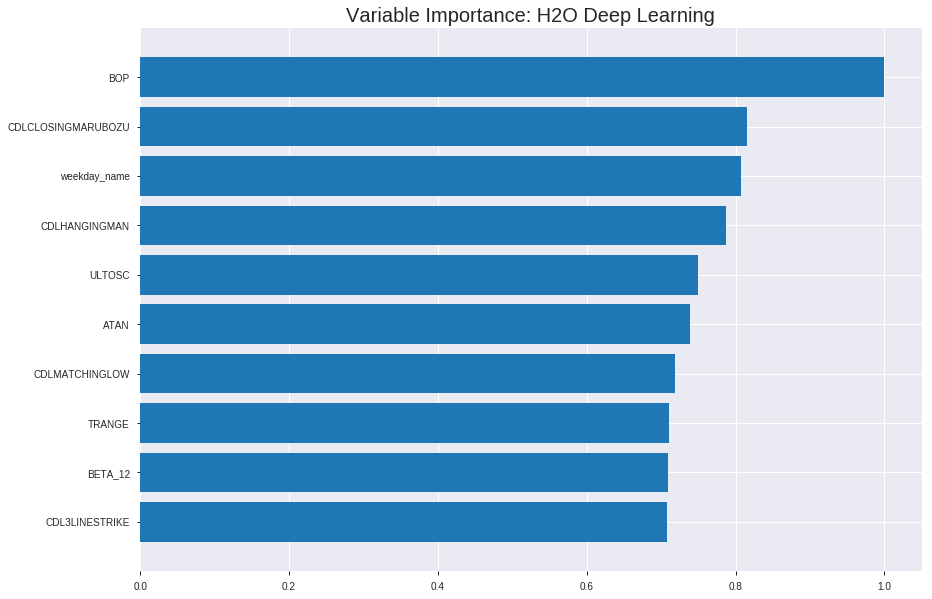

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_032702_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24054549423789157
RMSE: 0.49045437528672486
LogLoss: 1.481944833487999
Mean Per-Class Error: 0.278250865169657
AUC: 0.7849889792306928
pr_auc: 0.5106884536034002
Gini: 0.5699779584613855
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.07953842232537547: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      598  336  0.3597   (336.0/934.0)
1      167  651  0.2042   (167.0/818.0)
Total  765  987  0.2871   (503.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.0795384    0.72133   323
max f2                       0.00028458   0.824316  398
max f0point5                 0.865944     0.715141  90
max accuracy                 0.662709     0.722032  159
max precision                0.999984     0.844444  0
max recall                   2.04286e-05  1         399
max specificity              0.999984     0.955032  0
max absolute_mcc             0.273713     0.442528  257
max min_per_class_accuracy   0.325342     0.718415  243
max mean_per_class_accuracy  0.273713     0.721749  257

Gains/Lift Table: Avg response rate: 46.69 %, avg score: 45.13 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    1                  2.02282   2.02282            0.944444         1            0.944444                    1                   0.0207824       0.0207824                  102.282   102.282
    2        0.0205479                   1                  1.90383   1.96333            0.888889         1            0.916667                    1                   0.0195599       0.0403423                  90.383    96.3325
    3        0.0302511                   1                  2.14181   2.02057            1                1            0.943396                    1                   0.0207824       0.0611247                  114.181   102.057
    4        0.0405251                   1                  2.02282   2.02114            0.944444         1            0.943662                    1                   0.0207824       0.0819071                  102.282   102.114
    5        0.0502283                   1                  1.63785   1.9471             0.764706         1            0.909091                    1                   0.0158924       0.0977995                  63.7854   94.7099
    6        0.100457                    0.999995           1.72805   1.83758            0.806818         0.999999     0.857955                    0.999999            0.0867971       0.184597                   72.8051   83.7575
    7        0.150114                    0.999887           1.74791   1.80792            0.816092         0.999963     0.844106                    0.999987            0.0867971       0.271394                   74.7913   80.7915
    8        0.200342                    0.999062           1.72805   1.78789            0.806818         0.999578     0.834758                    0.999885            0.0867971       0.358191                   72.8051   78.7892
    9        0.300228                    0.966408           1.40747   1.66133            0.657143         0.990036     0.775665                    0.996608            0.140587        0.498778                   40.7475   66.1327
    10       0.400114                    0.741397           1.23613   1.55518            0.577143         0.877008     0.726106                    0.966751            0.123472        0.622249                   23.613    55.518
    11       0.5                         0.268267           1.12598   1.46944            0.525714         0.508213     0.686073                    0.875148            0.112469        0.734719                   12.598    46.9438
    12       0.599886                    0.0341894          0.832246  1.36334            0.388571         0.122358     0.636537                    0.749802            0.0831296       0.817848                   -16.7754  36.334
    13       0.699772                    0.00334739         0.67314   1.26482            0.314286         0.0137748    0.590538                    0.644741            0.0672372       0.885086                   -32.686   26.482
    14       0.799658                    0.000325917        0.489556  1.16798            0.228571         0.00130944   0.545325                    0.56437             0.0488998       0.933985                   -51.0444  16.7982
    15       0.899543                    6.21192e-06        0.440601  1.08721            0.205714         8.80538e-05  0.507614                    0.501712            0.0440098       0.977995                   -55.9399  8.72128
    16       1                           6.27039e-18        0.219049  1                  0.102273         9.73003



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.4264364898320811
RMSE: 0.6530210485367842
LogLoss: 8.570118364687652
Mean Per-Class Error: 0.42102534188865126
AUC: 0.5784480523689157
pr_auc: 0.5761459432905649
Gini: 0.15689610473783144
Confusion Matrix (Act/Pred) for max f1 @ threshold = 2.1534238013821333e-48: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    222  1        (222.0/222.0)
1      0    278  0        (0.0/278.0)
Total  0    500  0.444    (222.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       2.15342e-48  0.714653  380
max f2                       2.15342e-48  0.862283  380
max f0point5                 7.58702e-09  0.61753   270
max accuracy                 9.87402e-09  0.574     268
max precision                0.999949     0.707692  28
max recall                   2.15342e-48  1         380
max specificity              1            0.936937  0
max absolute_mcc             0.992075     0.177184  97
max min_per_class_accuracy   0.000458697  0.564748  216
max mean_per_class_accuracy  0.992075     0.578975  97

Gains/Lift Table: Avg response rate: 55.60 %, avg score: 37.38 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.022                       1                  0.654022  0.654022           0.363636         1            0.363636                    1                   0.0143885       0.0143885                  -34.5978  -34.5978
    2        0.03                        1                  1.34892   0.839329           0.75             1            0.466667                    1                   0.0107914       0.0251799                  34.8921   -16.0671
    3        0.04                        1                  1.07914   0.899281           0.6              1            0.5                         1                   0.0107914       0.0359712                  7.91367   -10.0719
    4        0.05                        1                  1.07914   0.935252           0.6              1            0.52                        1                   0.0107914       0.0467626                  7.91367   -6.47482
    5        0.1                         0.999995           1.36691   1.15108            0.76             0.999999     0.64                        1                   0.0683453       0.115108                   36.6906   15.1079
    6        0.15                        0.999803           1.29496   1.19904            0.72             0.999939     0.666667                    0.999979            0.0647482       0.179856                   29.4964   19.9041
    7        0.2                         0.998987           1.29496   1.22302            0.72             0.99942      0.68                        0.99984             0.0647482       0.244604                   29.4964   22.3022
    8        0.3                         0.972276           1.22302   1.22302            0.68             0.991728     0.68                        0.997136            0.122302        0.366906                   22.3022   22.3022
    9        0.4                         0.335862           0.863309  1.13309            0.48             0.674016     0.63                        0.916356            0.0863309       0.453237                   -13.6691  13.3094
    10       0.5                         0.000645313        1.00719   1.10791            0.56             0.0721611    0.616                       0.747517            0.100719        0.553957                   0.719424  10.7914
    11       0.6                         2.50974e-08        0.971223  1.08513            0.54             9.2396e-05   0.603333                    0.622946            0.0971223       0.651079                   -2.8777   8.51319
    12       0.7                         1.08834e-16        0.719424  1.03289            0.4              2.77626e-09  0.574286                    0.533954            0.0719424       0.723022                   -28.0576  3.2888
    13       0.8                         1.21757e-34        1.00719   1.02968            0.56             4.22866e-18  0.5725                      0.46721             0.100719        0.823741                   0.719424  2.96763
    14       0.9                         5.88958e-78        0.971223  1.02318            0.54             1.45698e-36  0.568889                    0.415297            0.0971223       0.920863                   -2.8777   2.31815
    15       1                           0                  0.791367  1                  0.44             1.40837e-85  0.556                       0.373768            0.0791367       1                          -20.8633  0


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 03:27:04  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 03:27:07  4.909 sec         214 obs/sec       0.417237  1             731        0.590735         2.96318             -0.402018      0.645436        0.526147           1.78484          0.533105                         0.746994           18.8178               -1.26035         0.531021          0.582455             0.719424           0.444
    2019-07-25 03:27:24  21.661 sec        233 obs/sec       2.49201   6             4366       0.543808         2.44009             -0.188118      0.729426        0.42063            2.02282          0.346461                         0.745488           17.1034               -1.25125         0.548594          0.625078             1.43885            0.444
    2019-07-25 03:27:41  38.071 sec        240 obs/sec       4.62386   11            8101       0.556818         2.25966             -0.245646      0.693405        0.442467           1.90383          0.368721                         0.655152           12.1556               -0.738707        0.514332          0.119581             1.00837            0.428
    2019-07-25 03:27:55  52.445 sec        236 obs/sec       6.28881   15            11018      0.512214         1.68679             -0.0540745     0.766685        0.446872           2.14181          0.336187                         0.737646           15.5405               -1.20413         0.553787          0.62112              1.79856            0.444
    2019-07-25 03:28:11  1 min  8.274 sec  239 obs/sec       8.35731   20            14642      0.490454         1.48194             0.0335815      0.784989        0.510688           2.02282          0.2871                           0.653021           8.57012               -0.727415        0.578448          0.576146             0.654022           0.444
    2019-07-25 03:28:27  1 min 24.182 sec  242 obs/sec       10.4275   25            18269      0.541937         2.53538             -0.179957      0.730794        0.412088           2.02282          0.373288                         0.745653           18.1564               -1.25225         0.551786          0.632712             1.79856            0.444
    2019-07-25 03:28:42  1 min 39.980 sec  244 obs/sec       12.5029   30            21905      0.544201         2.88213             -0.189835      0.725021        0.391026           2.02282          0.371575                         0.745653           18.5419               -1.25225         0.546228          0.625803             1.79856            0.444
    2019-07-25 03:28:58  1 min 55.557 sec  246 obs/sec       14.597    35            25574      0.513951         1.60863             -0.0612337     0.757983        0.513099           1.90383          0.314498                         0.658715           9.70006               -0.757672        0.561589          0.51506              1.14454            0.444
    2019-07-25 03:29:00  1 min 57.055 sec  246 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
BOP                       1.0                    1.0                  0.0015091615425106922
CDLCLOSINGMARUBOZU        0.8156274557113647     0.8156274557113647   0.0012309135891754345
weekday_name              0.8079420924186707     0.8079420924186707   0.0012193151344538772
CDLHANGINGMAN             0.7873432636260986     0.7873432636260986   0.0011882281742193654
ULTOSC                    0.7501336336135864     0.7501336336135864   0.0011320728315934304
---                       ---                    ---                  ---
BBANDS_middleband_24_1_4  0.5876370668411255     0.5876370668411255   0.0008868392622304116
TRIMA_30                  0.5869736671447754     0.5869736671447754   0.0008858380849213668
SUM_20                    0.5856478810310364     0.5856478810310364   0.0008838372595049172
BBANDS_upperband_24_5_2   0.5832796096801758     0.5832796096801758   0.0008802631554599685
BBANDS_middleband_8_1_2   0.5743359327316284     0.5743359327316284   0.0008667657021605814


See the whole table with table.as_data_frame()


('accuracy', 0.601593625498008)

('F1', 0.5808383233532933)

('auc', 0.5843203053033293)

('logloss', 8.231716327151778)

('mean_per_class_error', 0.38659692064745355)

('rmse', 0.6401546421098656)

('mse', 0.4097979658148101)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


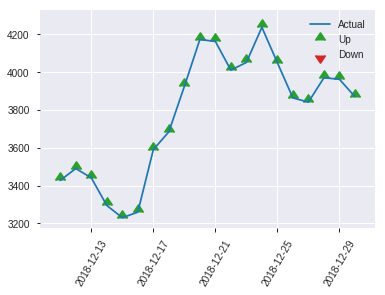


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.4097979658148101
RMSE: 0.6401546421098656
LogLoss: 8.231716327151778
Mean Per-Class Error: 0.38659692064745355
AUC: 0.5843203053033293
pr_auc: 0.4037785836670074
Gini: 0.1686406106066587
Confusion Matrix (Act/Pred) for max f1 @ threshold = 3.0064912864125473e-35: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      14   135  0.906    (135.0/149.0)
1      5    97   0.049    (5.0/102.0)
Total  19   232  0.5578   (140.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       3.00649e-35  0.580838  200
max f2                       5.16449e-47  0.7739    212
max f0point5                 1.97249e-09  0.534056  104
max accuracy                 1.97249e-09  0.601594  104
max precision                1.97249e-09  0.507353  104
max recall                   5.16449e-47  1         212
max specificity              1            0.885906  0
max absolute_mcc             1.97249e-09  0.223578  104
max min_per_class_accuracy   1.61005e-07  0.577181  90
max mean_per_class_accuracy  1.97249e-09  0.613403  104

Gains/Lift Table: Avg response rate: 40.64 %, avg score: 25.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0398406                   1                  0.738235  0.738235           0.3              1            0.3                         1                   0.0294118       0.0294118                  -26.1765  -26.1765
    2        0.0438247                   1                  2.46078   0.894831           1                1            0.363636                    1                   0.00980392      0.0392157                  146.078   -10.5169
    3        0.0517928                   1                  0         0.757164           0                1            0.307692                    1                   0               0.0392157                  -100      -24.2836
    4        0.103586                    1                  1.32504   1.0411             0.538462         1            0.423077                    1                   0.0686275       0.107843                   32.5038   4.11011
    5        0.151394                    0.999988           1.43546   1.16563            0.583333         0.999999     0.473684                    1                   0.0686275       0.176471                   43.5458   16.5635
    6        0.203187                    0.990671           1.32504   1.20627            0.538462         0.997778     0.490196                    0.999433            0.0686275       0.245098                   32.5038   20.6267
    7        0.302789                    0.0241034          0.984314  1.13326            0.4              0.508016     0.460526                    0.837783            0.0980392       0.343137                   -1.56863  13.3256
    8        0.40239                     3.71767e-05        1.27961   1.16948            0.52             0.0033419    0.475248                    0.631238            0.127451        0.470588                   27.9608   16.9482
    9        0.501992                    3.30101e-08        1.37804   1.21086            0.56             4.45877e-06  0.492063                    0.505993            0.137255        0.607843                   37.8039   21.0862
    10       0.601594                    1.59608e-10        0.787451  1.14076            0.32             4.63348e-09  0.463576                    0.42222             0.0784314       0.686275                   -21.2549  14.0761
    11       0.701195                    2.12953e-12        0.68902   1.07659            0.28             2.25194e-11  0.4375                      0.362245            0.0686275       0.754902                   -31.098   7.65931
    12       0.800797                    5.31123e-17        0.885882  1.05287            0.36             2.61167e-13  0.427861                    0.31719             0.0882353       0.843137                   -11.4118  5.28729
    13       0.900398                    6.07645e-32        0.885882  1.0344             0.36             4.38146e-18  0.420354                    0.282102            0.0882353       0.931373                   -11.4118  3.44005
    14       1                           1.55518e-66        0.68902   1                  0.28             1.70635e-33  0.406375                    0.254005            0.0686275       1                          -31.098   0

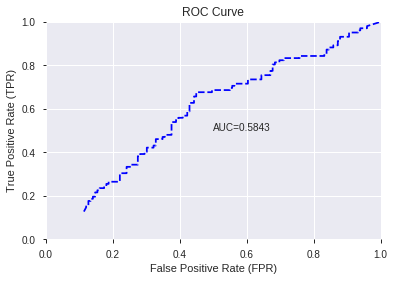

This function is available for GLM models only


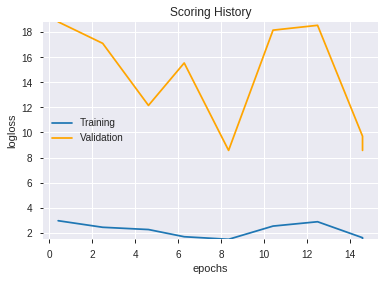

--2019-07-25 04:02:48--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.130.67
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.130.67|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_032702_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_032702_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_be36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_040256_model_9  0.613831   0.670626              0.395447  0.489582  0.239690
1  DeepLearning_grid_1_AutoML_20190725_040256_model_4  0.558758   3.398342              0.452494  0.628689  0.395250
2               DeepLearning_1_AutoML_20190725_040256  0.527964   1.473924              0.477793  0.607756  0.369368
3  DeepLearning_grid_1_AutoML_20190725_040256_model_8  0.522832   0.671259              0.405514  0.489481  0.239592
4  DeepLearning_grid_1_AutoML_20190725_040256_model_7  0.522108   2.803291              0.469799  0.622677  0.387727
5  DeepLearning_grid_1_AutoML_20190725_040256_model_5  0.514541   0.815169              0.461015  0.535074  0.286304
6  DeepLearning_grid_1_AutoML_20190725_040256_model_6  0.497302   1.322603              0.432623  0.588532  0.346370
7  DeepLearning_grid_1_AutoML_20190725_040256_model_1  0.481873   6.586309              0.474701  0.680540  0.463135
8  DeepLearning_grid_1_AutoML_20190725_040256_model_3  0.472727   8.397020              0.454040  0.675471  0.456261
9  DeepLearning_grid_1_AutoML_20190725_040256_model_2  0.445453  10.133455              0.442427  0.731037  0.534415

variable  relative_importance  scaled_importance  percentage
0                        BOP             1.000000           1.000000    0.042891
1         CDLCLOSINGMARUBOZU             0.709286           0.709286    0.030422
2               weekday_name             0.502313           0.502313    0.021545
3                    BETA_24             0.497349           0.497349    0.021332
4         CDLMORNINGDOJISTAR             0.490148           0.490148    0.021023
5              CDLHANGINGMAN             0.486305           0.486305    0.020858
6            CDLUNIQUE3RIVER             0.482817           0.482817    0.020708
7               CDLTASUKIGAP             0.482305           0.482305    0.020686
8                     BETA_8             0.476763           0.476763    0.020449
9                    BETA_12             0.472455           0.472455    0.020264
10            CDLMATCHINGLOW             0.469869           0.469869    0.020153
11         CDLSTALLEDPATTERN             0.467290           0.467290    0.020042
12            CDLEVENINGSTAR             0.466721           0.466721    0.020018
13         CDLDARKCLOUDCOVER             0.465496           0.465496    0.019965
14                    TRANGE             0.464508           0.464508    0.019923
15        CDLIDENTICAL3CROWS             0.461606           0.461606    0.019799
16         CDL3WHITESOLDIERS             0.460955           0.460955    0.019771
17                  WILLR_14             0.458837           0.458837    0.019680
18                 CDLHAMMER             0.457328           0.457328    0.019615
19                  WILLR_24             0.456344           0.456344    0.019573
20                      ATAN             0.452875           0.452875    0.019424
21             days_in_month             0.452408           0.452408    0.019404
22                 PLUS_DM_8             0.451251           0.451251    0.019354
23         CDLGRAVESTONEDOJI             0.450171           0.450171    0.019308
24                       SIN             0.449587           0.449587    0.019283
25                   CDLDOJI             0.449487           0.449487    0.019279
26                    ULTOSC             0.449115           0.449115    0.019263
27                      TANH             0.448459           0.448459    0.019235
28   BBANDS_lowerband_20_3_5             0.447333           0.447333    0.019186
29  BBANDS_middleband_14_3_4             0.441408           0.441408    0.018932
30              STOCHF_fastk             0.439398           0.439398    0.018846
31                    Volume             0.438090           0.438090    0.018790
32  BBANDS_middleband_30_0_2             0.437728           0.437728    0.018774
33                       TAN             0.437489           0.437489    0.018764
34                   BETA_30             0.436614           0.436614    0.018727
35        LINEARREG_ANGLE_20             0.436594           0.436594    0.018726
36            CDL3LINESTRIKE             0.432810           0.432810    0.018563
37           CDLSHOOTINGSTAR             0.432077           0.432077    0.018532
38                  WILLR_20             0.431768           0.431768    0.018519
39          is_quarter_start             0.430604           0.430604    0.018469
40   BBANDS_lowerband_14_6_2             0.430442           0.430442    0.018462
41              is_month_end             0.429469           0.429469    0.018420
42         Volume_(Currency)             0.428712           0.428712    0.018388
43                     VAR_8             0.428655           0.428655    0.018385
44   BBANDS_lowerband_20_5_5             0.428620           0.428620    0.018384
45   BBANDS_upperband_24_0_4             0.426336           0.426336    0.018286
46                   BETA_14             0.426006           0.426006    0.018272
47   BBANDS_lowerband_20_1_5             0.423557           0.423557    0.018167
48    BBANDS_upperband_8_3_3             0.415352  

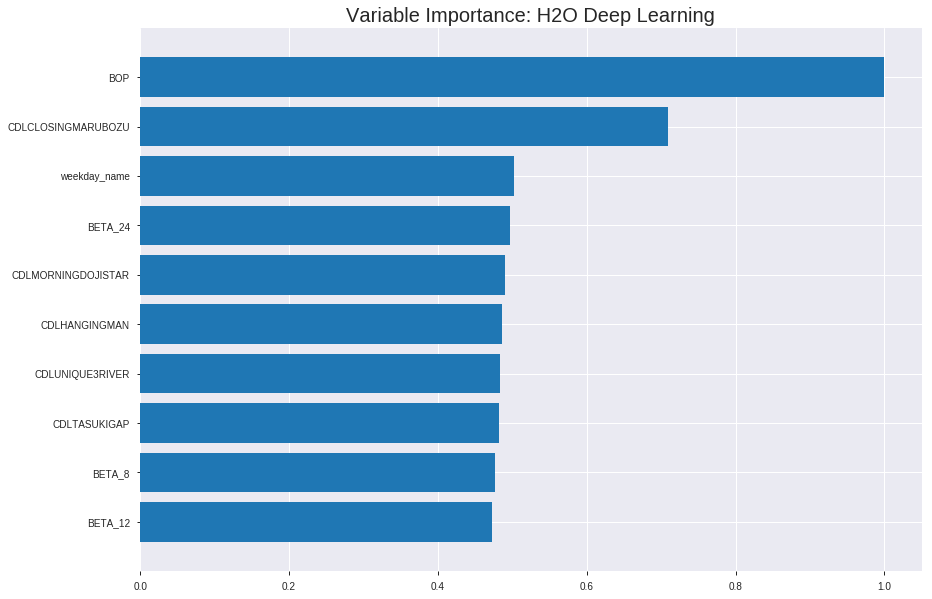

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_040256_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1987909559981361
RMSE: 0.44585979410363535
LogLoss: 0.5831734024993366
Mean Per-Class Error: 0.299656288121129
AUC: 0.769476133882714
pr_auc: 0.7414393200003653
Gini: 0.5389522677654279
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38398391383386304: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      429  505   0.5407   (505.0/934.0)
1      99   719   0.121    (99.0/818.0)
Total  528  1224  0.3447   (604.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.383984     0.704212  265
max f2                       0.315149     0.827836  306
max f0point5                 0.538058     0.681818  152
max accuracy                 0.454578     0.699201  211
max precision                0.888824     1         0
max recall                   0.123193     1         395
max specificity              0.888824     1         0
max absolute_mcc             0.454578     0.399821  211
max min_per_class_accuracy   0.462054     0.698044  206
max mean_per_class_accuracy  0.454578     0.700344  211

Gains/Lift Table: Avg response rate: 46.69 %, avg score: 47.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.866341           1.90383   1.90383            0.888889         0.876274  0.888889                    0.876274            0.0195599       0.0195599                  90.383    90.383
    2        0.0205479                   0.852141           2.02282   1.96333            0.944444         0.860133  0.916667                    0.868203            0.0207824       0.0403423                  102.282   96.3325
    3        0.0302511                   0.836937           1.76384   1.89934            0.823529         0.845725  0.886792                    0.860993            0.0171149       0.0574572                  76.3843   89.934
    4        0.0405251                   0.822001           1.90383   1.90048            0.888889         0.829909  0.887324                    0.853113            0.0195599       0.0770171                  90.383    90.0479
    5        0.0502283                   0.806417           1.88983   1.89842            0.882353         0.811868  0.886364                    0.845145            0.0183374       0.0953545                  88.9832   89.8422
    6        0.100457                    0.719125           1.89842   1.89842            0.886364         0.756187  0.886364                    0.800666            0.0953545       0.190709                   89.8422   89.8422
    7        0.150114                    0.655067           1.72329   1.84049            0.804598         0.686723  0.859316                    0.762974            0.0855746       0.276284                   72.3295   84.049
    8        0.200342                    0.606849           1.55768   1.76959            0.727273         0.629251  0.826211                    0.729448            0.0782396       0.354523                   55.7679   76.9586
    9        0.300228                    0.543114           1.28509   1.60839            0.6              0.5707    0.750951                    0.676633            0.128362        0.482885                   28.5086   60.8393
    10       0.400114                    0.494833           1.12598   1.48796            0.525714         0.5173    0.694722                    0.636856            0.112469        0.595355                   12.598    48.7962
    11       0.5                         0.45462            1.1627    1.42298            0.542857         0.474486  0.664384                    0.604419            0.116137        0.711491                   16.2696   42.2983
    12       0.599886                    0.422475           0.881202  1.33277            0.411429         0.439363  0.622265                    0.576936            0.0880196       0.799511                   -11.8798  33.2772
    13       0.699772                    0.382311           0.795529  1.25609            0.371429         0.404422  0.58646                     0.552311            0.0794621       0.878973                   -20.4471  25.6086
    14       0.799658                    0.323085           0.599707  1.1741             0.28             0.354989  0.54818                     0.527664            0.0599022       0.938875                   -40.0293  17.4097
    15       0.899543                    0.248161           0.379406  1.08585            0.177143         0.284986  0.50698                     0.500717            0.0378973       0.976773                   -62.0594  8.58538
    16       1                           0.109829           0.231218  1                  0.107955         0.203049  0.466895                    0.470814            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2506161580542593
RMSE: 0.5006157788706418
LogLoss: 0.6937203146780142
Mean Per-Class Error: 0.35664981528290884
AUC: 0.6895618640222957
pr_auc: 0.6967726566384312
Gini: 0.3791237280445914
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2944550550354186: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      65   157  0.7072   (157.0/222.0)
1      12   266  0.0432   (12.0/278.0)
Total  77   423  0.338    (169.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.294455     0.758916  329
max f2                       0.252638     0.877305  362
max f0point5                 0.330565     0.68589   294
max accuracy                 0.330565     0.67      294
max precision                0.504749     0.830508  55
max recall                   0.186705     1         384
max specificity              0.896836     0.995495  0
max absolute_mcc             0.294455     0.343618  329
max min_per_class_accuracy   0.395846     0.618705  201
max mean_per_class_accuracy  0.330565     0.64335   294

Gains/Lift Table: Avg response rate: 55.60 %, avg score: 39.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.82057            0.719424  0.719424           0.4              0.862907  0.4                         0.862907            0.00719424      0.00719424                 -28.0576  -28.0576
    2        0.02                        0.685448           1.43885   1.07914            0.8              0.785575  0.6                         0.824241            0.0143885       0.0215827                  43.8849   7.91367
    3        0.03                        0.611319           1.07914   1.07914            0.6              0.653069  0.6                         0.767184            0.0107914       0.0323741                  7.91367   7.91367
    4        0.04                        0.586075           1.79856   1.25899            1                0.598212  0.7                         0.724941            0.0179856       0.0503597                  79.8561   25.8993
    5        0.05                        0.564441           1.79856   1.36691            1                0.581471  0.76                        0.696247            0.0179856       0.0683453                  79.8561   36.6906
    6        0.1                         0.514394           1.58273   1.47482            0.88             0.537412  0.82                        0.61683             0.0791367       0.147482                   58.2734   47.482
    7        0.15                        0.489585           1.51079   1.48681            0.84             0.50005   0.826667                    0.577903            0.0755396       0.223022                   51.0791   48.6811
    8        0.2                         0.461581           1.00719   1.36691            0.56             0.472624  0.76                        0.551583            0.0503597       0.273381                   0.719424  36.6906
    9        0.3                         0.436673           1.07914   1.27098            0.6              0.447858  0.706667                    0.517008            0.107914        0.381295                   7.91367   27.0983
    10       0.4                         0.413273           1.18705   1.25               0.66             0.424632  0.695                       0.493914            0.118705        0.5                        18.705    25
    11       0.5                         0.39555            1.18705   1.23741            0.66             0.405     0.688                       0.476131            0.118705        0.618705                   18.705    23.741
    12       0.6                         0.376714           0.863309  1.17506            0.48             0.387351  0.653333                    0.461334            0.0863309       0.705036                   -13.6691  17.506
    13       0.7                         0.353801           1.11511   1.1665             0.62             0.365189  0.648571                    0.447599            0.111511        0.816547                   11.5108   16.6495
    14       0.8                         0.312189           0.971223  1.14209            0.54             0.332389  0.635                       0.433198            0.0971223       0.913669                   -2.8777   14.2086
    15       0.9                         0.259756           0.683453  1.09113            0.38             0.288597  0.606667                    0.417131            0.0683453       0.982014                   -31.6547  9.11271
    16       1                           0.126426           0.179856  1                  0.1              0.207178  0.556                       0.396136            0.01


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:11:41  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 04:11:44  3 min  1.524 sec  483 obs/sec       0.696918  1             1221       0.5788           1.2743              -0.345938      0.714968        0.699092           2.02282          0.401826                         0.743613           5.1329                -1.23994         0.602421          0.674789             1.79856            0.396
    2019-07-25 04:11:58  3 min 16.007 sec  776 obs/sec       6.89041   10            12072      0.44586          0.583173            0.201335       0.769476        0.741439           1.90383          0.344749                         0.500616           0.69372               -0.0151993       0.689562          0.696773             0.719424           0.338
    2019-07-25 04:12:14  3 min 31.546 sec  906 obs/sec       15.3333   22            26864      0.443385         0.577675            0.210177       0.775275        0.756816           2.02282          0.314498                         0.515892           0.775411              -0.0781012       0.641406          0.620889             1.07914            0.344
    2019-07-25 04:12:29  3 min 46.092 sec  998 obs/sec       24.3761   35            42707      0.436684         0.562684            0.233872       0.779185        0.759177           2.14181          0.335046                         0.554542           1.0689                -0.245692        0.61668           0.597188             1.07914            0.364
    2019-07-25 04:12:43  4 min  0.679 sec  1070 obs/sec      34.1501   49            59831      0.437592         0.564815            0.230682       0.782446        0.758064           2.14181          0.325342                         0.566727           1.1057                -0.301038        0.587676          0.575118             0.719424           0.382
    2019-07-25 04:12:58  4 min 15.915 sec  1140 obs/sec      45.3031   65            79371      0.43386          0.555874            0.243745       0.784163        0.764079           2.14181          0.325342                         0.614913           1.62219               -0.531686        0.574138          0.576524             0.719424           0.416
    2019-07-25 04:13:14  4 min 32.905 sec  1191 obs/sec      57.1781   82            100176     0.433573         0.555103            0.244748       0.797849        0.779568           2.14181          0.305936                         0.580166           1.70012               -0.363474        0.590293          0.56008              0.899281           0.362
    2019-07-25 04:13:17  4 min 34.352 sec  1190 obs/sec      57.1781   82            100176     0.44586          0.583173            0.201335       0.769476        0.741439           1.90383          0.344749                         0.500616           0.69372               -0.0151993       0.689562          0.696773             0.719424           0.338

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  --------------------
BOP                      1.0                    1.0                  0.04289066934359763
CDLCLOSINGMARUBOZU       0.7092863321304321     0.7092863321304321   0.03042176554133953
weekday_name             0.502312958240509      0.502312958240509    0.021544538998898036
BETA_24                  0.49734896421432495    0.49734896421432495  0.02133162997249738
CDLMORNINGDOJISTAR       0.4901479482650757     0.4901479482650757   0.021022773578480158
---                      ---                    ---                  ---
BBANDS_upperband_24_0_4  0.42633605003356934    0.42633605003356934  0.018285838551245315
BETA_14                  0.4260058104991913     0.4260058104991913   0.018271674356572124
BBANDS_lowerband_20_1_5  0.42355671525001526    0.42355671525001526  0.01816663102204874
BBANDS_upperband_8_3_3   0.4153515100479126     0.4153515100479126   0.017814704278828985
BBANDS_upperband_12_2_2  0.40398329496383667    0.40398329496383667  0.017327113924630988


See the whole table with table.as_data_frame()


('accuracy', 0.6215139442231076)

('F1', 0.6282051282051282)

('auc', 0.6138307672062113)

('logloss', 0.6706257415223346)

('mean_per_class_error', 0.3863995262534544)

('rmse', 0.4895818219251602)

('mse', 0.2396903603595593)

deeplearning prediction progress: |███████████████████████████████████████| 100%


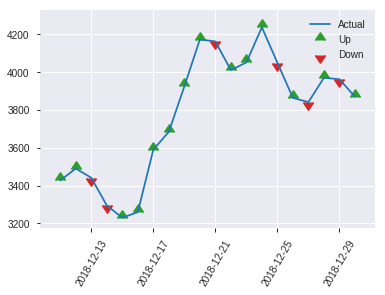


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2396903603595593
RMSE: 0.4895818219251602
LogLoss: 0.6706257415223346
Mean Per-Class Error: 0.3863995262534544
AUC: 0.6138307672062113
pr_auc: 0.5012225807960786
Gini: 0.22766153441242265
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2577020962483763: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      37   112  0.7517   (112.0/149.0)
1      4    98   0.0392   (4.0/102.0)
Total  41   210  0.4622   (116.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.257702     0.628205  209
max f2                       0.257702     0.79288   209
max f0point5                 0.274425     0.527211  194
max accuracy                 0.422233     0.621514  14
max precision                0.455236     1         0
max recall                   0.188362     1         240
max specificity              0.455236     1         0
max absolute_mcc             0.257702     0.277817  209
max min_per_class_accuracy   0.319435     0.557047  122
max mean_per_class_accuracy  0.274425     0.6136    194

Gains/Lift Table: Avg response rate: 40.64 %, avg score: 31.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.43842            2.46078   2.46078            1                0.446561  1                           0.446561            0.0294118       0.0294118                  146.078   146.078
    2        0.0239044                   0.432694           1.64052   2.05065            0.666667         0.434098  0.833333                    0.440329            0.0196078       0.0490196                  64.0523   105.065
    3        0.0318725                   0.428297           1.23039   1.84559            0.5              0.428827  0.75                        0.437454            0.00980392      0.0588235                  23.0392   84.5588
    4        0.0438247                   0.425978           1.64052   1.78966            0.666667         0.426965  0.727273                    0.434593            0.0196078       0.0784314                  64.0523   78.9661
    5        0.0517928                   0.42538            1.23039   1.70362            0.5              0.425902  0.692308                    0.433256            0.00980392      0.0882353                  23.0392   70.362
    6        0.103586                    0.415479           1.13575   1.41968            0.461538         0.419266  0.576923                    0.426261            0.0588235       0.147059                   13.5747   41.9683
    7        0.151394                    0.401227           0.615196  1.16563            0.25             0.408897  0.473684                    0.420778            0.0294118       0.176471                   -38.4804  16.5635
    8        0.203187                    0.388913           0.946456  1.10977            0.384615         0.394955  0.45098                     0.414195            0.0490196       0.22549                    -5.35445  10.9765
    9        0.302789                    0.34798            1.27961   1.16563            0.52             0.366471  0.473684                    0.398497            0.127451        0.352941                   27.9608   16.5635
    10       0.40239                     0.332963           1.27961   1.19385            0.52             0.339726  0.485149                    0.383949            0.127451        0.480392                   27.9608   19.3846
    11       0.501992                    0.31689            0.984314  1.15227            0.4              0.325703  0.468254                    0.372393            0.0980392       0.578431                   -1.56863  15.2272
    12       0.601594                    0.305264           1.18118   1.15706            0.48             0.310279  0.470199                    0.362109            0.117647        0.696078                   18.1176   15.7058
    13       0.701195                    0.288697           1.08275   1.1465             0.44             0.297903  0.465909                    0.352989            0.107843        0.803922                   8.27451   14.6502
    14       0.800797                    0.268617           1.18118   1.15081            0.48             0.27937   0.467662                    0.343832            0.117647        0.921569                   18.1176   15.0815
    15       0.900398                    0.239557           0.492157  1.07795            0.2              0.253012  0.438053                    0.333786            0.0490196       0.970588                   -50.7843  7.79542
    16       1                           0.125431           0.295294  1                  0.12             0.192126  0.406375                    0.319676          

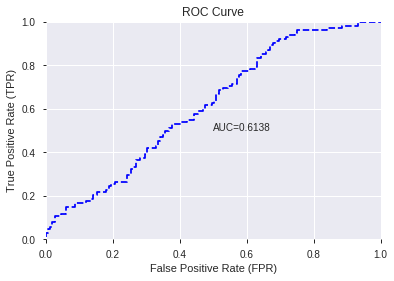

This function is available for GLM models only


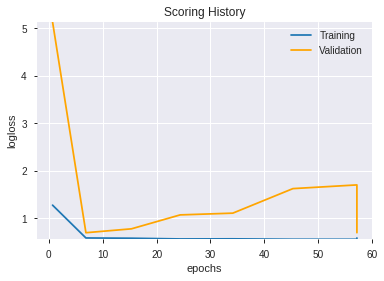

--2019-07-25 04:13:24--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.229.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.229.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_040256_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_040256_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_be36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'weekday_name',
 'BETA_24',
 'CDLMORNINGDOJISTAR',
 'CDLHANGINGMAN',
 'CDLUNIQUE3RIVER',
 'CDLTASUKIGAP',
 'BETA_8',
 'BETA_12',
 'CDLMATCHINGLOW',
 'CDLSTALLEDPATTERN',
 'CDLEVENINGSTAR',
 'CDLDARKCLOUDCOVER',
 'TRANGE',
 'CDLIDENTICAL3CROWS',
 'CDL3WHITESOLDIERS',
 'WILLR_14',
 'CDLHAMMER',
 'WILLR_24',
 'ATAN',
 'days_in_month',
 'PLUS_DM_8',
 'CDLGRAVESTONEDOJI',
 'SIN',
 'CDLDOJI',
 'ULTOSC',
 'TANH',
 'BBANDS_lowerband_20_3_5',
 'BBANDS_middleband_14_3_4',
 'STOCHF_fastk',
 'Volume',
 'BBANDS_middleband_30_0_2',
 'TAN',
 'BETA_30',
 'LINEARREG_ANGLE_20',
 'CDL3LINESTRIKE',
 'CDLSHOOTINGSTAR',
 'WILLR_20',
 'is_quarter_start',
 'BBANDS_lowerband_14_6_2',
 'is_month_end',
 'Volume_(Currency)',
 'VAR_8',
 'BBANDS_lowerband_20_5_5',
 'BBANDS_upperband_24_0_4',
 'BETA_14',
 'BBANDS_lowerband_20_1_5',
 'BBANDS_upperband_8_3_3',
 'BBANDS_upperband_12_2_2']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_041334_model_1  0.574681  0.689859              0.395907  0.497721  0.247727

variable  relative_importance  scaled_importance  percentage
0                        BOP             0.009632           1.000000    0.096217
1               STOCHF_fastk             0.007243           0.751929    0.072349
2                     ULTOSC             0.006130           0.636403    0.061233
3                   WILLR_14             0.006041           0.627146    0.060342
4         CDLCLOSINGMARUBOZU             0.006019           0.624867    0.060123
5                   WILLR_20             0.005424           0.563076    0.054178
6                   WILLR_24             0.005395           0.560108    0.053892
7   BBANDS_middleband_30_0_2             0.002932           0.304401    0.029289
8    BBANDS_lowerband_20_5_5             0.002922           0.303332    0.029186
9              CDLHANGINGMAN             0.002905           0.301576    0.029017
10   BBANDS_lowerband_20_1_5             0.002882           0.299161    0.028784
11   BBANDS_lowerband_14_6_2             0.002792           0.289806    0.027884
12   BBANDS_lowerband_20_3_5             0.002749           0.285442    0.027464
13  BBANDS_middleband_14_3_4             0.002540           0.263658    0.025369
14   BBANDS_upperband_12_2_2             0.002461           0.255513    0.024585
15   BBANDS_upperband_24_0_4             0.002383           0.247359    0.023800
16    BBANDS_upperband_8_3_3             0.002300           0.238810    0.022978
17        LINEARREG_ANGLE_20             0.002157           0.223938    0.021547
18                      ATAN             0.002073           0.215202    0.020706
19              weekday_name             0.001950           0.202442    0.019478
20         Volume_(Currency)             0.001809           0.187839    0.018073
21            CDLEVENINGSTAR             0.001728           0.179399    0.017261
22                    TRANGE             0.001714           0.177916    0.017119
23                    Volume             0.001634           0.169674    0.016326
24                   CDLDOJI             0.001534           0.159289    0.015326
25                 CDLHAMMER             0.001506           0.156350    0.015044
26         CDL3WHITESOLDIERS             0.001076           0.111689    0.010746
27            CDLMATCHINGLOW             0.001075           0.111591    0.010737
28         CDLGRAVESTONEDOJI             0.000936           0.097184    0.009351
29             days_in_month             0.000898           0.093273    0.008975
30         CDLSTALLEDPATTERN             0.000744           0.077276    0.007435
31              CDLTASUKIGAP             0.000631           0.065495    0.006302
32        CDLIDENTICAL3CROWS             0.000625           0.064906    0.006245
33                      TANH             0.000588           0.061068    0.005876
34                   BETA_30             0.000556           0.057751    0.005557
35                    BETA_8             0.000550           0.057104    0.005494
36                 PLUS_DM_8             0.000508           0.052714    0.005072
37                       TAN             0.000464           0.048168    0.004635
38           CDLSHOOTINGSTAR             0.000435           0.045176    0.004347
39                   BETA_12             0.000409           0.042493    0.004089
40        CDLMORNINGDOJISTAR             0.000396           0.041088    0.003953
41                       SIN             0.000395           0.041042    0.003949
42           CDLUNIQUE3RIVER             0.000293           0.030404    0.002925
43          is_quarter_start             0.000242           0.025089    0.002414
44                     VAR_8             0.000194           0.020190    0.001943
45                   BETA_24             0.000118           0.012248    0.001178
46                   BETA_14             0.000041           0.004250    0.000409
47         CDLDARKCLOUDCOVER             0.000036           0.003713    0.000357
48              is_month_end             0.000022  

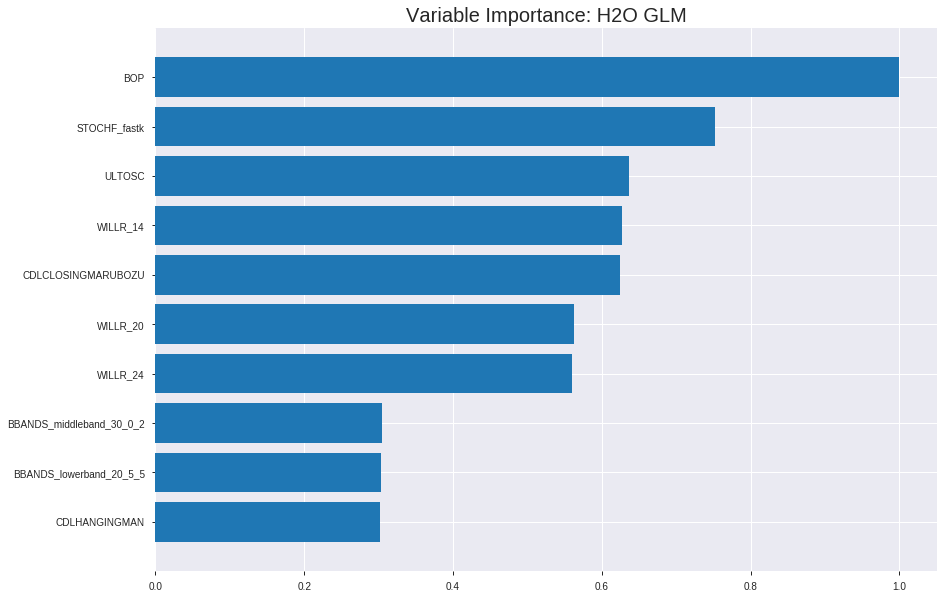

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_041334_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2446086753043282
RMSE: 0.49457929122065775
LogLoss: 0.6823234419261813
Null degrees of freedom: 1751
Residual degrees of freedom: 1701
Null deviance: 2421.1017340295916
Residual deviance: 2390.861340509339
AIC: 2492.861340509339
AUC: 0.7087362502159652
pr_auc: 0.6871140285410734
Gini: 0.4174725004319304
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4531381850283154: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      195  739   0.7912   (739.0/934.0)
1      43   775   0.0526   (43.0/818.0)
Total  238  1514  0.4463   (782.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.453138     0.664666  320
max f2                       0.448663     0.817239  349
max f0point5                 0.470115     0.643591  169
max accuracy                 0.470115     0.665525  169
max precision                0.497973     1         0
max recall                   0.432984     1         398
max specificity              0.497973     1         0
max absolute_mcc             0.46817      0.327343  186
max min_per_class_accuracy   0.467147     0.655246  196
max mean_per_class_accuracy  0.46817      0.663445  186

Gains/Lift Table: Avg response rate: 46.69 %, avg score: 46.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.492745           2.14181   2.14181            1                0.494671  1                           0.494671            0.0220049       0.0220049                  114.181   114.181
    2        0.0205479                   0.49038            1.78484   1.96333            0.833333         0.491528  0.916667                    0.493099            0.0183374       0.0403423                  78.4841   96.3325
    3        0.0302511                   0.488982           1.76384   1.89934            0.823529         0.48973   0.886792                    0.492019            0.0171149       0.0574572                  76.3843   89.934
    4        0.0405251                   0.487858           2.02282   1.93064            0.944444         0.488418  0.901408                    0.491106            0.0207824       0.0782396                  102.282   93.0645
    5        0.0502283                   0.486787           1.63785   1.87408            0.764706         0.487221  0.875                       0.490355            0.0158924       0.094132                   63.7854   87.4083
    6        0.100457                    0.483506           1.67937   1.77673            0.784091         0.484981  0.829545                    0.487668            0.0843521       0.178484                   67.9373   77.6728
    7        0.150114                    0.480467           1.50173   1.68576            0.701149         0.482025  0.787072                    0.485801            0.0745721       0.253056                   50.1728   68.5759
    8        0.200342                    0.477966           1.21694   1.56822            0.568182         0.479096  0.732194                    0.48412             0.0611247       0.314181                   21.6937   56.8219
    9        0.300228                    0.473677           1.26061   1.46588            0.588571         0.475899  0.684411                    0.481385            0.125917        0.440098                   26.0608   46.5877
    10       0.400114                    0.470383           1.27285   1.41769            0.594286         0.472025  0.661912                    0.479048            0.127139        0.567237                   27.2847   41.7688
    11       0.5                         0.466774           0.966874  1.32763            0.451429         0.468551  0.619863                    0.476951            0.096577        0.663814                   -3.31261  32.7628
    12       0.599886                    0.463204           0.807768  1.24107            0.377143         0.46502   0.579448                    0.474965            0.0806846       0.744499                   -19.2232  24.1067
    13       0.699772                    0.459511           0.844485  1.18446            0.394286         0.461465  0.553018                    0.473038            0.0843521       0.828851                   -15.5515  18.4459
    14       0.799658                    0.455908           0.636423  1.116              0.297143         0.45771   0.521056                    0.471123            0.0635697       0.892421                   -36.3577  11.6003
    15       0.899543                    0.451316           0.722096  1.07226            0.337143         0.453735  0.500635                    0.469192            0.0721271       0.964548                   -27.7904  7.22637
    16       1                           0.431128           0.352912  1                  0.164773         0.446323  0.466895                    0.466895          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2752374922478025
RMSE: 0.5246308151908373
LogLoss: 0.7473907856921185
Null degrees of freedom: 499
Residual degrees of freedom: 449
Null deviance: 702.7702737716033
Residual deviance: 747.3907856921185
AIC: 849.3907856921185
AUC: 0.595955667898114
pr_auc: 0.6627649774963459
Gini: 0.1919113357962281
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23840277923472894: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      32   190  0.8559   (190.0/222.0)
1      12   266  0.0432   (12.0/278.0)
Total  44   456  0.404    (202.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.238403     0.724796  356
max f2                       0.173548     0.865504  393
max f0point5                 0.284958     0.638743  319
max accuracy                 0.284958     0.604     319
max precision                0.474022     1         0
max recall                   0.173548     1         393
max specificity              0.474022     1         0
max absolute_mcc             0.457534     0.19477   33
max min_per_class_accuracy   0.396376     0.532374  183
max mean_per_class_accuracy  0.446972     0.576739  77

Gains/Lift Table: Avg response rate: 55.60 %, avg score: 37.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.46745            1.79856   1.79856            1                0.469257  1                           0.469257            0.0179856       0.0179856                  79.8561   79.8561
    2        0.02                        0.466215           1.43885   1.61871            0.8              0.466995  0.9                         0.468126            0.0143885       0.0323741                  43.8849   61.8705
    3        0.03                        0.464676           1.79856   1.67866            1                0.465477  0.933333                    0.467243            0.0179856       0.0503597                  79.8561   67.8657
    4        0.04                        0.464184           1.43885   1.61871            0.8              0.464538  0.9                         0.466567            0.0143885       0.0647482                  43.8849   61.8705
    5        0.05                        0.462626           1.43885   1.58273            0.8              0.46381   0.88                        0.466016            0.0143885       0.0791367                  43.8849   58.2734
    6        0.1                         0.457566           1.43885   1.51079            0.8              0.460248  0.84                        0.463132            0.0719424       0.151079                   43.8849   51.0791
    7        0.15                        0.454525           0.935252  1.31894            0.52             0.456012  0.733333                    0.460758            0.0467626       0.197842                   -6.47482  31.8945
    8        0.2                         0.450602           1.15108   1.27698            0.64             0.452336  0.71                        0.458653            0.057554        0.255396                   15.1079   27.6978
    9        0.3                         0.438622           1.00719   1.18705            0.56             0.446106  0.66                        0.454471            0.100719        0.356115                   0.719424  18.705
    10       0.4                         0.416052           0.935252  1.1241             0.52             0.426461  0.625                       0.447468            0.0935252       0.44964                    -6.47482  12.4101
    11       0.5                         0.396689           0.791367  1.05755            0.44             0.408139  0.588                       0.439602            0.0791367       0.528777                   -20.8633  5.7554
    12       0.6                         0.369589           1.11511   1.06715            0.62             0.383988  0.593333                    0.430333            0.111511        0.640288                   11.5108   6.71463
    13       0.7                         0.31817            1.07914   1.06886            0.6              0.341842  0.594286                    0.417692            0.107914        0.748201                   7.91367   6.88592
    14       0.8                         0.29328            1.07914   1.07014            0.6              0.306185  0.595                       0.403753            0.107914        0.856115                   7.91367   7.01439
    15       0.9                         0.24664            0.827338  1.04317            0.46             0.268864  0.58                        0.388766            0.0827338       0.938849                   -17.2662  4.31655
    16       1                           0.166549           0.611511  1                  0.34             0.207425  0.556                       0.370631           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 04:13:34  0.000 sec   2            20        51            1.36465           1.49478
    2019-07-25 04:13:34  0.012 sec   4            12        51            1.35567           1.57982
    2019-07-25 04:13:34  0.023 sec   6            7.6       51            1.3431            1.71589
    2019-07-25 04:13:35  0.035 sec   8            4.7       51            1.32652           1.88921
    2019-07-25 04:13:35  0.045 sec   10           2.9       51            1.30613           2.06226

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6095617529880478)

('F1', 0.5891472868217054)

('auc', 0.5746808790630346)

('logloss', 0.6898586195034314)

('mean_per_class_error', 0.3959073562310831)

('rmse', 0.49772139950890304)

('mse', 0.2477265915291011)

glm prediction progress: |████████████████████████████████████████████████| 100%


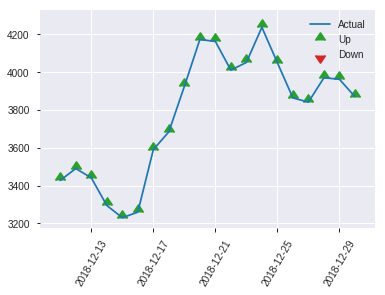


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2477265915291011
RMSE: 0.49772139950890304
LogLoss: 0.6898586195034314
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 342.8297670320054
Residual deviance: 346.30902699072266
AIC: 448.30902699072266
AUC: 0.5746808790630346
pr_auc: 0.4649355255015477
Gini: 0.1493617581260691
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31403942282069: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      69   80   0.5369   (80.0/149.0)
1      26   76   0.2549   (26.0/102.0)
Total  95   156  0.4223   (106.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.314039     0.589147  155
max f2                       0.25686      0.776256  248
max f0point5                 0.315963     0.523599  143
max accuracy                 0.387819     0.609562  11
max precision                0.400842     1         0
max recall                   0.25686      1         248
max specificity              0.400842     1         0
max absolute_mcc             0.314039     0.210824  155
max min_per_class_accuracy   0.318803     0.568627  119
max mean_per_class_accuracy  0.314039     0.604093  155

Gains/Lift Table: Avg response rate: 40.64 %, avg score: 31.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.392408           2.46078   2.46078            1                0.396195  1                           0.396195            0.0294118       0.0294118                  146.078   146.078
    2        0.0239044                   0.390457           0.820261  1.64052            0.333333         0.391552  0.666667                    0.393874            0.00980392      0.0392157                  -17.9739  64.0523
    3        0.0318725                   0.390081           1.23039   1.53799            0.5              0.390183  0.625                       0.392951            0.00980392      0.0490196                  23.0392   53.799
    4        0.0438247                   0.388375           1.64052   1.56595            0.666667         0.389278  0.636364                    0.391949            0.0196078       0.0686275                  64.0523   56.5954
    5        0.0517928                   0.387039           1.23039   1.51433            0.5              0.387632  0.615385                    0.391285            0.00980392      0.0784314                  23.0392   51.4329
    6        0.103586                    0.376898           0.567873  1.0411             0.230769         0.381373  0.423077                    0.386329            0.0294118       0.107843                   -43.2127  4.11011
    7        0.151394                    0.359419           0.615196  0.906605           0.25             0.370224  0.368421                    0.381243            0.0294118       0.137255                   -38.4804  -9.33953
    8        0.203187                    0.328085           1.51433   1.06151            0.615385         0.334642  0.431373                    0.369365            0.0784314       0.215686                   51.4329   6.15148
    9        0.302789                    0.323606           1.37804   1.16563            0.56             0.325347  0.473684                    0.354885            0.137255        0.352941                   37.8039   16.5635
    10       0.40239                     0.321183           0.984314  1.12075            0.4              0.322391  0.455446                    0.346842            0.0980392       0.45098                    -1.56863  12.0753
    11       0.501992                    0.318166           1.37804   1.1718             0.56             0.319591  0.47619                     0.341435            0.137255        0.588235                   37.8039   17.1802
    12       0.601594                    0.314736           1.27961   1.18965            0.52             0.316592  0.483444                    0.337322            0.127451        0.715686                   27.9608   18.9651
    13       0.701195                    0.30801            0.492157  1.09057            0.2              0.312086  0.443182                    0.333737            0.0490196       0.764706                   -50.7843  9.05749
    14       0.800797                    0.297192           0.68902   1.04063            0.28             0.30246   0.422886                    0.329847            0.0686275       0.833333                   -31.098   4.06302
    15       0.900398                    0.281878           0.885882  1.02351            0.36             0.290348  0.415929                    0.325478            0.0882353       0.921569                   -11.4118  2.35121
    16       1                           0.244612           0.787451  1                  0.32             0.267902  0.406375                    0.319743         

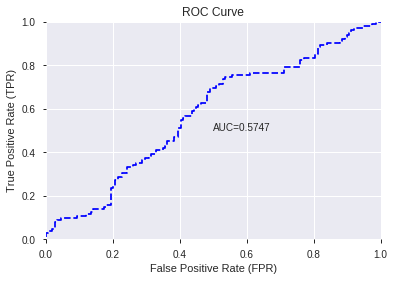

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


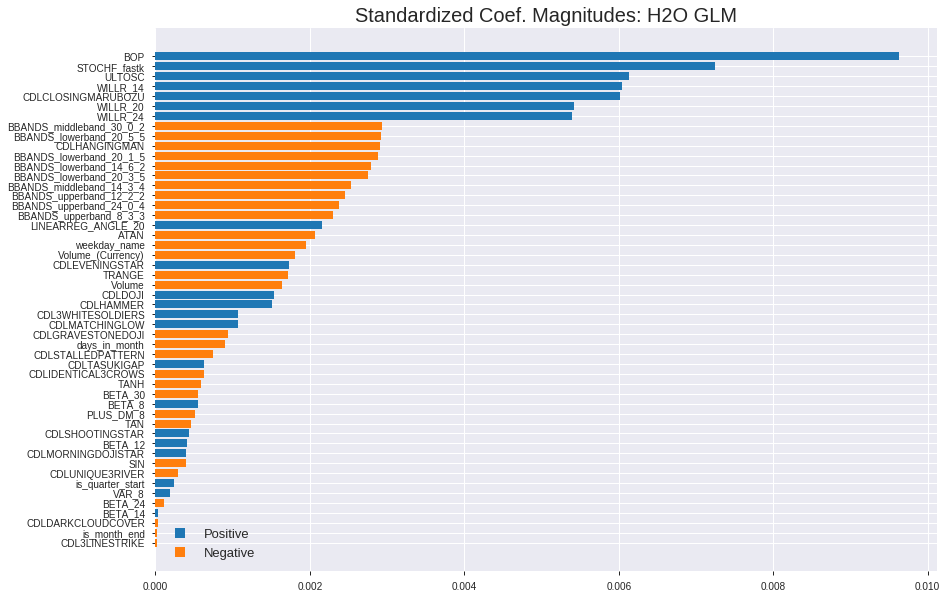

'log_likelihood'
--2019-07-25 04:13:41--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.168.27
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.168.27|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_041334_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_041334_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_be36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['BOP',
 'STOCHF_fastk',
 'ULTOSC',
 'WILLR_14',
 'CDLCLOSINGMARUBOZU',
 'WILLR_20',
 'WILLR_24',
 'BBANDS_middleband_30_0_2',
 'BBANDS_lowerband_20_5_5',
 'CDLHANGINGMAN',
 'BBANDS_lowerband_20_1_5',
 'BBANDS_lowerband_14_6_2',
 'BBANDS_lowerband_20_3_5',
 'BBANDS_middleband_14_3_4',
 'BBANDS_upperband_12_2_2',
 'BBANDS_upperband_24_0_4',
 'BBANDS_upperband_8_3_3',
 'LINEARREG_ANGLE_20',
 'ATAN',
 'weekday_name',
 'Volume_(Currency)',
 'CDLEVENINGSTAR',
 'TRANGE',
 'Volume',
 'CDLDOJI',
 'CDLHAMMER',
 'CDL3WHITESOLDIERS',
 'CDLMATCHINGLOW',
 'CDLGRAVESTONEDOJI',
 'days_in_month',
 'CDLSTALLEDPATTERN',
 'CDLTASUKIGAP',
 'CDLIDENTICAL3CROWS',
 'TANH',
 'BETA_30',
 'BETA_8',
 'PLUS_DM_8',
 'TAN',
 'CDLSHOOTINGSTAR',
 'BETA_12',
 'CDLMORNINGDOJISTAR',
 'SIN',
 'CDLUNIQUE3RIVER',
 'is_quarter_start',
 'VAR_8',
 'BETA_24',
 'BETA_14',
 'CDLDARKCLOUDCOVER',
 'is_month_end',
 'CDL3LINESTRIKE']

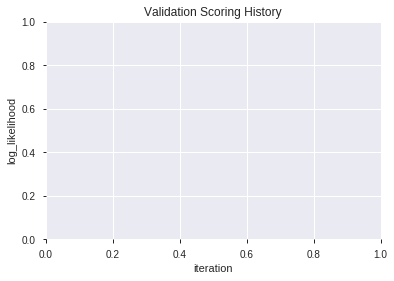

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_041345_model_2  0.747335  0.610800              0.310765  0.460466  0.212029
1  XGBoost_grid_1_AutoML_20190725_041345_model_7  0.737860  0.606822              0.299908  0.457961  0.209728
2  XGBoost_grid_1_AutoML_20190725_041345_model_5  0.736478  0.612990              0.315667  0.461366  0.212859
3  XGBoost_grid_1_AutoML_20190725_041345_model_3  0.734439  0.618460              0.285959  0.464447  0.215711
4  XGBoost_grid_1_AutoML_20190725_041345_model_1  0.734044  0.610070              0.309218  0.460021  0.211619
5               XGBoost_1_AutoML_20190725_041345  0.733254  0.604766              0.283886  0.457201  0.209033
6  XGBoost_grid_1_AutoML_20190725_041345_model_6  0.730820  0.611909              0.306882  0.460728  0.212270
7               XGBoost_3_AutoML_20190725_041345  0.730557  0.607347              0.306356  0.458970  0.210654
8               XGBoost_2_AutoML_20190725_041345  0.727793  0.610933              0.288525  0.459341  0.210994
9  XGBoost_grid_1_AutoML_20190725_041345_model_4  0.718647  0.623081              0.323661  0.466486  0.217610

variable  relative_importance  scaled_importance  percentage
0                        BOP          2423.297119           1.000000    0.299342
1               STOCHF_fastk          1039.730347           0.429056    0.128434
2                     TRANGE           628.476135           0.259348    0.077633
3               weekday_name           313.901306           0.129535    0.038775
4                     ULTOSC           308.266022           0.127209    0.038079
5                   WILLR_14           231.964722           0.095723    0.028654
6                        SIN           231.093338           0.095363    0.028546
7                     Volume           202.608994           0.083609    0.025028
8                      VAR_8           192.357727           0.079379    0.023761
9                     BETA_8           180.059357           0.074303    0.022242
10                   BETA_14           153.852280           0.063489    0.019005
11                   BETA_30           152.211731           0.062812    0.018802
12                   BETA_24           142.244888           0.058699    0.017571
13        LINEARREG_ANGLE_20           142.003662           0.058599    0.017541
14                  WILLR_20           141.481094           0.058384    0.017477
15                       TAN           137.750443           0.056844    0.017016
16                  WILLR_24           136.052094           0.056143    0.016806
17                 CDLHAMMER           133.277634           0.054998    0.016463
18   BBANDS_lowerband_20_1_5           125.821106           0.051921    0.015542
19                   BETA_12           113.920433           0.047011    0.014072
20   BBANDS_lowerband_20_3_5            99.706665           0.041145    0.012316
21        CDLCLOSINGMARUBOZU            98.417343           0.040613    0.012157
22                 PLUS_DM_8            84.811989           0.034999    0.010477
23   BBANDS_lowerband_20_5_5            84.349968           0.034808    0.010419
24         Volume_(Currency)            83.177910           0.034324    0.010275
25    BBANDS_upperband_8_3_3            78.111313           0.032233    0.009649
26                   CDLDOJI            72.962646           0.030109    0.009013
27  BBANDS_middleband_30_0_2            55.734917           0.023000    0.006885
28   BBANDS_lowerband_14_6_2            54.047890           0.022303    0.006676
29   BBANDS_upperband_12_2_2            46.655022           0.019253    0.005763
30   BBANDS_upperband_24_0_4            34.927505           0.014413    0.004314
31  BBANDS_middleband_14_3_4            33.555801           0.013847    0.004145
32                      ATAN            31.823347           0.013132    0.003931
33                      TANH            29.255013           0.012072    0.003614
34             CDLHANGINGMAN            27.086189           0.011177    0.003346
35            CDLMATCHINGLOW            22.686028           0.009362    0.002802
36             days_in_month            13.958229           0.005760    0.001724
37              is_month_end             9.721584           0.004012    0.001201
38            CDL3LINESTRIKE             2.319798           0.000957    0.000287
39        CDLIDENTICAL3CROWS             1.746788           0.000721    0.000216

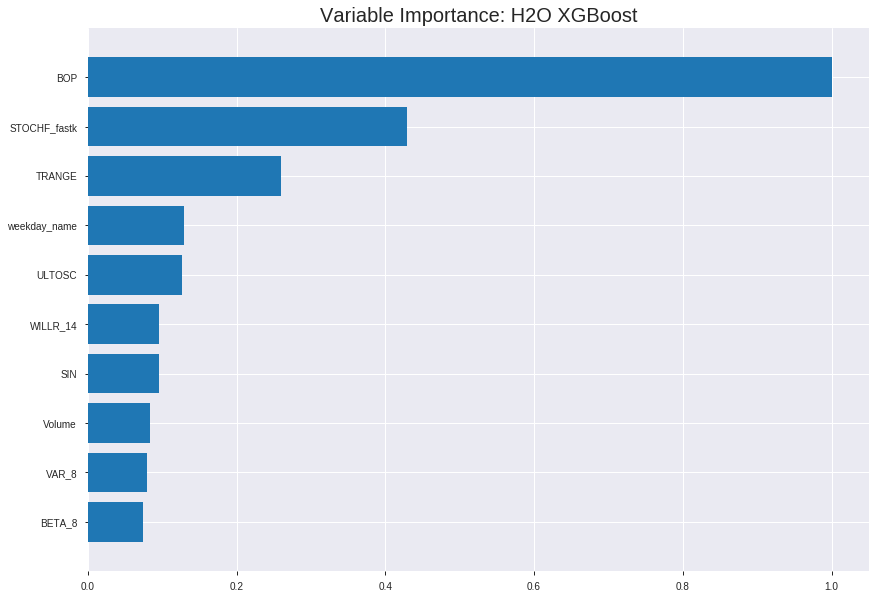

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_041345_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15545029916493067
RMSE: 0.3942718594636582
LogLoss: 0.4817605589582705
Mean Per-Class Error: 0.1946867326691204
AUC: 0.8843977581503955
pr_auc: 0.8683774257640647
Gini: 0.7687955163007909
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45347123060907635: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      706  228  0.2441   (228.0/934.0)
1      129  689  0.1577   (129.0/818.0)
Total  835  917  0.2038   (357.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.453471     0.794236  218
max f2                       0.362096     0.866547  271
max f0point5                 0.527326     0.81899   172
max accuracy                 0.503938     0.806507  187
max precision                0.909892     1         0
max recall                   0.12425      1         385
max specificity              0.909892     1         0
max absolute_mcc             0.503938     0.611657  187
max min_per_class_accuracy   0.478874     0.799511  203
max mean_per_class_accuracy  0.4855       0.805313  199

Gains/Lift Table: Avg response rate: 46.69 %, avg score: 46.36 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.899317           2.14181    2.14181            1                0.904884  1                           0.904884            0.0220049       0.0220049                  114.181   114.181
    2        0.0205479                   0.892856           2.02282    2.08231            0.944444         0.895568  0.972222                    0.900226            0.0207824       0.0427873                  102.282   108.231
    3        0.0302511                   0.883047           2.14181    2.1014             1                0.888851  0.981132                    0.896578            0.0207824       0.0635697                  114.181   110.14
    4        0.0405251                   0.870476           2.14181    2.11164            1                0.877058  0.985915                    0.891629            0.0220049       0.0855746                  114.181   111.164
    5        0.0502283                   0.855714           2.01582    2.09313            0.941176         0.863711  0.977273                    0.886236            0.0195599       0.105134                   101.582   109.313
    6        0.100457                    0.76824            2.06879    2.08096            0.965909         0.812059  0.971591                    0.849147            0.103912        0.209046                   106.879   108.096
    7        0.150114                    0.697327           1.96948    2.04408            0.91954          0.731261  0.954373                    0.81015             0.0977995       0.306846                   96.948    104.408
    8        0.200342                    0.651367           1.82541    1.98926            0.852273         0.673062  0.928775                    0.775781            0.091687        0.398533                   82.5406   98.9259
    9        0.300228                    0.575893           1.66449    1.88121            0.777143         0.611267  0.878327                    0.721047            0.166259        0.564792                   66.4492   88.1209
    10       0.400114                    0.516556           1.51762    1.79044            0.708571         0.543941  0.835949                    0.676834            0.151589        0.716381                   51.7625   79.0443
    11       0.5                         0.46419            1.02807    1.63814            0.48             0.489848  0.76484                     0.639479            0.102689        0.819071                   2.80685   63.8142
    12       0.599886                    0.412101           0.771051   1.49376            0.36             0.438183  0.697431                    0.605962            0.0770171       0.896088                   -22.8949  49.3764
    13       0.699772                    0.34868            0.538512   1.35741            0.251429         0.382037  0.633768                    0.573999            0.0537897       0.949878                   -46.1488  35.7411
    14       0.799658                    0.245991           0.293734   1.22455            0.137143         0.305078  0.571734                    0.540408            0.0293399       0.979218                   -70.6266  22.4546
    15       0.899543                    0.145564           0.183584   1.10896            0.0857143        0.188697  0.517766                    0.501354            0.0183374       0.997555                   -81.6416  10.8957
    16       1                           0.095402           0.0243387  1                  0.0113636        0.125047  0.466895                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20940858842160867
RMSE: 0.4576118316014225
LogLoss: 0.6030076018013061
Mean Per-Class Error: 0.2935381424590058
AUC: 0.7791739581307927
pr_auc: 0.8047363875465875
Gini: 0.5583479162615854
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32716184854507446: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      104  118  0.5315   (118.0/222.0)
1      25   253  0.0899   (25.0/278.0)
Total  129  371  0.286    (143.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.327162     0.779661  290
max f2                       0.179        0.877473  360
max f0point5                 0.446791     0.735294  160
max accuracy                 0.370496     0.72      245
max precision                0.874765     1         0
max recall                   0.124833     1         392
max specificity              0.874765     1         0
max absolute_mcc             0.333258     0.430729  283
max min_per_class_accuracy   0.410434     0.689189  202
max mean_per_class_accuracy  0.370496     0.706462  245

Gains/Lift Table: Avg response rate: 55.60 %, avg score: 43.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.820144           1.79856   1.79856            1                0.8528    1                           0.8528              0.0179856       0.0179856                  79.8561   79.8561
    2        0.02                        0.808988           1.43885   1.61871            0.8              0.814212  0.9                         0.833506            0.0143885       0.0323741                  43.8849   61.8705
    3        0.03                        0.805537           1.79856   1.67866            1                0.807423  0.933333                    0.824812            0.0179856       0.0503597                  79.8561   67.8657
    4        0.04                        0.802515           1.79856   1.70863            1                0.80439   0.95                        0.819706            0.0179856       0.0683453                  79.8561   70.8633
    5        0.05                        0.797158           1.79856   1.72662            1                0.801093  0.96                        0.815984            0.0179856       0.0863309                  79.8561   72.6619
    6        0.1                         0.722506           1.65468   1.69065            0.92             0.762837  0.94                        0.78941             0.0827338       0.169065                   65.4676   69.0647
    7        0.15                        0.625098           1.58273   1.65468            0.88             0.666805  0.92                        0.748542            0.0791367       0.248201                   58.2734   65.4676
    8        0.2                         0.565025           1.29496   1.56475            0.72             0.590576  0.87                        0.70905             0.0647482       0.31295                    29.4964   56.4748
    9        0.3                         0.494563           1.40288   1.51079            0.78             0.523846  0.84                        0.647316            0.140288        0.453237                   40.2878   51.0791
    10       0.4                         0.439581           1.11511   1.41187            0.62             0.466217  0.785                       0.602041            0.111511        0.564748                   11.5108   41.1871
    11       0.5                         0.41513            1.04317   1.33813            0.58             0.428694  0.744                       0.567372            0.104317        0.669065                   4.31655   33.8129
    12       0.6                         0.388936           1.00719   1.28297            0.56             0.403635  0.713333                    0.540082            0.100719        0.769784                   0.719424  28.2974
    13       0.7                         0.347257           1.00719   1.24358            0.56             0.368191  0.691429                    0.515526            0.100719        0.870504                   0.719424  24.3577
    14       0.8                         0.294121           0.647482  1.16906            0.36             0.323574  0.65                        0.491532            0.0647482       0.935252                   -35.2518  16.9065
    15       0.9                         0.184656           0.467626  1.09113            0.26             0.243169  0.606667                    0.463936            0.0467626       0.982014                   -53.2374  9.11271
    16       1                           0.114321           0.179856  1                  0.1              0.147101  0.556                       0.432253         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:13:49  0.638 sec   0                  0.5              0.693147            0.5             0                  1                0.533105                         0.5                0.693147              0.5               0                    1                  0.444
    2019-07-25 04:13:49  0.713 sec   5                  0.47794          0.649779            0.811772        0.640155           1.98991          0.287671                         0.486649           0.666677              0.774913          0.78175              1.79856            0.282
    2019-07-25 04:13:49  0.763 sec   10                 0.461306         0.617538            0.82033         0.735149           2.06921          0.296233                         0.477021           0.647581              0.777319          0.789827             1.79856            0.278
    2019-07-25 04:13:49  0.812 sec   15                 0.449081         0.59376             0.831613        0.748814           2.06532          0.273973                         0.470706           0.63475               0.780357          0.796148             1.79856            0.282
    2019-07-25 04:13:50  0.865 sec   20                 0.439065         0.573923            0.836423        0.76907            2.04445          0.264269                         0.465708           0.624421              0.776598          0.793922             1.79856            0.284
    2019-07-25 04:13:50  0.918 sec   25                 0.431541         0.558612            0.842561        0.789216           2.012            0.257991                         0.462837           0.617906              0.775188          0.799685             1.79856            0.284
    2019-07-25 04:13:50  0.995 sec   30                 0.42522          0.545775            0.847726        0.8103             2.02908          0.244863                         0.461285           0.614339              0.775366          0.796766             1.79856            0.284
    2019-07-25 04:13:50  1.055 sec   35                 0.418994         0.533107            0.85474         0.832688           2.02282          0.238014                         0.459036           0.609401              0.77778           0.799256             1.79856            0.278
    2019-07-25 04:13:50  1.129 sec   40                 0.413379         0.521424            0.860701        0.838979           2.02282          0.255137                         0.456559           0.603544              0.778736          0.800055             1.79856            0.278
    2019-07-25 04:13:50  1.193 sec   45                 0.409592         0.513177            0.86459         0.844483           2.02282          0.215183                         0.457072           0.603932              0.779125          0.800331             1.79856            0.278
    2019-07-25 04:13:50  1.255 sec   50                 0.405086         0.503876            0.869914        0.851326           2.14181          0.223174                         0.457611           0.604474              0.779733          0.804309             1.79856            0.278
    2019-07-25 04:13:50  1.315 sec   55                 0.401655         0.496661            0.874207        0.854595           2.02282          0.218037                         0.457328           0.603271              0.781288          0.806427             1.79856      

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ----------------------
BOP                 2423.297119140625      1.0                    0.2993415055682754
STOCHF_fastk        1039.7303466796875     0.42905607342462715    0.1284342909921404
TRANGE              628.4761352539062      0.25934753534340976    0.07763348169511779
weekday_name        313.90130615234375     0.1295347993743593     0.03877514186820521
ULTOSC              308.2660217285156      0.12720933776285598    0.03807903468827658
---                 ---                    ---                    ---
CDLMATCHINGLOW      22.68602752685547      0.009361636816083298   0.00280232645910977
days_in_month       13.958229064941406     0.005760015540269952   0.0017242117239210707
is_month_end        9.72158432006836       0.004011717854687142   0.0012008736625371808
CDL3LINESTRIKE      2.3197975158691406     0.0009572897592895301  0.00028655655781081987
CDLIDENTICAL3CROWS  1.7467880249023438     0.0007208311399808077  0.00021577467870235122


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7091633466135459)

('F1', 0.6764705882352942)

('auc', 0.7473351756810107)

('logloss', 0.6108000980977077)

('mean_per_class_error', 0.30145413870246085)

('rmse', 0.46046625756854687)

('mse', 0.21202917435918336)

xgboost prediction progress: |████████████████████████████████████████████| 100%


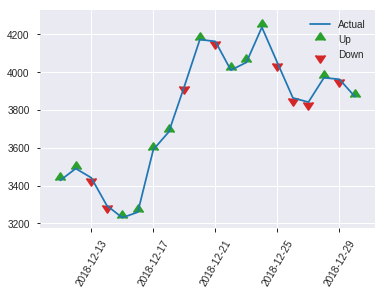


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21202917435918336
RMSE: 0.46046625756854687
LogLoss: 0.6108000980977077
Mean Per-Class Error: 0.30145413870246085
AUC: 0.7473351756810107
pr_auc: 0.6208623398368904
Gini: 0.4946703513620214
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3092087209224701: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      71   78   0.5235   (78.0/149.0)
1      10   92   0.098    (10.0/102.0)
Total  81   170  0.3506   (88.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.309209     0.676471  169
max f2                       0.292852     0.798969  173
max f0point5                 0.394988     0.642857  96
max accuracy                 0.394988     0.709163  96
max precision                0.777453     1         0
max recall                   0.115564     1         248
max specificity              0.777453     1         0
max absolute_mcc             0.34289      0.39772   149
max min_per_class_accuracy   0.378953     0.684564  116
max mean_per_class_accuracy  0.34289      0.698546  149

Gains/Lift Table: Avg response rate: 40.64 %, avg score: 35.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.739168           1.64052   1.64052            0.666667         0.758304  0.666667                    0.758304            0.0196078       0.0196078                  64.0523   64.0523
    2        0.0239044                   0.71383            1.64052   1.64052            0.666667         0.725528  0.666667                    0.741916            0.0196078       0.0392157                  64.0523   64.0523
    3        0.0318725                   0.681401           1.23039   1.53799            0.5              0.709097  0.625                       0.733711            0.00980392      0.0490196                  23.0392   53.799
    4        0.0438247                   0.576061           1.64052   1.56595            0.666667         0.609994  0.636364                    0.69997             0.0196078       0.0686275                  64.0523   56.5954
    5        0.0517928                   0.555889           1.23039   1.51433            0.5              0.563194  0.615385                    0.678928            0.00980392      0.0784314                  23.0392   51.4329
    6        0.103586                    0.491556           1.89291   1.70362            0.769231         0.521176  0.692308                    0.600052            0.0980392       0.176471                   89.2911   70.362
    7        0.151394                    0.456405           1.64052   1.68369            0.666667         0.473978  0.684211                    0.560239            0.0784314       0.254902                   64.0523   68.3695
    8        0.203187                    0.436728           1.70362   1.68877            0.692308         0.445833  0.686275                    0.531077            0.0882353       0.343137                   70.362    68.8774
    9        0.302789                    0.410039           1.5749    1.65132            0.64             0.425211  0.671053                    0.496253            0.156863        0.5                        57.4902   65.1316
    10       0.40239                     0.392993           1.27961   1.55931            0.52             0.399893  0.633663                    0.472401            0.127451        0.627451                   27.9608   55.9309
    11       0.501992                    0.372911           1.08275   1.46475            0.44             0.38131   0.595238                    0.454327            0.107843        0.735294                   8.27451   46.4753
    12       0.601594                    0.342853           0.984314  1.38521            0.4              0.357208  0.562914                    0.438248            0.0980392       0.833333                   -1.56863  38.521
    13       0.701195                    0.291865           0.787451  1.3003             0.32             0.319782  0.528409                    0.421421            0.0784314       0.911765                   -21.2549  30.0301
    14       0.800797                    0.237239           0.196863  1.16306            0.08             0.258536  0.472637                    0.401161            0.0196078       0.931373                   -80.3137  16.3057
    15       0.900398                    0.173844           0.295294  1.06707            0.12             0.197895  0.433628                    0.378676            0.0294118       0.960784                   -70.4706  6.70658
    16       1                           0.115056           0.393725  1                  0.16             0.131654  0.406375                    0.354072            

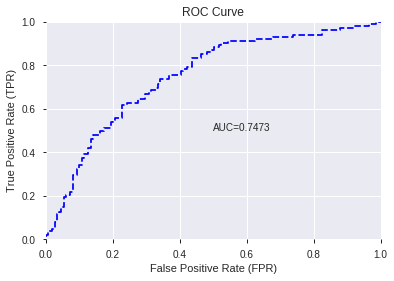

This function is available for GLM models only


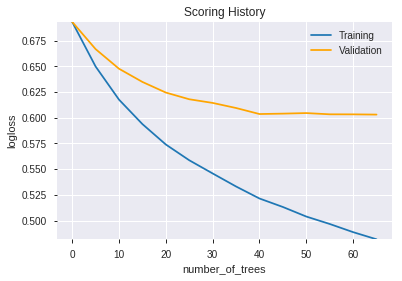

--2019-07-25 04:14:02--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.196
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.196|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_041345_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_041345_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_be36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'weekday_name',
 'ULTOSC',
 'WILLR_14',
 'SIN',
 'Volume',
 'VAR_8',
 'BETA_8',
 'BETA_14',
 'BETA_30',
 'BETA_24',
 'LINEARREG_ANGLE_20',
 'WILLR_20',
 'TAN',
 'WILLR_24',
 'CDLHAMMER',
 'BBANDS_lowerband_20_1_5',
 'BETA_12',
 'BBANDS_lowerband_20_3_5',
 'CDLCLOSINGMARUBOZU',
 'PLUS_DM_8',
 'BBANDS_lowerband_20_5_5',
 'Volume_(Currency)',
 'BBANDS_upperband_8_3_3',
 'CDLDOJI',
 'BBANDS_middleband_30_0_2',
 'BBANDS_lowerband_14_6_2',
 'BBANDS_upperband_12_2_2',
 'BBANDS_upperband_24_0_4',
 'BBANDS_middleband_14_3_4',
 'ATAN',
 'TANH',
 'CDLHANGINGMAN',
 'CDLMATCHINGLOW',
 'days_in_month',
 'is_month_end',
 'CDL3LINESTRIKE',
 'CDLIDENTICAL3CROWS']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_041406_model_1  0.54165  1.946441              0.479866  0.625519  0.391274

variable  relative_importance  scaled_importance    percentage
0                          BOP         7.387302e-02           1.000000  3.904145e-02
1           CDLCLOSINGMARUBOZU         4.719381e-02           0.638850  2.494165e-02
2                  CDLLONGLINE         4.387746e-02           0.593958  2.318897e-02
3                 STOCHF_fastk         3.731436e-02           0.505115  1.972041e-02
4               STOCHRSI_fastk         3.196630e-02           0.432720  1.689400e-02
...                        ...                  ...                ...           ...
1029  BBANDS_middleband_30_0_4         3.087278e-06           0.000042  1.631608e-06
1030  BBANDS_middleband_30_5_4         3.041064e-06           0.000041  1.607184e-06
1031  BBANDS_middleband_30_0_3         2.268505e-06           0.000031  1.198891e-06
1032   BBANDS_upperband_14_4_5         1.915560e-06           0.000026  1.012362e-06
1033                   MA_30_5         5.777069e-07           0.000008  3.053146e-07

[1034 rows x 4 columns]

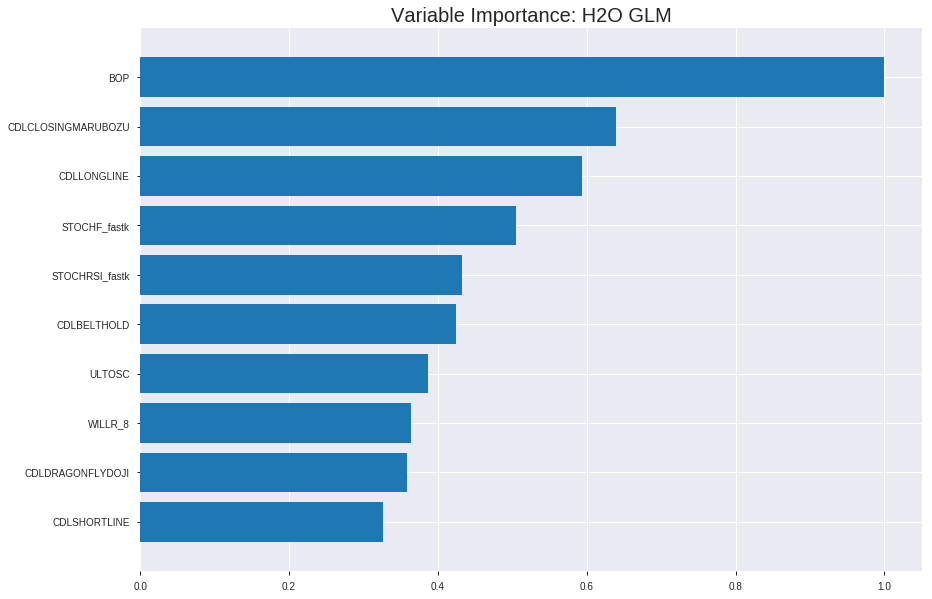

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_041406_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.21385080215208274
RMSE: 0.4624400524955454
LogLoss: 0.6175385932476073
Null degrees of freedom: 1751
Residual degrees of freedom: 717
Null deviance: 2421.1017340295916
Residual deviance: 2163.8552307396158
AIC: 4233.855230739616
AUC: 0.7320441301969078
pr_auc: 0.7093619100801999
Gini: 0.4640882603938157
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38698729073575144: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      390  544   0.5824   (544.0/934.0)
1      109  709   0.1333   (109.0/818.0)
Total  499  1253  0.3727   (653.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.386987     0.684693  277
max f2                       0.312697     0.822981  335
max f0point5                 0.473298     0.649383  203
max accuracy                 0.461831     0.673516  213
max precision                0.791086     1         0
max recall                   0.212052     1         392
max specificity              0.791086     1         0
max absolute_mcc             0.461831     0.347948  213
max min_per_class_accuracy   0.465887     0.669165  209
max mean_per_class_accuracy  0.461831     0.674356  213

Gains/Lift Table: Avg response rate: 46.69 %, avg score: 46.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.739088           1.90383   1.90383            0.888889         0.76037   0.888889                    0.76037             0.0195599       0.0195599                  90.383    90.383
    2        0.0205479                   0.723197           2.14181   2.02282            1                0.729445  0.944444                    0.744908            0.0220049       0.0415648                  114.181   102.282
    3        0.0302511                   0.703657           2.14181   2.06099            1                0.712639  0.962264                    0.734558            0.0207824       0.0623472                  114.181   106.099
    4        0.0405251                   0.691035           2.02282   2.05131            0.944444         0.697091  0.957746                    0.725059            0.0207824       0.0831296                  102.282   105.131
    5        0.0502283                   0.680893           2.01582   2.04445            0.941176         0.685007  0.954545                    0.717322            0.0195599       0.102689                   101.582   104.445
    6        0.100457                    0.638189           1.65503   1.84974            0.772727         0.657294  0.863636                    0.687308            0.0831296       0.185819                   65.5034   84.9744
    7        0.150114                    0.611881           1.40325   1.70205            0.655172         0.624347  0.794677                    0.666481            0.0696822       0.255501                   40.3254   70.2046
    8        0.200342                    0.581733           1.31429   1.60483            0.613636         0.597843  0.749288                    0.649272            0.0660147       0.321516                   31.4292   60.4831
    9        0.300228                    0.534362           1.29732   1.50252            0.605714         0.556361  0.701521                    0.618361            0.129584        0.4511                     29.7324   50.2524
    10       0.400114                    0.49337            1.17494   1.42074            0.548571         0.512952  0.663338                    0.592046            0.117359        0.56846                    17.4935   42.0744
    11       0.5                         0.461663           1.17494   1.37164            0.548571         0.476618  0.640411                    0.568987            0.117359        0.685819                   17.4935   37.1638
    12       0.599886                    0.426748           0.832246  1.28182            0.388571         0.444083  0.598478                    0.548189            0.0831296       0.768949                   -16.7754  28.1825
    13       0.699772                    0.391538           0.807768  1.21416            0.377143         0.409666  0.566884                    0.528416            0.0806846       0.849633                   -19.2232  21.4158
    14       0.799658                    0.35576            0.722096  1.15269            0.337143         0.372996  0.538187                    0.509003            0.0721271       0.92176                    -27.7904  15.2694
    15       0.899543                    0.307023           0.526273  1.08314            0.245714         0.333048  0.505711                    0.489465            0.0525672       0.974328                   -47.3727  8.31358
    16       1                           0.137663           0.255557  1                  0.119318         0.264795  0.466895                    0.466895          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.39401111520158094
RMSE: 0.627703046990837
LogLoss: 1.5396306524663843
Null degrees of freedom: 499
Residual degrees of freedom: -535
Null deviance: 702.7702737716033
Residual deviance: 1539.6306524663823
AIC: 3609.6306524663823
AUC: 0.5633871281353295
pr_auc: 0.6177355343629266
Gini: 0.12677425627065908
Confusion Matrix (Act/Pred) for max f1 @ threshold = 9.174629214147591e-05: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    222  1        (222.0/222.0)
1      0    278  0        (0.0/278.0)
Total  0    500  0.444    (222.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       9.17463e-05  0.714653  399
max f2                       9.17463e-05  0.862283  399
max f0point5                 0.000709147  0.613165  395
max accuracy                 0.00298486   0.562     384
max precision                0.997355     1         0
max recall                   9.17463e-05  1         399
max specificity              0.997355     1         0
max absolute_mcc             0.365362     0.187752  101
max min_per_class_accuracy   0.130418     0.540541  234
max mean_per_class_accuracy  0.365362     0.577225  101

Gains/Lift Table: Avg response rate: 55.60 %, avg score: 20.99 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.991782           1.07914   1.07914            0.6              0.995738    0.6                         0.995738            0.0107914       0.0107914                  7.91367   7.91367
    2        0.02                        0.967151           0.719424  0.899281           0.4              0.988928    0.5                         0.992333            0.00719424      0.0179856                  -28.0576  -10.0719
    3        0.03                        0.886406           0.719424  0.839329           0.4              0.948425    0.466667                    0.977697            0.00719424      0.0251799                  -28.0576  -16.0671
    4        0.04                        0.775602           1.79856   1.07914            1                0.845055    0.6                         0.944536            0.0179856       0.0431655                  79.8561   7.91367
    5        0.05                        0.576682           1.07914   1.07914            0.6              0.671298    0.6                         0.889889            0.0107914       0.0539568                  7.91367   7.91367
    6        0.1                         0.471931           1.51079   1.29496            0.84             0.516981    0.72                        0.703435            0.0755396       0.129496                   51.0791   29.4964
    7        0.15                        0.410236           1.07914   1.22302            0.6              0.438365    0.68                        0.615078            0.0539568       0.183453                   7.91367   22.3022
    8        0.2                         0.375873           1.58273   1.31295            0.88             0.392377    0.73                        0.559403            0.0791367       0.26259                    58.2734   31.295
    9        0.3                         0.306113           1.04317   1.22302            0.58             0.341795    0.68                        0.486867            0.104317        0.366906                   4.31655   22.3022
    10       0.4                         0.200042           0.827338  1.1241             0.46             0.269405    0.625                       0.432501            0.0827338       0.44964                    -17.2662  12.4101
    11       0.5                         0.135391           0.863309  1.07194            0.48             0.171759    0.596                       0.380353            0.0863309       0.535971                   -13.6691  7.19424
    12       0.6                         0.0842692          0.899281  1.04317            0.5              0.106476    0.58                        0.334707            0.0899281       0.625899                   -10.0719  4.31655
    13       0.7                         0.0387082          0.863309  1.01747            0.48             0.0591538   0.565714                    0.295342            0.0863309       0.71223                    -13.6691  1.74717
    14       0.8                         0.0114752          1.04317   1.02068            0.58             0.0234925   0.5675                      0.261361            0.104317        0.816547                   4.31655   2.06835
    15       0.9                         0.00336539         0.971223  1.01519            0.54             0.00687326  0.564444                    0.233085            0.0971223       0.913669                   -2.8777   1.51878
    16       1                           2.70825e-05        0.863309  1                  0.48             0.00134832  0.556   


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 04:14:11  0.000 sec   3            20        1034          1.32981           3.80377
    2019-07-25 04:14:13  1.940 sec   5            14        1035          1.32232           3.83104
    2019-07-25 04:14:15  3.888 sec   7            10        1035          1.31392           3.77964
    2019-07-25 04:14:17  5.910 sec   9            7.6       1035          1.30434           3.66253
    2019-07-25 04:14:19  7.843 sec   11           5.5       1035          1.29337           3.52186
    2019-07-25 04:14:20  9.794 sec   13           4         1035          1.28091           3.36331
    2019-07-25 04:14:22  11.745 sec  15           2.9       1035          1.26693           3.2098
    2019-07-25 04:14:24  13.773 sec  17           2.1       1035          1.25156           3.10133
    2019-07-25 04:14:27  15.808 sec  19           1.5       1035          1.23508           3.07926
    2019-07-25 04:14:28  17.768 sec  21           1.1       1035          1.21784           3.13894
    2019-07-25 04:14:30  19.776 sec  23           0.82      1035          1.20033           3.26827
    2019-07-25 04:14:32  21.734 sec  25           0.6       1035          1.18304           3.43797
    2019-07-25 04:14:34  23.701 sec  27           0.43      1035          1.16637           3.68538
    2019-07-25 04:14:36  25.704 sec  29           0.32      1035          1.15066           4.03278

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5936254980079682)

('F1', 0.5878962536023055)

('auc', 0.5416502171338334)

('logloss', 1.9464410281411597)

('mean_per_class_error', 0.4217331227793131)

('rmse', 0.6255193041139521)

('mse', 0.3912743998192028)

glm prediction progress: |████████████████████████████████████████████████| 100%


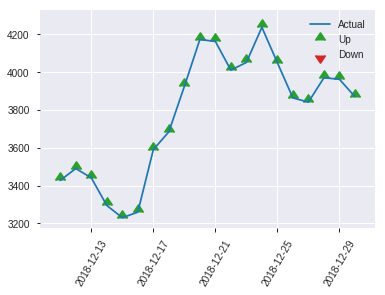


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.3912743998192028
RMSE: 0.6255193041139521
LogLoss: 1.9464410281411597
Null degrees of freedom: 250
Residual degrees of freedom: -784
Null deviance: 342.8297670320054
Residual deviance: 977.113396126862
AIC: 3047.113396126862
AUC: 0.5416502171338334
pr_auc: 0.41324813991184367
Gini: 0.08330043426766687
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00029011012348157734: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      6    143  0.9597   (143.0/149.0)
1      0    102  0        (0.0/102.0)
Total  6    245  0.5697   (143.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00029011   0.587896  244
max f2                       0.00029011   0.781011  244
max f0point5                 0.00401351   0.502481  175
max accuracy                 0.785343     0.593625  1
max precision                0.785343     0.5       1
max recall                   0.00029011   1         244
max specificity              0.795201     0.993289  0
max absolute_mcc             0.00401351   0.167963  175
max min_per_class_accuracy   0.00633892   0.557047  122
max mean_per_class_accuracy  0.00401351   0.578267  175

Gains/Lift Table: Avg response rate: 40.64 %, avg score:  4.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.747488           0.820261  0.820261           0.333333         0.77771      0.333333                    0.77771             0.00980392      0.00980392                 -17.9739  -17.9739
    2        0.0239044                   0.65207            1.64052   1.23039            0.666667         0.695504     0.5                         0.736607            0.0196078       0.0294118                  64.0523   23.0392
    3        0.0318725                   0.464              0         0.922794           0                0.4921       0.375                       0.67548             0               0.0294118                  -100      -7.72059
    4        0.0438247                   0.226033           0.820261  0.894831           0.333333         0.30443      0.363636                    0.574285            0.00980392      0.0392157                  -17.9739  -10.5169
    5        0.0517928                   0.170406           0         0.757164           0                0.200447     0.307692                    0.516771            0               0.0392157                  -100      -24.2836
    6        0.103586                    0.0773628          0.757164  0.757164           0.307692         0.107787     0.307692                    0.312279            0.0392157       0.0784314                  -24.2836  -24.2836
    7        0.151394                    0.0480473          1.23039   0.906605           0.5              0.0625004    0.368421                    0.233402            0.0588235       0.137255                   23.0392   -9.33953
    8        0.203187                    0.0333144          0.946456  0.916763           0.384615         0.0410321    0.372549                    0.184366            0.0490196       0.186275                   -5.35445  -8.32372
    9        0.302789                    0.0153517          1.08275   0.971362           0.44             0.0228805    0.394737                    0.131246            0.107843        0.294118                   8.27451   -2.86378
    10       0.40239                     0.00812601         1.18118   1.0233             0.48             0.0116599    0.415842                    0.101645            0.117647        0.411765                   18.1176   2.32964
    11       0.501992                    0.00592071         1.47647   1.11321            0.6              0.00699815   0.452381                    0.0828663           0.147059        0.558824                   47.6471   11.3212
    12       0.601594                    0.00493213         1.27961   1.14076            0.52             0.00529087   0.463576                    0.0700226           0.127451        0.686275                   27.9608   14.0761
    13       0.701195                    0.00401351         1.08275   1.13252            0.44             0.00448274   0.460227                    0.060713            0.107843        0.794118                   8.27451   13.252
    14       0.800797                    0.00317816         0.393725  1.04063            0.16             0.00358967   0.422886                    0.0536081           0.0392157       0.833333                   -60.6275  4.06302
    15       0.900398                    0.00190827         0.885882  1.02351            0.36             0.00268842   0.415929                    0.0479754           0.0882353       0.921569                   -11.4118  2.35121
    16       1                           0.000158963        0.787451  1                  0.32          

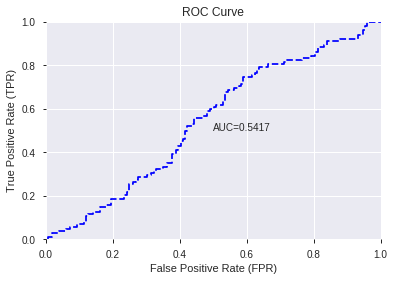

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


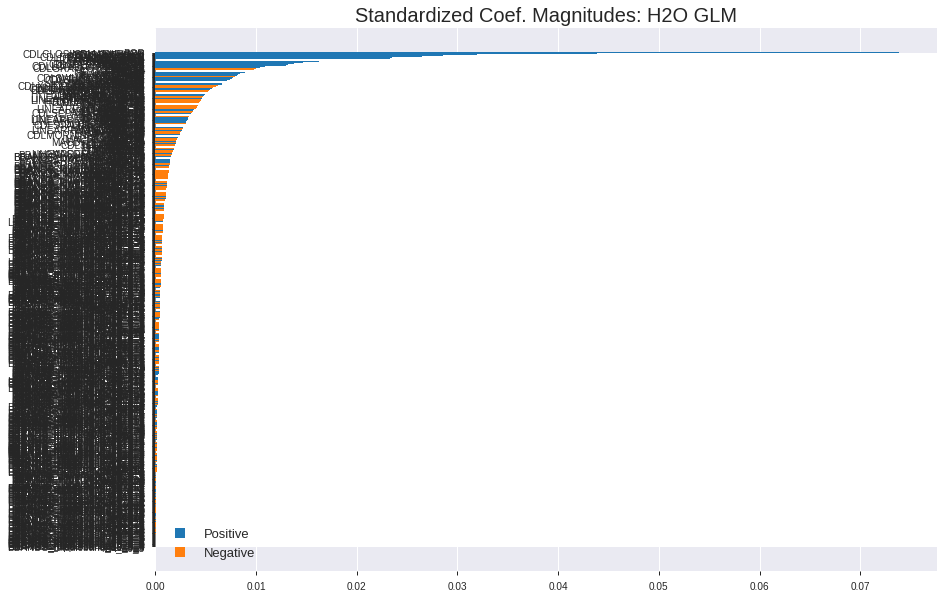

'log_likelihood'
--2019-07-25 04:14:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.169.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.169.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_041406_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_041406_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_be36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

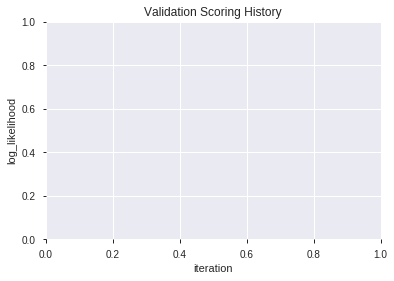

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_041504_model_1  0.735360  0.602910              0.306882  0.457262  0.209088
1               XGBoost_2_AutoML_20190725_041504  0.730293  0.611747              0.303264  0.461744  0.213208
2  XGBoost_grid_1_AutoML_20190725_041504_model_2  0.728188  0.609817              0.305863  0.460564  0.212119
3  XGBoost_grid_1_AutoML_20190725_041504_model_4  0.719700  0.617797              0.314877  0.464346  0.215617
4               XGBoost_1_AutoML_20190725_041504  0.711344  0.622464              0.321062  0.465600  0.216784
5  XGBoost_grid_1_AutoML_20190725_041504_model_6  0.708251  0.615308              0.313331  0.462487  0.213894
6  XGBoost_grid_1_AutoML_20190725_041504_model_5  0.707330  0.616570              0.351033  0.462963  0.214335
7               XGBoost_3_AutoML_20190725_041504  0.705751  0.624407              0.315403  0.468077  0.219096
8  XGBoost_grid_1_AutoML_20190725_041504_model_7  0.702856  0.637873              0.343269  0.472932  0.223665
9  XGBoost_grid_1_AutoML_20190725_041504_model_3  0.695881  0.628553              0.330372  0.469046  0.220004

variable  relative_importance  scaled_importance  percentage
0                        BOP          2808.559326           1.000000    0.287863
1               STOCHF_fastk           641.805359           0.228518    0.065782
2                   WILLR_12           494.982300           0.176241    0.050733
3                        DIV           351.355957           0.125102    0.036012
4                     TRANGE           255.194824           0.090863    0.026156
..                       ...                  ...                ...         ...
224  BBANDS_lowerband_20_5_5             1.539600           0.000548    0.000158
225                STDDEV_12             1.357540           0.000483    0.000139
226  BBANDS_lowerband_30_5_5             1.343826           0.000478    0.000138
227                   ROC_14             1.264000           0.000450    0.000130
228                MACD_hist             0.981150           0.000349    0.000101

[229 rows x 4 columns]

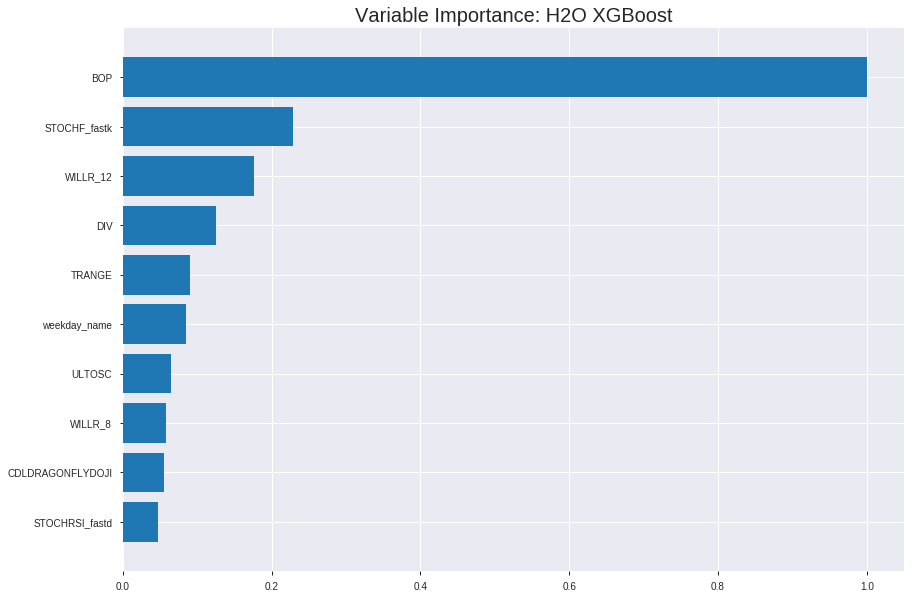

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_041504_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13005393289276515
RMSE: 0.36062991125635313
LogLoss: 0.419777411798502
Mean Per-Class Error: 0.1466940309838065
AUC: 0.9368661748768344
pr_auc: 0.9242213703427925
Gini: 0.8737323497536689
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47173984050750734: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      789  145  0.1552   (145.0/934.0)
1      113  705  0.1381   (113.0/818.0)
Total  902  850  0.1473   (258.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.47174      0.845324  206
max f2                       0.379289     0.906807  256
max f0point5                 0.550926     0.864179  165
max accuracy                 0.47174      0.85274   206
max precision                0.966338     1         0
max recall                   0.164178     1         347
max specificity              0.966338     1         0
max absolute_mcc             0.47174      0.705372  206
max min_per_class_accuracy   0.476238     0.850107  203
max mean_per_class_accuracy  0.47174      0.853306  206

Gains/Lift Table: Avg response rate: 46.69 %, avg score: 46.81 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.948097           2.14181    2.14181            1                0.957081   1                           0.957081            0.0220049       0.0220049                  114.181   114.181
    2        0.0205479                   0.935884           2.14181    2.14181            1                0.94271    1                           0.949896            0.0220049       0.0440098                  114.181   114.181
    3        0.0302511                   0.927665           2.14181    2.14181            1                0.9319     1                           0.944124            0.0207824       0.0647922                  114.181   114.181
    4        0.0405251                   0.920639           2.14181    2.14181            1                0.923728   1                           0.938953            0.0220049       0.0867971                  114.181   114.181
    5        0.0502283                   0.904676           2.14181    2.14181            1                0.91416    1                           0.934163            0.0207824       0.107579                   114.181   114.181
    6        0.100457                    0.816491           2.11747    2.12964            0.988636         0.859589   0.994318                    0.896876            0.106357        0.213936                   111.747   112.964
    7        0.150114                    0.731121           2.06795    2.10923            0.965517         0.768206   0.984791                    0.854312            0.102689        0.316626                   106.795   110.923
    8        0.200342                    0.688253           2.04445    2.09299            0.954545         0.708494   0.977208                    0.817754            0.102689        0.419315                   104.445   109.299
    9        0.300228                    0.594227           1.94599    2.04408            0.908571         0.641309   0.954373                    0.759051            0.194377        0.613692                   94.5987   104.408
    10       0.400114                    0.525607           1.41971    1.88821            0.662857         0.55897    0.881598                    0.709102            0.141809        0.755501                   41.9714   88.8214
    11       0.5                         0.46136            1.17494    1.74572            0.548571         0.4944     0.815068                    0.666211            0.117359        0.872861                   17.4935   74.5721
    12       0.599886                    0.398756           0.820007   1.59158            0.382857         0.431202   0.743102                    0.62708             0.0819071       0.954768                   -17.9993  59.1582
    13       0.699772                    0.333188           0.293734   1.40633            0.137143         0.36571    0.656607                    0.589772            0.0293399       0.984108                   -70.6266  40.6327
    14       0.799658                    0.232604           0.0979113  1.24289            0.0457143        0.290848   0.5803                      0.552433            0.00977995      0.993888                   -90.2089  24.2891
    15       0.899543                    0.118224           0.0611946  1.11168            0.0285714        0.171604   0.519036                    0.510145            0.00611247      1                          -93.8805  11.1675
    16       1                           0.0512829          0          1                  0                0.0913845  0.466895 



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19788405017637162
RMSE: 0.44484160122044747
LogLoss: 0.5717306570263072
Mean Per-Class Error: 0.27453172597057485
AUC: 0.793076349731026
pr_auc: 0.8197479796682767
Gini: 0.5861526994620521
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3345998525619507: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      112  110  0.4955   (110.0/222.0)
1      28   250  0.1007   (28.0/278.0)
Total  140  360  0.276    (138.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.3346       0.783699  280
max f2                       0.148923     0.878205  357
max f0point5                 0.415451     0.758595  215
max accuracy                 0.351838     0.73      269
max precision                0.965134     1         0
max recall                   0.0806611    1         391
max specificity              0.965134     1         0
max absolute_mcc             0.350776     0.453534  270
max min_per_class_accuracy   0.41736      0.723022  213
max mean_per_class_accuracy  0.415451     0.725468  215

Gains/Lift Table: Avg response rate: 55.60 %, avg score: 45.04 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.950691           1.79856   1.79856            1                0.95693    1                           0.95693             0.0179856       0.0179856                  79.8561   79.8561
    2        0.02                        0.939767           1.79856   1.79856            1                0.947552   1                           0.952241            0.0179856       0.0359712                  79.8561   79.8561
    3        0.03                        0.935872           1.79856   1.79856            1                0.938006   1                           0.947496            0.0179856       0.0539568                  79.8561   79.8561
    4        0.04                        0.929997           1.79856   1.79856            1                0.933002   1                           0.943873            0.0179856       0.0719424                  79.8561   79.8561
    5        0.05                        0.921532           1.79856   1.79856            1                0.927046   1                           0.940507            0.0179856       0.0899281                  79.8561   79.8561
    6        0.1                         0.821045           1.65468   1.72662            0.92             0.880272   0.96                        0.91039             0.0827338       0.172662                   65.4676   72.6619
    7        0.15                        0.700162           1.58273   1.67866            0.88             0.759576   0.933333                    0.860119            0.0791367       0.251799                   58.2734   67.8657
    8        0.2                         0.625968           1.22302   1.56475            0.68             0.658628   0.87                        0.809746            0.0611511       0.31295                    22.3022   56.4748
    9        0.3                         0.526587           1.29496   1.47482            0.72             0.574518   0.82                        0.731337            0.129496        0.442446                   29.4964   47.482
    10       0.4                         0.473042           1.29496   1.42986            0.72             0.496794   0.795                       0.672701            0.129496        0.571942                   29.4964   42.9856
    11       0.5                         0.426203           1.18705   1.38129            0.66             0.44782    0.768                       0.627725            0.118705        0.690647                   18.705    38.1295
    12       0.6                         0.38546            0.971223  1.31295            0.54             0.404579   0.73                        0.590534            0.0971223       0.78777                    -2.8777   31.295
    13       0.7                         0.346037           0.935252  1.25899            0.52             0.365072   0.7                         0.558325            0.0935252       0.881295                   -6.47482  25.8993
    14       0.8                         0.251556           0.647482  1.18255            0.36             0.301229   0.6575                      0.526188            0.0647482       0.946043                   -35.2518  18.2554
    15       0.9                         0.138936           0.395683  1.09512            0.22             0.196828   0.608889                    0.489592            0.0395683       0.985612                   -60.4317  9.51239
    16       1                           0.0557025          0.143885  1                  0.08             0.0974903  0.556                       0


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:15:21  0.009 sec   0                  0.5              0.693147            0.5             0                  1                0.533105                         0.5                0.693147              0.5               0                    1                  0.444
    2019-07-25 04:15:22  0.673 sec   5                  0.469606         0.633659            0.843638        0.822681           2.14181          0.269406                         0.479672           0.652866              0.754602          0.74136              1.79856            0.288
    2019-07-25 04:15:22  0.927 sec   10                 0.447432         0.590781            0.860778        0.85032            2.14181          0.244292                         0.46667            0.626568              0.764397          0.797728             1.79856            0.29
    2019-07-25 04:15:23  1.140 sec   15                 0.430378         0.55749             0.87722         0.865167           2.14181          0.212329                         0.456974           0.606195              0.782933          0.812007             1.79856            0.286
    2019-07-25 04:15:23  1.341 sec   20                 0.417785         0.532111            0.88243         0.874063           2.14181          0.20605                          0.450774           0.591845              0.790273          0.815718             1.79856            0.256
    2019-07-25 04:15:23  1.545 sec   25                 0.406744         0.510034            0.892579        0.884593           2.14181          0.201484                         0.447702           0.583551              0.790184          0.81692              1.79856            0.25
    2019-07-25 04:15:23  1.749 sec   30                 0.398549         0.492913            0.898831        0.888326           2.14181          0.192922                         0.445958           0.578126              0.789487          0.816485             1.79856            0.26
    2019-07-25 04:15:23  1.964 sec   35                 0.391307         0.478147            0.90513         0.898644           2.14181          0.187785                         0.444532           0.574195              0.790678          0.817595             1.79856            0.27
    2019-07-25 04:15:24  2.163 sec   40                 0.384173         0.464051            0.912196        0.905911           2.14181          0.187785                         0.443858           0.571895              0.789017          0.816802             1.79856            0.27
    2019-07-25 04:15:24  2.344 sec   45                 0.377878         0.452196            0.919823        0.910861           2.14181          0.175799                         0.445248           0.573966              0.791302          0.818462             1.79856            0.256
    2019-07-25 04:15:24  2.526 sec   50                 0.372812         0.44255             0.924617        0.916644           2.14181          0.162671                         0.444655           0.572062              0.791683          0.81879              1.79856            0.278
    2019-07-25 04:15:24  2.711 sec   55                 0.368616         0.434476            0.928716        0.921088           2.14181          0.164384                         0.444889           0.571984              0.792177          0.818685             1.79856           

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      2808.559326171875      1.0                     0.28786316988884725
STOCHF_fastk             641.8053588867188      0.22851764351423293     0.06578181323753667
WILLR_12                 494.9822998046875      0.1762406423792225      0.05073318997852969
DIV                      351.35595703125        0.12510184625872067     0.036012214022982554
TRANGE                   255.19482421875        0.09086324858467058     0.02615618276398159
---                      ---                    ---                     ---
BBANDS_lowerband_20_5_5  1.5396003723144531     0.0005481815384733071   0.00015780127533947125
STDDEV_12                1.3575401306152344     0.00048335818224128096  0.00013914101853168626
BBANDS_lowerband_30_5_5  1.3438262939453125     0.0004784753098938365   0.0001377354194195883
ROC_14                   1.2639999389648438     0.0004500527822881      0.0001295536205267477
MACD_hist                0.9811496734619141     0.00034934269122213686  0.0001005628944727051


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6972111553784861)

('F1', 0.6743295019157088)

('auc', 0.7353599157783919)

('logloss', 0.6029102068607964)

('mean_per_class_error', 0.30688248453743916)

('rmse', 0.4572618938981041)

('mse', 0.20908843961128104)

xgboost prediction progress: |████████████████████████████████████████████| 100%


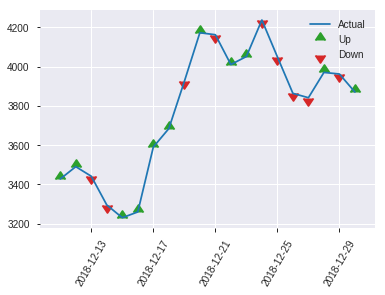


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.20908843961128104
RMSE: 0.4572618938981041
LogLoss: 0.6029102068607964
Mean Per-Class Error: 0.30688248453743916
AUC: 0.7353599157783919
pr_auc: 0.6111437029162071
Gini: 0.47071983155678376
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31474700570106506: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      78   71   0.4765   (71.0/149.0)
1      14   88   0.1373   (14.0/102.0)
Total  92   159  0.3386   (85.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.314747     0.67433   158
max f2                       0.189304     0.801653  196
max f0point5                 0.416084     0.627753  87
max accuracy                 0.416084     0.697211  87
max precision                0.921762     1         0
max recall                   0.0817756    1         245
max specificity              0.921762     1         0
max absolute_mcc             0.314747     0.393688  158
max min_per_class_accuracy   0.377932     0.676471  115
max mean_per_class_accuracy  0.314747     0.693118  158

Gains/Lift Table: Avg response rate: 40.64 %, avg score: 34.99 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.81366            2.46078    2.46078            1                0.884783   1                           0.884783            0.0294118       0.0294118                  146.078   146.078
    2        0.0239044                   0.791664           0.820261   1.64052            0.333333         0.79822    0.666667                    0.841501            0.00980392      0.0392157                  -17.9739  64.0523
    3        0.0318725                   0.722237           1.23039    1.53799            0.5              0.739426   0.625                       0.815982            0.00980392      0.0490196                  23.0392   53.799
    4        0.0438247                   0.588714           2.46078    1.78966            1                0.667201   0.727273                    0.775406            0.0294118       0.0784314                  146.078   78.9661
    5        0.0517928                   0.569708           1.23039    1.70362            0.5              0.579728   0.692308                    0.745302            0.00980392      0.0882353                  23.0392   70.362
    6        0.103586                    0.524434           1.70362    1.70362            0.692308         0.543333   0.692308                    0.644317            0.0882353       0.176471                   70.362    70.362
    7        0.151394                    0.49249            1.43546    1.61894            0.583333         0.5075     0.657895                    0.601112            0.0686275       0.245098                   43.5458   61.8937
    8        0.203187                    0.457863           1.70362    1.64052            0.692308         0.47396    0.666667                    0.568701            0.0882353       0.333333                   70.362    64.0523
    9        0.302789                    0.428967           1.47647    1.58656            0.6              0.442773   0.644737                    0.527277            0.147059        0.480392                   47.6471   58.6558
    10       0.40239                     0.397876           1.18118    1.48622            0.48             0.413164   0.60396                     0.499031            0.117647        0.598039                   18.1176   48.6216
    11       0.501992                    0.365236           0.885882   1.3671             0.36             0.380071   0.555556                    0.475428            0.0882353       0.686275                   -11.4118  36.7102
    12       0.601594                    0.336446           1.37804    1.36891            0.56             0.347975   0.556291                    0.454327            0.137255        0.823529                   37.8039   36.8913
    13       0.701195                    0.263325           0.68902    1.27234            0.28             0.301437   0.517045                    0.432609            0.0686275       0.892157                   -31.098   27.2337
    14       0.800797                    0.182              0.590588   1.18754            0.24             0.219658   0.482587                    0.406123            0.0588235       0.95098                    -40.9412  18.7543
    15       0.900398                    0.125195           0.0984314  1.06707            0.04             0.151263   0.433628                    0.37793             0.00980392      0.960784                   -90.1569  6.70658
    16       1                           0.0676586          0.393725   1                  0.16             0.0962992  0.406375    

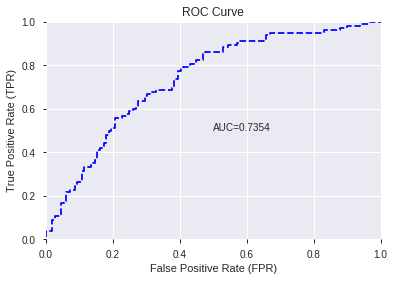

This function is available for GLM models only


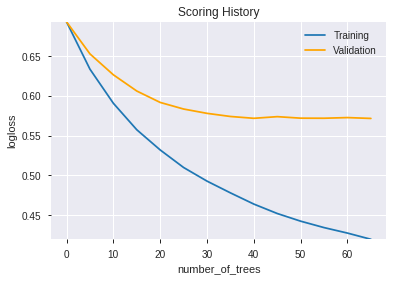

--2019-07-25 04:15:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.132.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.132.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_041504_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_041504_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_be36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_041604_model_9  0.564877   0.713974              0.407060  0.507578  0.257635
1  DeepLearning_grid_1_AutoML_20190725_041604_model_8  0.542242   0.879633              0.420746  0.541466  0.293186
2               DeepLearning_1_AutoML_20190725_041604  0.531912   5.937709              0.500000  0.635828  0.404277
3  DeepLearning_grid_1_AutoML_20190725_041604_model_6  0.519970   1.111030              0.422292  0.573408  0.328797
4  DeepLearning_grid_1_AutoML_20190725_041604_model_4  0.502369   7.285549              0.423049  0.644583  0.415488
5  DeepLearning_grid_1_AutoML_20190725_041604_model_7  0.502106   1.704836              0.427721  0.609298  0.371244
6  DeepLearning_grid_1_AutoML_20190725_041604_model_5  0.495953   1.335366              0.440880  0.589228  0.347190
7  DeepLearning_grid_1_AutoML_20190725_041604_model_3  0.477004  10.972562              0.442427  0.675259  0.455974
8  DeepLearning_grid_1_AutoML_20190725_041604_model_2  0.465522  12.632576              0.451967  0.679801  0.462129
9  DeepLearning_grid_1_AutoML_20190725_041604_model_1  0.455389  11.162720              0.483221  0.678399  0.460226

variable  relative_importance  scaled_importance  percentage
0                        BOP             1.000000           1.000000    0.042200
1         CDLCLOSINGMARUBOZU             0.771670           0.771670    0.032564
2               weekday_name             0.531377           0.531377    0.022424
3                     ULTOSC             0.512424           0.512424    0.021624
4                     TRANGE             0.509699           0.509699    0.021509
5                    BETA_12             0.492204           0.492204    0.020771
6         CDLMORNINGDOJISTAR             0.491820           0.491820    0.020755
7               CDLTASUKIGAP             0.485958           0.485958    0.020507
8                     Volume             0.485034           0.485034    0.020468
9              CDLHANGINGMAN             0.484382           0.484382    0.020441
10         CDLSTALLEDPATTERN             0.482038           0.482038    0.020342
11                    BETA_8             0.478159           0.478159    0.020178
12           CDLUNIQUE3RIVER             0.473599           0.473599    0.019986
13              STOCHF_fastk             0.473059           0.473059    0.019963
14                 CDLHAMMER             0.472748           0.472748    0.019950
15                       SIN             0.471818           0.471818    0.019911
16                   BETA_24             0.471353           0.471353    0.019891
17         CDLDARKCLOUDCOVER             0.469125           0.469125    0.019797
18         CDL3WHITESOLDIERS             0.463768           0.463768    0.019571
19            CDLMATCHINGLOW             0.460201           0.460201    0.019420
20                 PLUS_DM_8             0.459487           0.459487    0.019390
21        CDLIDENTICAL3CROWS             0.456053           0.456053    0.019245
22   BBANDS_lowerband_20_3_5             0.455320           0.455320    0.019214
23                   BETA_30             0.452872           0.452872    0.019111
24          is_quarter_start             0.451205           0.451205    0.019041
25            CDL3LINESTRIKE             0.451115           0.451115    0.019037
26            CDLEVENINGSTAR             0.450505           0.450505    0.019011
27   BBANDS_upperband_24_0_4             0.448727           0.448727    0.018936
28                      ATAN             0.448410           0.448410    0.018923
29             days_in_month             0.447915           0.447915    0.018902
30              is_month_end             0.447732           0.447732    0.018894
31                  WILLR_24             0.447431           0.447431    0.018882
32           CDLSHOOTINGSTAR             0.446616           0.446616    0.018847
33                  WILLR_20             0.445600           0.445600    0.018804
34                   BETA_14             0.444693           0.444693    0.018766
35                  WILLR_14             0.442135           0.442135    0.018658
36   BBANDS_lowerband_20_5_5             0.441259           0.441259    0.018621
37         CDLGRAVESTONEDOJI             0.441070           0.441070    0.018613
38                      TANH             0.440760           0.440760    0.018600
39                       TAN             0.439489           0.439489    0.018546
40                     VAR_8             0.439006           0.439006    0.018526
41                   CDLDOJI             0.436922           0.436922    0.018438
42         Volume_(Currency)             0.436388           0.436388    0.018416
43   BBANDS_lowerband_20_1_5             0.432979           0.432979    0.018272
44  BBANDS_middleband_14_3_4             0.432165           0.432165    0.018237
45        LINEARREG_ANGLE_20             0.432052           0.432052    0.018233
46   BBANDS_lowerband_14_6_2             0.428221           0.428221    0.018071
47  BBANDS_middleband_30_0_2             0.419290           0.419290    0.017694
48    BBANDS_upperband_8_3_3             0.407027  

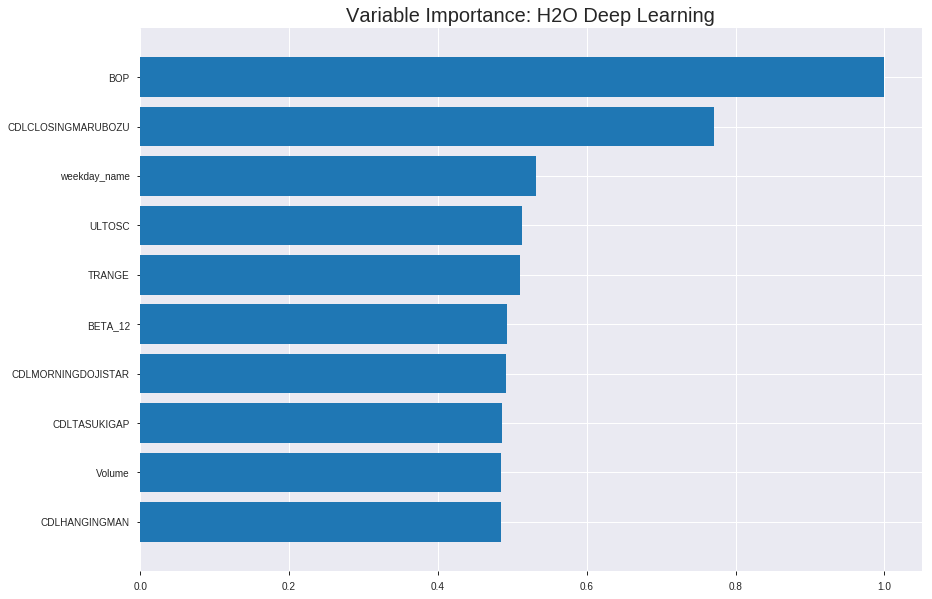

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_041604_model_9


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.1956622602162295
RMSE: 0.4423372697571724
LogLoss: 0.5739807110011348
Mean Per-Class Error: 0.29844557415328554
AUC: 0.7676993293299058
pr_auc: 0.7460696757519866
Gini: 0.5353986586598116
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3520365259769157: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      423  511   0.5471   (511.0/934.0)
1      96   722   0.1174   (96.0/818.0)
Total  519  1233  0.3465   (607.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.352037     0.704047  260
max f2                       0.189777     0.827543  326
max f0point5                 0.513753     0.679191  156
max accuracy                 0.432988     0.69863   210
max precision                0.908082     1         0
max recall                   0.0385296    1         395
max specificity              0.908082     1         0
max absolute_mcc             0.432988     0.402991  210
max min_per_class_accuracy   0.449369     0.693154  199
max mean_per_class_accuracy  0.432988     0.701554  210

Gains/Lift Table: Avg response rate: 46.69 %, avg score: 44.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.882765           2.14181   2.14181            1                0.890906  1                           0.890906            0.0220049       0.0220049                  114.181   114.181
    2        0.0205479                   0.869283           2.02282   2.08231            0.944444         0.877574  0.972222                    0.88424             0.0207824       0.0427873                  102.282   108.231
    3        0.0302511                   0.857678           1.76384   1.98016            0.823529         0.86221   0.924528                    0.877174            0.0171149       0.0599022                  76.3843   98.0163
    4        0.0405251                   0.843266           2.14181   2.02114            1                0.850303  0.943662                    0.870362            0.0220049       0.0819071                  114.181   102.114
    5        0.0502283                   0.829065           1.76384   1.97144            0.823529         0.836738  0.920455                    0.863866            0.0171149       0.099022                   76.3843   97.1438
    6        0.100457                    0.758814           1.84974   1.91059            0.863636         0.795138  0.892045                    0.829502            0.0929095       0.191932                   84.9744   91.0591
    7        0.150114                    0.69239            1.77253   1.86492            0.827586         0.726797  0.870722                    0.795527            0.0880196       0.279951                   77.2532   86.4921
    8        0.200342                    0.62557            1.38731   1.74518            0.647727         0.654436  0.814815                    0.760154            0.0696822       0.349633                   38.7308   74.5178
    9        0.300228                    0.525702           1.28509   1.59211            0.6              0.566141  0.743346                    0.695606            0.128362        0.477995                   28.5086   59.2105
    10       0.400114                    0.478548           1.12598   1.47574            0.525714         0.501551  0.689016                    0.647161            0.112469        0.590465                   12.598    47.574
    11       0.5                         0.442044           1.13822   1.40831            0.531429         0.460448  0.657534                    0.609861            0.113692        0.704156                   13.8219   40.8313
    12       0.599886                    0.406439           0.930157  1.3287             0.434286         0.42511   0.620362                    0.579099            0.0929095       0.797066                   -6.98428  32.8696
    13       0.699772                    0.353873           0.807768  1.25434            0.377143         0.382865  0.585644                    0.551088            0.0806846       0.877751                   -19.2232  25.4339
    14       0.799658                    0.244889           0.624184  1.17563            0.291429         0.305808  0.548894                    0.52045             0.0623472       0.940098                   -37.5816  17.5626
    15       0.899543                    0.129857           0.379406  1.08721            0.177143         0.185073  0.507614                    0.48321             0.0378973       0.977995                   -62.0594  8.72128
    16       1                           0.0219379          0.219049  1                  0.102273         0.086185  0.466895                    0.443326          



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2798214158867861
RMSE: 0.5289814891721506
LogLoss: 0.9152815857503334
Mean Per-Class Error: 0.37243178430228796
AUC: 0.6098337546179272
pr_auc: 0.5838477513858041
Gini: 0.21966750923585443
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24801494726696788: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      57   165  0.7432   (165.0/222.0)
1      12   266  0.0432   (12.0/278.0)
Total  69   431  0.354    (177.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.248015     0.750353  336
max f2                       0.193443     0.88142   365
max f0point5                 0.29838      0.675676  304
max accuracy                 0.29838      0.658     304
max precision                0.445167     0.64186   170
max recall                   0.193443     1         365
max specificity              0.99996      0.977477  0
max absolute_mcc             0.293281     0.312367  309
max min_per_class_accuracy   0.404457     0.572072  203
max mean_per_class_accuracy  0.29838      0.627568  304

Gains/Lift Table: Avg response rate: 55.60 %, avg score: 45.91 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.999994           0.719424  0.719424           0.4              0.999997  0.4                         0.999997            0.00719424      0.00719424                 -28.0576  -28.0576
    2        0.02                        0.999228           1.07914   0.899281           0.6              0.999923  0.5                         0.99996             0.0107914       0.0179856                  7.91367   -10.0719
    3        0.03                        0.991572           1.07914   0.959233           0.6              0.996847  0.533333                    0.998922            0.0107914       0.028777                   7.91367   -4.07674
    4        0.04                        0.985548           0         0.719424           0                0.98883   0.4                         0.996399            0               0.028777                   -100      -28.0576
    5        0.05                        0.974758           1.07914   0.791367           0.6              0.981221  0.44                        0.993363            0.0107914       0.0395683                  7.91367   -20.8633
    6        0.1                         0.842151           0.863309  0.827338           0.48             0.926583  0.46                        0.959973            0.0431655       0.0827338                  -13.6691  -17.2662
    7        0.15                        0.68558            1.15108   0.935252           0.64             0.777609  0.52                        0.899185            0.057554        0.140288                   15.1079   -6.47482
    8        0.2                         0.600291           1.22302   1.00719            0.68             0.638596  0.56                        0.834038            0.0611511       0.201439                   22.3022   0.719424
    9        0.3                         0.504269           1.22302   1.07914            0.68             0.545785  0.6                         0.737953            0.122302        0.323741                   22.3022   7.91367
    10       0.4                         0.45697            1.33094   1.14209            0.74             0.476522  0.635                       0.672595            0.133094        0.456835                   33.0935   14.2086
    11       0.5                         0.408488           1.04317   1.1223             0.58             0.432245  0.624                       0.624525            0.104317        0.561151                   4.31655   12.2302
    12       0.6                         0.375327           1.15108   1.1271             0.64             0.39184   0.626667                    0.585745            0.115108        0.676259                   15.1079   12.7098
    13       0.7                         0.334044           1.15108   1.13052            0.64             0.355458  0.628571                    0.552846            0.115108        0.791367                   15.1079   13.0524
    14       0.8                         0.2916             1.18705   1.13759            0.66             0.312934  0.6325                      0.522857            0.118705        0.910072                   18.705    13.759
    15       0.9                         0.22951            0.683453  1.08713            0.38             0.259247  0.604444                    0.493567            0.0683453       0.978417                   -31.6547  8.71303
    16       1                           0.0428022          0.215827  1                  0.12             0.149041  0.556                       0.459115  


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:26:28  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 04:26:32  3 min 47.809 sec  388 obs/sec       0.731735  1             1282       0.513822         0.838743            -0.0607035     0.705507        0.682611           1.90383          0.424658                         0.73645            4.35842               -1.19699         0.611138          0.67924              1.79856            0.444
    2019-07-25 04:26:55  4 min 11.067 sec  470 obs/sec       6.5468    9             11470      0.442337         0.573981            0.213905       0.767699        0.74607            2.14181          0.346461                         0.528981           0.915282              -0.133504        0.609834          0.583848             0.719424           0.354
    2019-07-25 04:27:18  4 min 34.505 sec  531 obs/sec       13.8213   19            24215      0.442037         0.572754            0.21497        0.773614        0.753362           2.02282          0.322489                         0.522857           0.919326              -0.10741         0.606358          0.582775             1.07914            0.358
    2019-07-25 04:27:43  4 min 58.864 sec  585 obs/sec       22.6159   31            39623      0.439198         0.568677            0.225024       0.777281        0.757587           2.14181          0.312215                         0.568433           1.18802               -0.308883        0.596855          0.585683             0.719424           0.386
    2019-07-25 04:28:05  5 min 21.249 sec  625 obs/sec       31.3807   43            54979      0.437503         0.564054            0.230994       0.779736        0.761422           2.14181          0.325342                         0.623289           1.72196               -0.573698        0.572015          0.569791             0.899281           0.414
    2019-07-25 04:28:28  5 min 44.174 sec  648 obs/sec       40.1701   55            70378      0.434776         0.559223            0.24055        0.784979        0.767094           2.14181          0.307078                         0.596076           1.8401                -0.43928         0.56666           0.547052             0.999201           0.424
    2019-07-25 04:28:51  6 min  6.957 sec  683 obs/sec       50.3973   69            88296      0.432207         0.552813            0.2495         0.789084        0.767722           2.14181          0.312215                         0.556476           2.3569                -0.254399        0.590706          0.53247              0.899281           0.376
    2019-07-25 04:28:53  6 min  9.184 sec  682 obs/sec       50.3973   69            88296      0.442337         0.573981            0.213905       0.767699        0.74607            2.14181          0.346461                         0.528981           0.915282              -0.133504        0.609834          0.583848             0.719424           0.354

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
BOP                       1.0                    1.0                  0.04219991701385128
CDLCLOSINGMARUBOZU        0.771669864654541      0.771669864654541    0.03256440425051148
weekday_name              0.5313774943351746     0.5313774943351746   0.022424086163972595
ULTOSC                    0.5124244689941406     0.5124244689941406   0.021624270067419543
TRANGE                    0.5096992254257202     0.5096992254257202   0.02150926501498967
---                       ---                    ---                  ---
LINEARREG_ANGLE_20        0.43205174803733826    0.43205174803733826  0.018232547912865056
BBANDS_lowerband_14_6_2   0.4282206892967224     0.4282206892967224   0.018070877551935878
BBANDS_middleband_30_0_2  0.41929006576538086    0.41929006576538086  0.01769400598003132
BBANDS_upperband_8_3_3    0.40702664852142334    0.40702664852142334  0.01717649079003008
BBANDS_upperband_12_2_2   0.3938469886779785     0.3938469886779785   0.016620310238365917


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.601593625498008)

('F1', 0.6198083067092651)

('auc', 0.5648769574944071)

('logloss', 0.7139739726300921)

('mean_per_class_error', 0.40706013949203845)

('rmse', 0.5075777741787966)

('mse', 0.2576351968403014)

deeplearning prediction progress: |███████████████████████████████████████| 100%


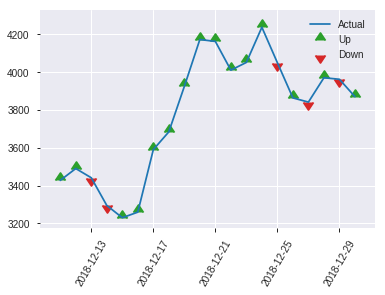


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.2576351968403014
RMSE: 0.5075777741787966
LogLoss: 0.7139739726300921
Mean Per-Class Error: 0.40706013949203845
AUC: 0.5648769574944071
pr_auc: 0.4329253080011496
Gini: 0.12975391498881428
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.21162789441535038: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      35   114  0.7651   (114.0/149.0)
1      5    97   0.049    (5.0/102.0)
Total  40   211  0.4741   (119.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.211628     0.619808  210
max f2                       0.205815     0.785256  215
max f0point5                 0.211628     0.512685  210
max accuracy                 0.452864     0.601594  27
max precision                0.706949     1         0
max recall                   0.11178      1         248
max specificity              0.706949     1         0
max absolute_mcc             0.211628     0.249433  210
max min_per_class_accuracy   0.262672     0.529412  123
max mean_per_class_accuracy  0.211628     0.59294   210

Gains/Lift Table: Avg response rate: 40.64 %, avg score: 29.61 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.664172           0.820261  0.820261           0.333333         0.684229  0.333333                    0.684229            0.00980392      0.00980392                 -17.9739  -17.9739
    2        0.0239044                   0.581329           0.820261  0.820261           0.333333         0.62318   0.333333                    0.653704            0.00980392      0.0196078                  -17.9739  -17.9739
    3        0.0318725                   0.55644            1.23039   0.922794           0.5              0.562057  0.375                       0.630792            0.00980392      0.0294118                  23.0392   -7.72059
    4        0.0438247                   0.53552            1.64052   1.11854            0.666667         0.541089  0.454545                    0.606328            0.0196078       0.0490196                  64.0523   11.8538
    5        0.0517928                   0.513167           1.23039   1.13575            0.5              0.521977  0.461538                    0.593351            0.00980392      0.0588235                  23.0392   13.5747
    6        0.103586                    0.459957           1.32504   1.23039            0.538462         0.485695  0.5                         0.539523            0.0686275       0.127451                   32.5038   23.0392
    7        0.151394                    0.425015           1.02533   1.16563            0.416667         0.437373  0.473684                    0.507265            0.0490196       0.176471                   2.53268   16.5635
    8        0.203187                    0.375172           0.757164  1.06151            0.307692         0.402949  0.431373                    0.480675            0.0392157       0.215686                   -24.2836  6.15148
    9        0.302789                    0.322842           0.590588  0.906605           0.24             0.343756  0.368421                    0.435636            0.0588235       0.27451                    -40.9412  -9.33953
    10       0.40239                     0.282003           1.27961   0.998932           0.52             0.29799   0.405941                    0.401565            0.127451        0.401961                   27.9608   -0.106775
    11       0.501992                    0.259122           1.27961   1.05462            0.52             0.269948  0.428571                    0.37545             0.127451        0.529412                   27.9608   5.46218
    12       0.601594                    0.245289           1.67333   1.15706            0.68             0.250913  0.470199                    0.354832            0.166667        0.696078                   67.3333   15.7058
    13       0.701195                    0.235465           0.885882  1.11854            0.36             0.240224  0.454545                    0.338552            0.0882353       0.784314                   -11.4118  11.8538
    14       0.800797                    0.218149           1.18118   1.12633            0.48             0.22832   0.457711                    0.324842            0.117647        0.901961                   18.1176   12.6329
    15       0.900398                    0.188647           0.68902   1.07795            0.28             0.205019  0.438053                    0.311587            0.0686275       0.970588                   -31.098   7.79542
    16       1                           0.0873382          0.295294  1                  0.12             0.156387  0.406375                    0.296129   

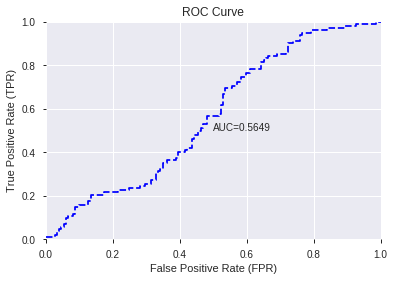

This function is available for GLM models only


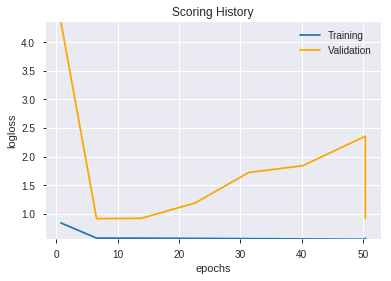

--2019-07-25 04:29:01--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.64.176
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.64.176|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_041604_model_9',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_041604_model_9',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_be36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BOP',
 'CDLCLOSINGMARUBOZU',
 'weekday_name',
 'ULTOSC',
 'TRANGE',
 'BETA_12',
 'CDLMORNINGDOJISTAR',
 'CDLTASUKIGAP',
 'Volume',
 'CDLHANGINGMAN',
 'CDLSTALLEDPATTERN',
 'BETA_8',
 'CDLUNIQUE3RIVER',
 'STOCHF_fastk',
 'CDLHAMMER',
 'SIN',
 'BETA_24',
 'CDLDARKCLOUDCOVER',
 'CDL3WHITESOLDIERS',
 'CDLMATCHINGLOW',
 'PLUS_DM_8',
 'CDLIDENTICAL3CROWS',
 'BBANDS_lowerband_20_3_5',
 'BETA_30',
 'is_quarter_start',
 'CDL3LINESTRIKE',
 'CDLEVENINGSTAR',
 'BBANDS_upperband_24_0_4',
 'ATAN',
 'days_in_month',
 'is_month_end',
 'WILLR_24',
 'CDLSHOOTINGSTAR',
 'WILLR_20',
 'BETA_14',
 'WILLR_14',
 'BBANDS_lowerband_20_5_5',
 'CDLGRAVESTONEDOJI',
 'TANH',
 'TAN',
 'VAR_8',
 'CDLDOJI',
 'Volume_(Currency)',
 'BBANDS_lowerband_20_1_5',
 'BBANDS_middleband_14_3_4',
 'LINEARREG_ANGLE_20',
 'BBANDS_lowerband_14_6_2',
 'BBANDS_middleband_30_0_2',
 'BBANDS_upperband_8_3_3',
 'BBANDS_upperband_12_2_2']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_042912_model_1  0.574681  0.689859              0.395907  0.497721  0.247727

variable  relative_importance  scaled_importance  percentage
0                        BOP             0.009632           1.000000    0.096217
1               STOCHF_fastk             0.007243           0.751929    0.072349
2                     ULTOSC             0.006130           0.636403    0.061233
3                   WILLR_14             0.006041           0.627146    0.060342
4         CDLCLOSINGMARUBOZU             0.006019           0.624867    0.060123
5                   WILLR_20             0.005424           0.563076    0.054178
6                   WILLR_24             0.005395           0.560108    0.053892
7   BBANDS_middleband_30_0_2             0.002932           0.304401    0.029289
8    BBANDS_lowerband_20_5_5             0.002922           0.303332    0.029186
9              CDLHANGINGMAN             0.002905           0.301576    0.029017
10   BBANDS_lowerband_20_1_5             0.002882           0.299161    0.028784
11   BBANDS_lowerband_14_6_2             0.002792           0.289806    0.027884
12   BBANDS_lowerband_20_3_5             0.002749           0.285442    0.027464
13  BBANDS_middleband_14_3_4             0.002540           0.263658    0.025369
14   BBANDS_upperband_12_2_2             0.002461           0.255513    0.024585
15   BBANDS_upperband_24_0_4             0.002383           0.247359    0.023800
16    BBANDS_upperband_8_3_3             0.002300           0.238810    0.022978
17        LINEARREG_ANGLE_20             0.002157           0.223938    0.021547
18                      ATAN             0.002073           0.215202    0.020706
19              weekday_name             0.001950           0.202442    0.019478
20         Volume_(Currency)             0.001809           0.187839    0.018073
21            CDLEVENINGSTAR             0.001728           0.179399    0.017261
22                    TRANGE             0.001714           0.177916    0.017119
23                    Volume             0.001634           0.169674    0.016326
24                   CDLDOJI             0.001534           0.159289    0.015326
25                 CDLHAMMER             0.001506           0.156350    0.015044
26         CDL3WHITESOLDIERS             0.001076           0.111689    0.010746
27            CDLMATCHINGLOW             0.001075           0.111591    0.010737
28         CDLGRAVESTONEDOJI             0.000936           0.097184    0.009351
29             days_in_month             0.000898           0.093273    0.008975
30         CDLSTALLEDPATTERN             0.000744           0.077276    0.007435
31              CDLTASUKIGAP             0.000631           0.065495    0.006302
32        CDLIDENTICAL3CROWS             0.000625           0.064906    0.006245
33                      TANH             0.000588           0.061068    0.005876
34                   BETA_30             0.000556           0.057751    0.005557
35                    BETA_8             0.000550           0.057104    0.005494
36                 PLUS_DM_8             0.000508           0.052714    0.005072
37                       TAN             0.000464           0.048168    0.004635
38           CDLSHOOTINGSTAR             0.000435           0.045176    0.004347
39                   BETA_12             0.000409           0.042493    0.004089
40        CDLMORNINGDOJISTAR             0.000396           0.041088    0.003953
41                       SIN             0.000395           0.041042    0.003949
42           CDLUNIQUE3RIVER             0.000293           0.030404    0.002925
43          is_quarter_start             0.000242           0.025089    0.002414
44                     VAR_8             0.000194           0.020190    0.001943
45                   BETA_24             0.000118           0.012248    0.001178
46                   BETA_14             0.000041           0.004250    0.000409
47         CDLDARKCLOUDCOVER             0.000036           0.003713    0.000357
48              is_month_end             0.000022  

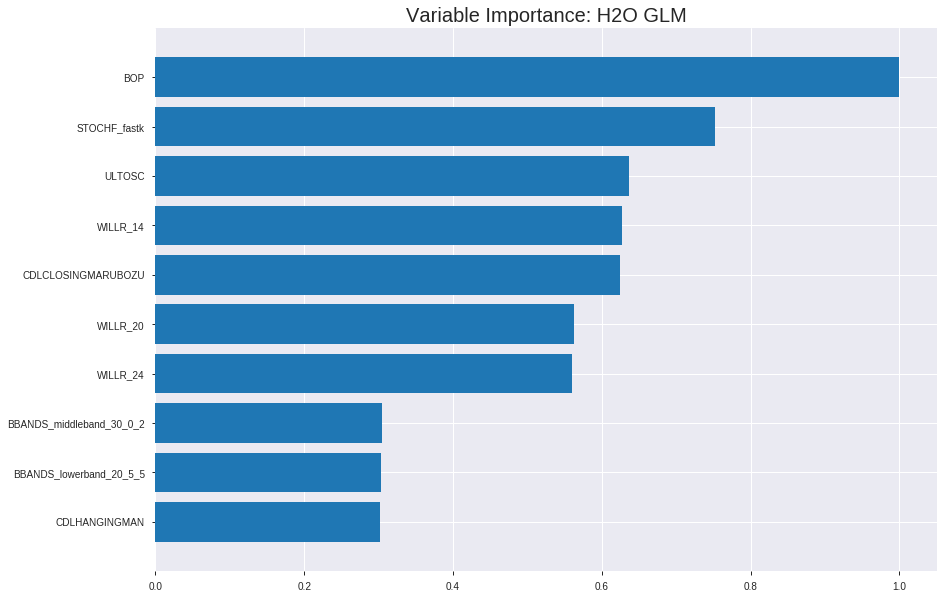

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_042912_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2446086753043282
RMSE: 0.49457929122065775
LogLoss: 0.6823234419261813
Null degrees of freedom: 1751
Residual degrees of freedom: 1701
Null deviance: 2421.1017340295916
Residual deviance: 2390.861340509339
AIC: 2492.861340509339
AUC: 0.7087362502159652
pr_auc: 0.6871140285410734
Gini: 0.4174725004319304
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4531381850283154: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      195  739   0.7912   (739.0/934.0)
1      43   775   0.0526   (43.0/818.0)
Total  238  1514  0.4463   (782.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.453138     0.664666  320
max f2                       0.448663     0.817239  349
max f0point5                 0.470115     0.643591  169
max accuracy                 0.470115     0.665525  169
max precision                0.497973     1         0
max recall                   0.432984     1         398
max specificity              0.497973     1         0
max absolute_mcc             0.46817      0.327343  186
max min_per_class_accuracy   0.467147     0.655246  196
max mean_per_class_accuracy  0.46817      0.663445  186

Gains/Lift Table: Avg response rate: 46.69 %, avg score: 46.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.492745           2.14181   2.14181            1                0.494671  1                           0.494671            0.0220049       0.0220049                  114.181   114.181
    2        0.0205479                   0.49038            1.78484   1.96333            0.833333         0.491528  0.916667                    0.493099            0.0183374       0.0403423                  78.4841   96.3325
    3        0.0302511                   0.488982           1.76384   1.89934            0.823529         0.48973   0.886792                    0.492019            0.0171149       0.0574572                  76.3843   89.934
    4        0.0405251                   0.487858           2.02282   1.93064            0.944444         0.488418  0.901408                    0.491106            0.0207824       0.0782396                  102.282   93.0645
    5        0.0502283                   0.486787           1.63785   1.87408            0.764706         0.487221  0.875                       0.490355            0.0158924       0.094132                   63.7854   87.4083
    6        0.100457                    0.483506           1.67937   1.77673            0.784091         0.484981  0.829545                    0.487668            0.0843521       0.178484                   67.9373   77.6728
    7        0.150114                    0.480467           1.50173   1.68576            0.701149         0.482025  0.787072                    0.485801            0.0745721       0.253056                   50.1728   68.5759
    8        0.200342                    0.477966           1.21694   1.56822            0.568182         0.479096  0.732194                    0.48412             0.0611247       0.314181                   21.6937   56.8219
    9        0.300228                    0.473677           1.26061   1.46588            0.588571         0.475899  0.684411                    0.481385            0.125917        0.440098                   26.0608   46.5877
    10       0.400114                    0.470383           1.27285   1.41769            0.594286         0.472025  0.661912                    0.479048            0.127139        0.567237                   27.2847   41.7688
    11       0.5                         0.466774           0.966874  1.32763            0.451429         0.468551  0.619863                    0.476951            0.096577        0.663814                   -3.31261  32.7628
    12       0.599886                    0.463204           0.807768  1.24107            0.377143         0.46502   0.579448                    0.474965            0.0806846       0.744499                   -19.2232  24.1067
    13       0.699772                    0.459511           0.844485  1.18446            0.394286         0.461465  0.553018                    0.473038            0.0843521       0.828851                   -15.5515  18.4459
    14       0.799658                    0.455908           0.636423  1.116              0.297143         0.45771   0.521056                    0.471123            0.0635697       0.892421                   -36.3577  11.6003
    15       0.899543                    0.451316           0.722096  1.07226            0.337143         0.453735  0.500635                    0.469192            0.0721271       0.964548                   -27.7904  7.22637
    16       1                           0.431128           0.352912  1                  0.164773         0.446323  0.466895                    0.466895          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.2752374922478025
RMSE: 0.5246308151908373
LogLoss: 0.7473907856921185
Null degrees of freedom: 499
Residual degrees of freedom: 449
Null deviance: 702.7702737716033
Residual deviance: 747.3907856921185
AIC: 849.3907856921185
AUC: 0.595955667898114
pr_auc: 0.6627649774963459
Gini: 0.1919113357962281
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23840277923472894: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      32   190  0.8559   (190.0/222.0)
1      12   266  0.0432   (12.0/278.0)
Total  44   456  0.404    (202.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.238403     0.724796  356
max f2                       0.173548     0.865504  393
max f0point5                 0.284958     0.638743  319
max accuracy                 0.284958     0.604     319
max precision                0.474022     1         0
max recall                   0.173548     1         393
max specificity              0.474022     1         0
max absolute_mcc             0.457534     0.19477   33
max min_per_class_accuracy   0.396376     0.532374  183
max mean_per_class_accuracy  0.446972     0.576739  77

Gains/Lift Table: Avg response rate: 55.60 %, avg score: 37.06 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.46745            1.79856   1.79856            1                0.469257  1                           0.469257            0.0179856       0.0179856                  79.8561   79.8561
    2        0.02                        0.466215           1.43885   1.61871            0.8              0.466995  0.9                         0.468126            0.0143885       0.0323741                  43.8849   61.8705
    3        0.03                        0.464676           1.79856   1.67866            1                0.465477  0.933333                    0.467243            0.0179856       0.0503597                  79.8561   67.8657
    4        0.04                        0.464184           1.43885   1.61871            0.8              0.464538  0.9                         0.466567            0.0143885       0.0647482                  43.8849   61.8705
    5        0.05                        0.462626           1.43885   1.58273            0.8              0.46381   0.88                        0.466016            0.0143885       0.0791367                  43.8849   58.2734
    6        0.1                         0.457566           1.43885   1.51079            0.8              0.460248  0.84                        0.463132            0.0719424       0.151079                   43.8849   51.0791
    7        0.15                        0.454525           0.935252  1.31894            0.52             0.456012  0.733333                    0.460758            0.0467626       0.197842                   -6.47482  31.8945
    8        0.2                         0.450602           1.15108   1.27698            0.64             0.452336  0.71                        0.458653            0.057554        0.255396                   15.1079   27.6978
    9        0.3                         0.438622           1.00719   1.18705            0.56             0.446106  0.66                        0.454471            0.100719        0.356115                   0.719424  18.705
    10       0.4                         0.416052           0.935252  1.1241             0.52             0.426461  0.625                       0.447468            0.0935252       0.44964                    -6.47482  12.4101
    11       0.5                         0.396689           0.791367  1.05755            0.44             0.408139  0.588                       0.439602            0.0791367       0.528777                   -20.8633  5.7554
    12       0.6                         0.369589           1.11511   1.06715            0.62             0.383988  0.593333                    0.430333            0.111511        0.640288                   11.5108   6.71463
    13       0.7                         0.31817            1.07914   1.06886            0.6              0.341842  0.594286                    0.417692            0.107914        0.748201                   7.91367   6.88592
    14       0.8                         0.29328            1.07914   1.07014            0.6              0.306185  0.595                       0.403753            0.107914        0.856115                   7.91367   7.01439
    15       0.9                         0.24664            0.827338  1.04317            0.46             0.268864  0.58                        0.388766            0.0827338       0.938849                   -17.2662  4.31655
    16       1                           0.166549           0.611511  1                  0.34             0.207425  0.556                       0.370631           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 04:29:13  0.000 sec   2            20        51            1.36465           1.49478
    2019-07-25 04:29:13  0.016 sec   4            12        51            1.35567           1.57982
    2019-07-25 04:29:13  0.027 sec   6            7.6       51            1.3431            1.71589
    2019-07-25 04:29:13  0.038 sec   8            4.7       51            1.32652           1.88921
    2019-07-25 04:29:13  0.048 sec   10           2.9       51            1.30613           2.06226

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6095617529880478)

('F1', 0.5891472868217054)

('auc', 0.5746808790630346)

('logloss', 0.6898586195034314)

('mean_per_class_error', 0.3959073562310831)

('rmse', 0.49772139950890304)

('mse', 0.2477265915291011)

glm prediction progress: |████████████████████████████████████████████████| 100%


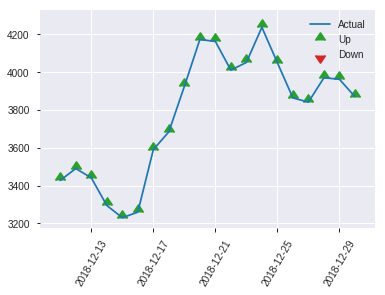


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2477265915291011
RMSE: 0.49772139950890304
LogLoss: 0.6898586195034314
Null degrees of freedom: 250
Residual degrees of freedom: 200
Null deviance: 342.8297670320054
Residual deviance: 346.30902699072266
AIC: 448.30902699072266
AUC: 0.5746808790630346
pr_auc: 0.4649355255015477
Gini: 0.1493617581260691
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31403942282069: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      69   80   0.5369   (80.0/149.0)
1      26   76   0.2549   (26.0/102.0)
Total  95   156  0.4223   (106.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.314039     0.589147  155
max f2                       0.25686      0.776256  248
max f0point5                 0.315963     0.523599  143
max accuracy                 0.387819     0.609562  11
max precision                0.400842     1         0
max recall                   0.25686      1         248
max specificity              0.400842     1         0
max absolute_mcc             0.314039     0.210824  155
max min_per_class_accuracy   0.318803     0.568627  119
max mean_per_class_accuracy  0.314039     0.604093  155

Gains/Lift Table: Avg response rate: 40.64 %, avg score: 31.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.392408           2.46078   2.46078            1                0.396195  1                           0.396195            0.0294118       0.0294118                  146.078   146.078
    2        0.0239044                   0.390457           0.820261  1.64052            0.333333         0.391552  0.666667                    0.393874            0.00980392      0.0392157                  -17.9739  64.0523
    3        0.0318725                   0.390081           1.23039   1.53799            0.5              0.390183  0.625                       0.392951            0.00980392      0.0490196                  23.0392   53.799
    4        0.0438247                   0.388375           1.64052   1.56595            0.666667         0.389278  0.636364                    0.391949            0.0196078       0.0686275                  64.0523   56.5954
    5        0.0517928                   0.387039           1.23039   1.51433            0.5              0.387632  0.615385                    0.391285            0.00980392      0.0784314                  23.0392   51.4329
    6        0.103586                    0.376898           0.567873  1.0411             0.230769         0.381373  0.423077                    0.386329            0.0294118       0.107843                   -43.2127  4.11011
    7        0.151394                    0.359419           0.615196  0.906605           0.25             0.370224  0.368421                    0.381243            0.0294118       0.137255                   -38.4804  -9.33953
    8        0.203187                    0.328085           1.51433   1.06151            0.615385         0.334642  0.431373                    0.369365            0.0784314       0.215686                   51.4329   6.15148
    9        0.302789                    0.323606           1.37804   1.16563            0.56             0.325347  0.473684                    0.354885            0.137255        0.352941                   37.8039   16.5635
    10       0.40239                     0.321183           0.984314  1.12075            0.4              0.322391  0.455446                    0.346842            0.0980392       0.45098                    -1.56863  12.0753
    11       0.501992                    0.318166           1.37804   1.1718             0.56             0.319591  0.47619                     0.341435            0.137255        0.588235                   37.8039   17.1802
    12       0.601594                    0.314736           1.27961   1.18965            0.52             0.316592  0.483444                    0.337322            0.127451        0.715686                   27.9608   18.9651
    13       0.701195                    0.30801            0.492157  1.09057            0.2              0.312086  0.443182                    0.333737            0.0490196       0.764706                   -50.7843  9.05749
    14       0.800797                    0.297192           0.68902   1.04063            0.28             0.30246   0.422886                    0.329847            0.0686275       0.833333                   -31.098   4.06302
    15       0.900398                    0.281878           0.885882  1.02351            0.36             0.290348  0.415929                    0.325478            0.0882353       0.921569                   -11.4118  2.35121
    16       1                           0.244612           0.787451  1                  0.32             0.267902  0.406375                    0.319743         

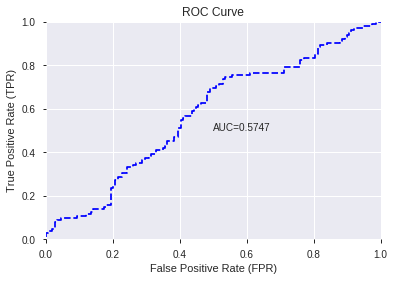

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


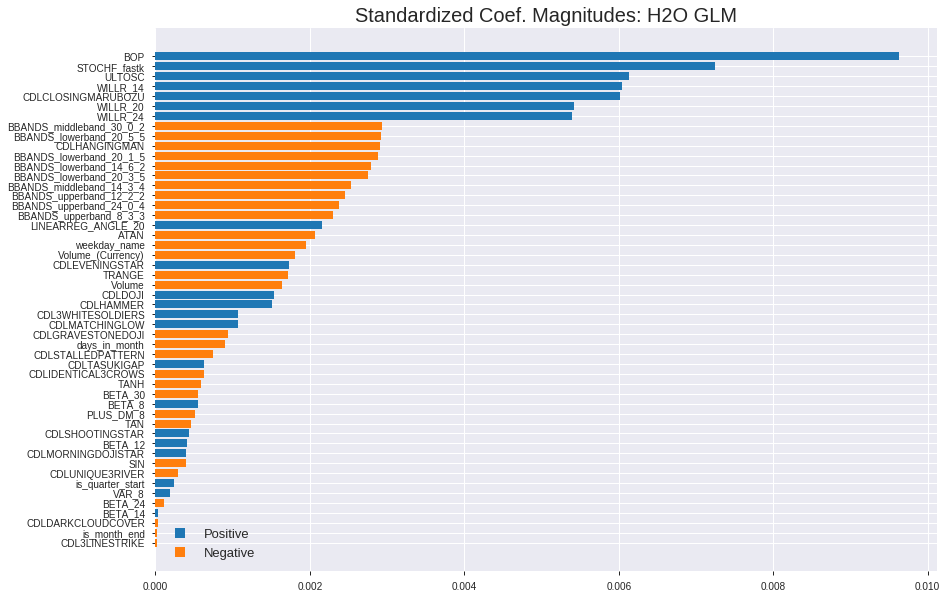

'log_likelihood'
--2019-07-25 04:29:20--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.185.115
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.185.115|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_042912_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_042912_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_be36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['BOP',
 'STOCHF_fastk',
 'ULTOSC',
 'WILLR_14',
 'CDLCLOSINGMARUBOZU',
 'WILLR_20',
 'WILLR_24',
 'BBANDS_middleband_30_0_2',
 'BBANDS_lowerband_20_5_5',
 'CDLHANGINGMAN',
 'BBANDS_lowerband_20_1_5',
 'BBANDS_lowerband_14_6_2',
 'BBANDS_lowerband_20_3_5',
 'BBANDS_middleband_14_3_4',
 'BBANDS_upperband_12_2_2',
 'BBANDS_upperband_24_0_4',
 'BBANDS_upperband_8_3_3',
 'LINEARREG_ANGLE_20',
 'ATAN',
 'weekday_name',
 'Volume_(Currency)',
 'CDLEVENINGSTAR',
 'TRANGE',
 'Volume',
 'CDLDOJI',
 'CDLHAMMER',
 'CDL3WHITESOLDIERS',
 'CDLMATCHINGLOW',
 'CDLGRAVESTONEDOJI',
 'days_in_month',
 'CDLSTALLEDPATTERN',
 'CDLTASUKIGAP',
 'CDLIDENTICAL3CROWS',
 'TANH',
 'BETA_30',
 'BETA_8',
 'PLUS_DM_8',
 'TAN',
 'CDLSHOOTINGSTAR',
 'BETA_12',
 'CDLMORNINGDOJISTAR',
 'SIN',
 'CDLUNIQUE3RIVER',
 'is_quarter_start',
 'VAR_8',
 'BETA_24',
 'BETA_14',
 'CDLDARKCLOUDCOVER',
 'is_month_end',
 'CDL3LINESTRIKE']

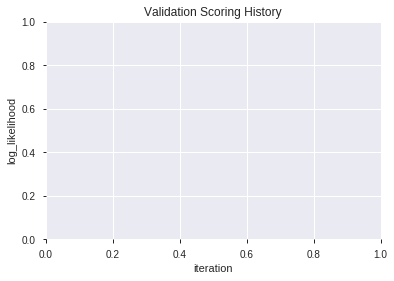

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_042925_model_2  0.747335  0.610800              0.310765  0.460466  0.212029
1  XGBoost_grid_1_AutoML_20190725_042925_model_7  0.737860  0.606822              0.299908  0.457961  0.209728
2  XGBoost_grid_1_AutoML_20190725_042925_model_3  0.734439  0.618460              0.285959  0.464447  0.215711
3  XGBoost_grid_1_AutoML_20190725_042925_model_1  0.734044  0.610070              0.309218  0.460021  0.211619
4               XGBoost_1_AutoML_20190725_042925  0.733254  0.604766              0.283886  0.457201  0.209033
5  XGBoost_grid_1_AutoML_20190725_042925_model_6  0.730820  0.611909              0.306882  0.460728  0.212270
6               XGBoost_3_AutoML_20190725_042925  0.730557  0.607347              0.306356  0.458970  0.210654
7               XGBoost_2_AutoML_20190725_042925  0.727793  0.610933              0.288525  0.459341  0.210994
8  XGBoost_grid_1_AutoML_20190725_042925_model_5  0.719239  0.612279              0.325734  0.461172  0.212679
9  XGBoost_grid_1_AutoML_20190725_042925_model_4  0.718647  0.623081              0.323661  0.466486  0.217610

variable  relative_importance  scaled_importance  percentage
0                        BOP          2423.297119           1.000000    0.299342
1               STOCHF_fastk          1039.730347           0.429056    0.128434
2                     TRANGE           628.476135           0.259348    0.077633
3               weekday_name           313.901306           0.129535    0.038775
4                     ULTOSC           308.266022           0.127209    0.038079
5                   WILLR_14           231.964722           0.095723    0.028654
6                        SIN           231.093338           0.095363    0.028546
7                     Volume           202.608994           0.083609    0.025028
8                      VAR_8           192.357727           0.079379    0.023761
9                     BETA_8           180.059357           0.074303    0.022242
10                   BETA_14           153.852280           0.063489    0.019005
11                   BETA_30           152.211731           0.062812    0.018802
12                   BETA_24           142.244888           0.058699    0.017571
13        LINEARREG_ANGLE_20           142.003662           0.058599    0.017541
14                  WILLR_20           141.481094           0.058384    0.017477
15                       TAN           137.750443           0.056844    0.017016
16                  WILLR_24           136.052094           0.056143    0.016806
17                 CDLHAMMER           133.277634           0.054998    0.016463
18   BBANDS_lowerband_20_1_5           125.821106           0.051921    0.015542
19                   BETA_12           113.920433           0.047011    0.014072
20   BBANDS_lowerband_20_3_5            99.706665           0.041145    0.012316
21        CDLCLOSINGMARUBOZU            98.417343           0.040613    0.012157
22                 PLUS_DM_8            84.811989           0.034999    0.010477
23   BBANDS_lowerband_20_5_5            84.349968           0.034808    0.010419
24         Volume_(Currency)            83.177910           0.034324    0.010275
25    BBANDS_upperband_8_3_3            78.111313           0.032233    0.009649
26                   CDLDOJI            72.962646           0.030109    0.009013
27  BBANDS_middleband_30_0_2            55.734917           0.023000    0.006885
28   BBANDS_lowerband_14_6_2            54.047890           0.022303    0.006676
29   BBANDS_upperband_12_2_2            46.655022           0.019253    0.005763
30   BBANDS_upperband_24_0_4            34.927505           0.014413    0.004314
31  BBANDS_middleband_14_3_4            33.555801           0.013847    0.004145
32                      ATAN            31.823347           0.013132    0.003931
33                      TANH            29.255013           0.012072    0.003614
34             CDLHANGINGMAN            27.086189           0.011177    0.003346
35            CDLMATCHINGLOW            22.686028           0.009362    0.002802
36             days_in_month            13.958229           0.005760    0.001724
37              is_month_end             9.721584           0.004012    0.001201
38            CDL3LINESTRIKE             2.319798           0.000957    0.000287
39        CDLIDENTICAL3CROWS             1.746788           0.000721    0.000216

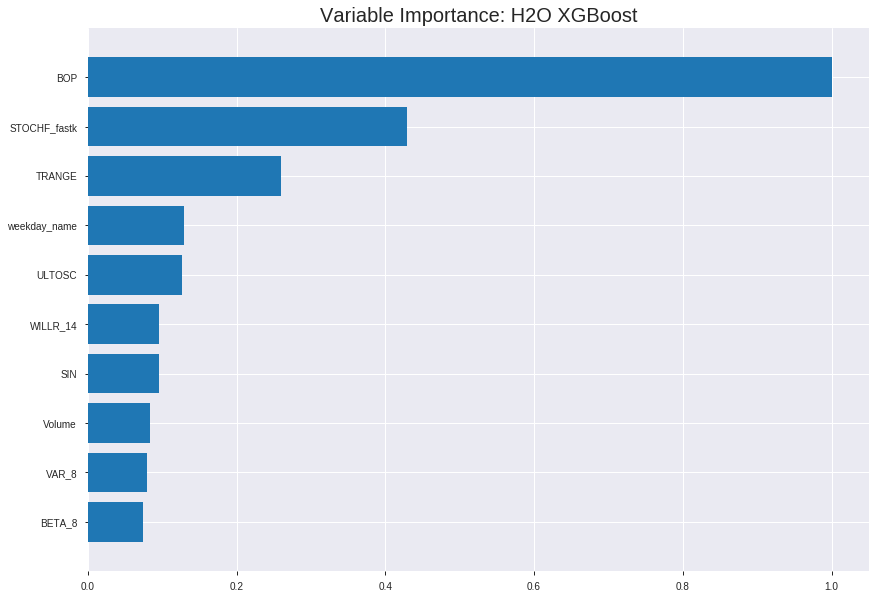

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_042925_model_2


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.15545029916493067
RMSE: 0.3942718594636582
LogLoss: 0.4817605589582705
Mean Per-Class Error: 0.1946867326691204
AUC: 0.8843977581503955
pr_auc: 0.8683774257640647
Gini: 0.7687955163007909
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45347123060907635: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      706  228  0.2441   (228.0/934.0)
1      129  689  0.1577   (129.0/818.0)
Total  835  917  0.2038   (357.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.453471     0.794236  218
max f2                       0.362096     0.866547  271
max f0point5                 0.527326     0.81899   172
max accuracy                 0.503938     0.806507  187
max precision                0.909892     1         0
max recall                   0.12425      1         385
max specificity              0.909892     1         0
max absolute_mcc             0.503938     0.611657  187
max min_per_class_accuracy   0.478874     0.799511  203
max mean_per_class_accuracy  0.4855       0.805313  199

Gains/Lift Table: Avg response rate: 46.69 %, avg score: 46.36 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.899317           2.14181    2.14181            1                0.904884  1                           0.904884            0.0220049       0.0220049                  114.181   114.181
    2        0.0205479                   0.892856           2.02282    2.08231            0.944444         0.895568  0.972222                    0.900226            0.0207824       0.0427873                  102.282   108.231
    3        0.0302511                   0.883047           2.14181    2.1014             1                0.888851  0.981132                    0.896578            0.0207824       0.0635697                  114.181   110.14
    4        0.0405251                   0.870476           2.14181    2.11164            1                0.877058  0.985915                    0.891629            0.0220049       0.0855746                  114.181   111.164
    5        0.0502283                   0.855714           2.01582    2.09313            0.941176         0.863711  0.977273                    0.886236            0.0195599       0.105134                   101.582   109.313
    6        0.100457                    0.76824            2.06879    2.08096            0.965909         0.812059  0.971591                    0.849147            0.103912        0.209046                   106.879   108.096
    7        0.150114                    0.697327           1.96948    2.04408            0.91954          0.731261  0.954373                    0.81015             0.0977995       0.306846                   96.948    104.408
    8        0.200342                    0.651367           1.82541    1.98926            0.852273         0.673062  0.928775                    0.775781            0.091687        0.398533                   82.5406   98.9259
    9        0.300228                    0.575893           1.66449    1.88121            0.777143         0.611267  0.878327                    0.721047            0.166259        0.564792                   66.4492   88.1209
    10       0.400114                    0.516556           1.51762    1.79044            0.708571         0.543941  0.835949                    0.676834            0.151589        0.716381                   51.7625   79.0443
    11       0.5                         0.46419            1.02807    1.63814            0.48             0.489848  0.76484                     0.639479            0.102689        0.819071                   2.80685   63.8142
    12       0.599886                    0.412101           0.771051   1.49376            0.36             0.438183  0.697431                    0.605962            0.0770171       0.896088                   -22.8949  49.3764
    13       0.699772                    0.34868            0.538512   1.35741            0.251429         0.382037  0.633768                    0.573999            0.0537897       0.949878                   -46.1488  35.7411
    14       0.799658                    0.245991           0.293734   1.22455            0.137143         0.305078  0.571734                    0.540408            0.0293399       0.979218                   -70.6266  22.4546
    15       0.899543                    0.145564           0.183584   1.10896            0.0857143        0.188697  0.517766                    0.501354            0.0183374       0.997555                   -81.6416  10.8957
    16       1                           0.095402           0.0243387  1                  0.0113636        0.125047  0.466895                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20940858842160867
RMSE: 0.4576118316014225
LogLoss: 0.6030076018013061
Mean Per-Class Error: 0.2935381424590058
AUC: 0.7791739581307927
pr_auc: 0.8047363875465875
Gini: 0.5583479162615854
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.32716184854507446: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      104  118  0.5315   (118.0/222.0)
1      25   253  0.0899   (25.0/278.0)
Total  129  371  0.286    (143.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.327162     0.779661  290
max f2                       0.179        0.877473  360
max f0point5                 0.446791     0.735294  160
max accuracy                 0.370496     0.72      245
max precision                0.874765     1         0
max recall                   0.124833     1         392
max specificity              0.874765     1         0
max absolute_mcc             0.333258     0.430729  283
max min_per_class_accuracy   0.410434     0.689189  202
max mean_per_class_accuracy  0.370496     0.706462  245

Gains/Lift Table: Avg response rate: 55.60 %, avg score: 43.23 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.820144           1.79856   1.79856            1                0.8528    1                           0.8528              0.0179856       0.0179856                  79.8561   79.8561
    2        0.02                        0.808988           1.43885   1.61871            0.8              0.814212  0.9                         0.833506            0.0143885       0.0323741                  43.8849   61.8705
    3        0.03                        0.805537           1.79856   1.67866            1                0.807423  0.933333                    0.824812            0.0179856       0.0503597                  79.8561   67.8657
    4        0.04                        0.802515           1.79856   1.70863            1                0.80439   0.95                        0.819706            0.0179856       0.0683453                  79.8561   70.8633
    5        0.05                        0.797158           1.79856   1.72662            1                0.801093  0.96                        0.815984            0.0179856       0.0863309                  79.8561   72.6619
    6        0.1                         0.722506           1.65468   1.69065            0.92             0.762837  0.94                        0.78941             0.0827338       0.169065                   65.4676   69.0647
    7        0.15                        0.625098           1.58273   1.65468            0.88             0.666805  0.92                        0.748542            0.0791367       0.248201                   58.2734   65.4676
    8        0.2                         0.565025           1.29496   1.56475            0.72             0.590576  0.87                        0.70905             0.0647482       0.31295                    29.4964   56.4748
    9        0.3                         0.494563           1.40288   1.51079            0.78             0.523846  0.84                        0.647316            0.140288        0.453237                   40.2878   51.0791
    10       0.4                         0.439581           1.11511   1.41187            0.62             0.466217  0.785                       0.602041            0.111511        0.564748                   11.5108   41.1871
    11       0.5                         0.41513            1.04317   1.33813            0.58             0.428694  0.744                       0.567372            0.104317        0.669065                   4.31655   33.8129
    12       0.6                         0.388936           1.00719   1.28297            0.56             0.403635  0.713333                    0.540082            0.100719        0.769784                   0.719424  28.2974
    13       0.7                         0.347257           1.00719   1.24358            0.56             0.368191  0.691429                    0.515526            0.100719        0.870504                   0.719424  24.3577
    14       0.8                         0.294121           0.647482  1.16906            0.36             0.323574  0.65                        0.491532            0.0647482       0.935252                   -35.2518  16.9065
    15       0.9                         0.184656           0.467626  1.09113            0.26             0.243169  0.606667                    0.463936            0.0467626       0.982014                   -53.2374  9.11271
    16       1                           0.114321           0.179856  1                  0.1              0.147101  0.556                       0.432253         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:29:30  0.658 sec   0                  0.5              0.693147            0.5             0                  1                0.533105                         0.5                0.693147              0.5               0                    1                  0.444
    2019-07-25 04:29:30  0.726 sec   5                  0.47794          0.649779            0.811772        0.640155           1.98991          0.287671                         0.486649           0.666677              0.774913          0.78175              1.79856            0.282
    2019-07-25 04:29:30  0.773 sec   10                 0.461306         0.617538            0.82033         0.735149           2.06921          0.296233                         0.477021           0.647581              0.777319          0.789827             1.79856            0.278
    2019-07-25 04:29:30  0.828 sec   15                 0.449081         0.59376             0.831613        0.748814           2.06532          0.273973                         0.470706           0.63475               0.780357          0.796148             1.79856            0.282
    2019-07-25 04:29:30  0.883 sec   20                 0.439065         0.573923            0.836423        0.76907            2.04445          0.264269                         0.465708           0.624421              0.776598          0.793922             1.79856            0.284
    2019-07-25 04:29:30  0.936 sec   25                 0.431541         0.558612            0.842561        0.789216           2.012            0.257991                         0.462837           0.617906              0.775188          0.799685             1.79856            0.284
    2019-07-25 04:29:30  0.989 sec   30                 0.42522          0.545775            0.847726        0.8103             2.02908          0.244863                         0.461285           0.614339              0.775366          0.796766             1.79856            0.284
    2019-07-25 04:29:30  1.048 sec   35                 0.418994         0.533107            0.85474         0.832688           2.02282          0.238014                         0.459036           0.609401              0.77778           0.799256             1.79856            0.278
    2019-07-25 04:29:30  1.111 sec   40                 0.413379         0.521424            0.860701        0.838979           2.02282          0.255137                         0.456559           0.603544              0.778736          0.800055             1.79856            0.278
    2019-07-25 04:29:30  1.174 sec   45                 0.409592         0.513177            0.86459         0.844483           2.02282          0.215183                         0.457072           0.603932              0.779125          0.800331             1.79856            0.278
    2019-07-25 04:29:30  1.235 sec   50                 0.405086         0.503876            0.869914        0.851326           2.14181          0.223174                         0.457611           0.604474              0.779733          0.804309             1.79856            0.278
    2019-07-25 04:29:30  1.295 sec   55                 0.401655         0.496661            0.874207        0.854595           2.02282          0.218037                         0.457328           0.603271              0.781288          0.806427             1.79856      

Variable Importances: 


variable            relative_importance    scaled_importance      percentage
------------------  ---------------------  ---------------------  ----------------------
BOP                 2423.297119140625      1.0                    0.2993415055682754
STOCHF_fastk        1039.7303466796875     0.42905607342462715    0.1284342909921404
TRANGE              628.4761352539062      0.25934753534340976    0.07763348169511779
weekday_name        313.90130615234375     0.1295347993743593     0.03877514186820521
ULTOSC              308.2660217285156      0.12720933776285598    0.03807903468827658
---                 ---                    ---                    ---
CDLMATCHINGLOW      22.68602752685547      0.009361636816083298   0.00280232645910977
days_in_month       13.958229064941406     0.005760015540269952   0.0017242117239210707
is_month_end        9.72158432006836       0.004011717854687142   0.0012008736625371808
CDL3LINESTRIKE      2.3197975158691406     0.0009572897592895301  0.00028655655781081987
CDLIDENTICAL3CROWS  1.7467880249023438     0.0007208311399808077  0.00021577467870235122


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7091633466135459)

('F1', 0.6764705882352942)

('auc', 0.7473351756810107)

('logloss', 0.6108000980977077)

('mean_per_class_error', 0.30145413870246085)

('rmse', 0.46046625756854687)

('mse', 0.21202917435918336)

xgboost prediction progress: |████████████████████████████████████████████| 100%


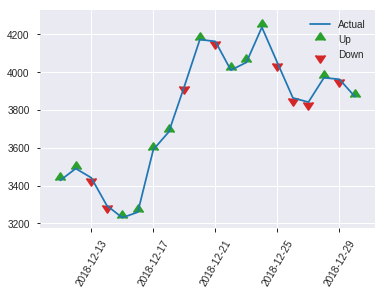


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.21202917435918336
RMSE: 0.46046625756854687
LogLoss: 0.6108000980977077
Mean Per-Class Error: 0.30145413870246085
AUC: 0.7473351756810107
pr_auc: 0.6208623398368904
Gini: 0.4946703513620214
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3092087209224701: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      71   78   0.5235   (78.0/149.0)
1      10   92   0.098    (10.0/102.0)
Total  81   170  0.3506   (88.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.309209     0.676471  169
max f2                       0.292852     0.798969  173
max f0point5                 0.394988     0.642857  96
max accuracy                 0.394988     0.709163  96
max precision                0.777453     1         0
max recall                   0.115564     1         248
max specificity              0.777453     1         0
max absolute_mcc             0.34289      0.39772   149
max min_per_class_accuracy   0.378953     0.684564  116
max mean_per_class_accuracy  0.34289      0.698546  149

Gains/Lift Table: Avg response rate: 40.64 %, avg score: 35.41 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.739168           1.64052   1.64052            0.666667         0.758304  0.666667                    0.758304            0.0196078       0.0196078                  64.0523   64.0523
    2        0.0239044                   0.71383            1.64052   1.64052            0.666667         0.725528  0.666667                    0.741916            0.0196078       0.0392157                  64.0523   64.0523
    3        0.0318725                   0.681401           1.23039   1.53799            0.5              0.709097  0.625                       0.733711            0.00980392      0.0490196                  23.0392   53.799
    4        0.0438247                   0.576061           1.64052   1.56595            0.666667         0.609994  0.636364                    0.69997             0.0196078       0.0686275                  64.0523   56.5954
    5        0.0517928                   0.555889           1.23039   1.51433            0.5              0.563194  0.615385                    0.678928            0.00980392      0.0784314                  23.0392   51.4329
    6        0.103586                    0.491556           1.89291   1.70362            0.769231         0.521176  0.692308                    0.600052            0.0980392       0.176471                   89.2911   70.362
    7        0.151394                    0.456405           1.64052   1.68369            0.666667         0.473978  0.684211                    0.560239            0.0784314       0.254902                   64.0523   68.3695
    8        0.203187                    0.436728           1.70362   1.68877            0.692308         0.445833  0.686275                    0.531077            0.0882353       0.343137                   70.362    68.8774
    9        0.302789                    0.410039           1.5749    1.65132            0.64             0.425211  0.671053                    0.496253            0.156863        0.5                        57.4902   65.1316
    10       0.40239                     0.392993           1.27961   1.55931            0.52             0.399893  0.633663                    0.472401            0.127451        0.627451                   27.9608   55.9309
    11       0.501992                    0.372911           1.08275   1.46475            0.44             0.38131   0.595238                    0.454327            0.107843        0.735294                   8.27451   46.4753
    12       0.601594                    0.342853           0.984314  1.38521            0.4              0.357208  0.562914                    0.438248            0.0980392       0.833333                   -1.56863  38.521
    13       0.701195                    0.291865           0.787451  1.3003             0.32             0.319782  0.528409                    0.421421            0.0784314       0.911765                   -21.2549  30.0301
    14       0.800797                    0.237239           0.196863  1.16306            0.08             0.258536  0.472637                    0.401161            0.0196078       0.931373                   -80.3137  16.3057
    15       0.900398                    0.173844           0.295294  1.06707            0.12             0.197895  0.433628                    0.378676            0.0294118       0.960784                   -70.4706  6.70658
    16       1                           0.115056           0.393725  1                  0.16             0.131654  0.406375                    0.354072            

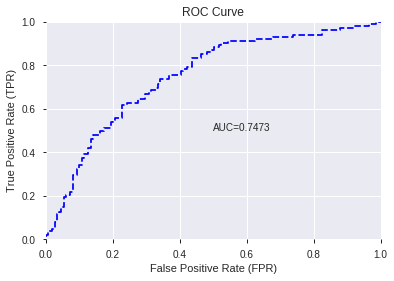

This function is available for GLM models only


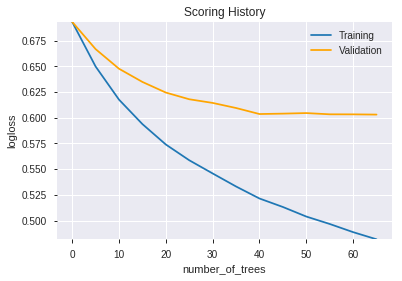

--2019-07-25 04:29:42--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.227.32
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.227.32|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMode

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_042925_model_2',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_042925_model_2',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_be36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'weekday_name',
 'ULTOSC',
 'WILLR_14',
 'SIN',
 'Volume',
 'VAR_8',
 'BETA_8',
 'BETA_14',
 'BETA_30',
 'BETA_24',
 'LINEARREG_ANGLE_20',
 'WILLR_20',
 'TAN',
 'WILLR_24',
 'CDLHAMMER',
 'BBANDS_lowerband_20_1_5',
 'BETA_12',
 'BBANDS_lowerband_20_3_5',
 'CDLCLOSINGMARUBOZU',
 'PLUS_DM_8',
 'BBANDS_lowerband_20_5_5',
 'Volume_(Currency)',
 'BBANDS_upperband_8_3_3',
 'CDLDOJI',
 'BBANDS_middleband_30_0_2',
 'BBANDS_lowerband_14_6_2',
 'BBANDS_upperband_12_2_2',
 'BBANDS_upperband_24_0_4',
 'BBANDS_middleband_14_3_4',
 'ATAN',
 'TANH',
 'CDLHANGINGMAN',
 'CDLMATCHINGLOW',
 'days_in_month',
 'is_month_end',
 'CDL3LINESTRIKE',
 'CDLIDENTICAL3CROWS']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

879

['Open',
 'High',
 'Low',
 'Close',
 'Weighted_Price',
 'mama',
 'fama',
 'DEMA_8',
 'EMA_8',
 'KAMA_8',
 'MIDPOINT_8',
 'MIDPRICE_8',
 'SAR_0.08',
 'SMA_8',
 'TEMA_8',
 'TRIMA_8',
 'WMA_8',
 'MA_8_0',
 'MAVP_8_0',
 'T3_8_0',
 'BBANDS_upperband_8_0_2',
 'BBANDS_middleband_8_0_2',
 'BBANDS_lowerband_8_0_2',
 'BBANDS_upperband_8_0_3',
 'BBANDS_middleband_8_0_3',
 'BBANDS_lowerband_8_0_3',
 'BBANDS_upperband_8_0_4',
 'BBANDS_middleband_8_0_4',
 'BBANDS_lowerband_8_0_4',
 'BBANDS_upperband_8_0_5',
 'BBANDS_middleband_8_0_5',
 'BBANDS_lowerband_8_0_5',
 'MA_8_1',
 'MAVP_8_1',
 'T3_8_1',
 'BBANDS_upperband_8_1_2',
 'BBANDS_middleband_8_1_2',
 'BBANDS_lowerband_8_1_2',
 'BBANDS_upperband_8_1_3',
 'BBANDS_middleband_8_1_3',
 'BBANDS_lowerband_8_1_3',
 'BBANDS_upperband_8_1_4',
 'BBANDS_middleband_8_1_4',
 'BBANDS_lowerband_8_1_4',
 'BBANDS_upperband_8_1_5',
 'BBANDS_middleband_8_1_5',
 'BBANDS_lowerband_8_1_5',
 'MA_8_2',
 'MAVP_8_2',
 'T3_8_2',
 'BBANDS_upperband_8_2_2',
 'BBANDS_middleband_8

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc    logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_042949_model_3  0.595868   4.372403              0.476510  0.737313  0.543631
1  DeepLearning_grid_1_AutoML_20190725_042949_model_2  0.572444   1.593164              0.433906  0.594514  0.353446
2  DeepLearning_grid_1_AutoML_20190725_042949_model_5  0.537077   0.679997              0.469009  0.492659  0.242713
3  DeepLearning_grid_1_AutoML_20190725_042949_model_9  0.530333   0.686684              0.454566  0.496719  0.246730
4  DeepLearning_grid_1_AutoML_20190725_042949_model_6  0.521516   0.871294              0.491479  0.552615  0.305383
5  DeepLearning_grid_1_AutoML_20190725_042949_model_4  0.514344   5.990823              0.489933  0.757643  0.574023
6  DeepLearning_grid_1_AutoML_20190725_042949_model_8  0.504902   0.682213              0.500000  0.494511  0.244541
7  DeepLearning_grid_1_AutoML_20190725_042949_model_7  0.500000   0.811922              0.500000  0.553851  0.306751
8  DeepLearning_grid_1_AutoML_20190725_042949_model_1  0.500000  20.454859              0.500000  0.770471  0.593625
9               DeepLearning_1_AutoML_20190725_042949  0.500000   0.675785              0.500000  0.491291  0.241367

variable  relative_importance  scaled_importance  percentage
0                        BOP             1.000000           1.000000    0.008604
1         CDLCLOSINGMARUBOZU             0.687890           0.687890    0.005918
2           CDLDRAGONFLYDOJI             0.516974           0.516974    0.004448
3              CDLHANGINGMAN             0.511793           0.511793    0.004403
4                     ULTOSC             0.509262           0.509262    0.004381
..                       ...                  ...                ...         ...
874  BBANDS_upperband_20_0_3             0.105957           0.105957    0.000912
875  BBANDS_lowerband_14_7_3             0.105667           0.105667    0.000909
876             LINEARREG_20             0.105075           0.105075    0.000904
877  BBANDS_upperband_14_7_2             0.104395           0.104395    0.000898
878                  DEMA_14             0.104341           0.104341    0.000898

[879 rows x 4 columns]

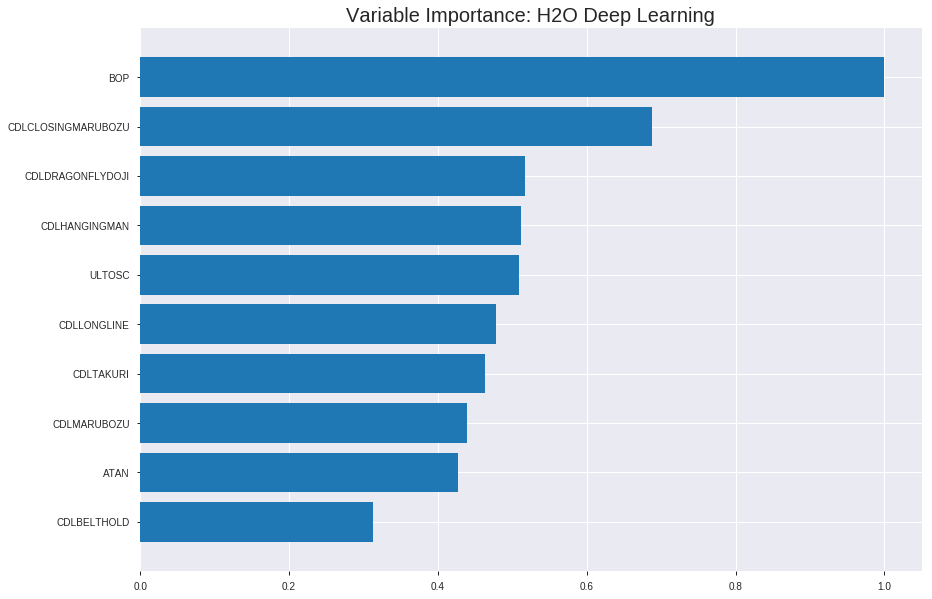

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_042949_model_3


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.20774517766339132
RMSE: 0.4557907169561391
LogLoss: 0.6290064283117698
Mean Per-Class Error: 0.29784218048931166
AUC: 0.7711240137589461
pr_auc: 0.7316056943661517
Gini: 0.5422480275178923
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42682418838227504: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      510  424   0.454    (424.0/934.0)
1      133  685   0.1626   (133.0/818.0)
Total  643  1109  0.3179   (557.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.426824     0.71095   232
max f2                       0.184108     0.830681  325
max f0point5                 0.659812     0.686667  144
max accuracy                 0.634666     0.703767  154
max precision                0.992885     0.931034  5
max recall                   0.00862817   1         397
max specificity              0.999423     0.998929  0
max absolute_mcc             0.520062     0.405341  198
max min_per_class_accuracy   0.591211     0.695599  172
max mean_per_class_accuracy  0.520062     0.702158  198

Gains/Lift Table: Avg response rate: 46.69 %, avg score: 54.90 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.998438           1.90383   1.90383            0.888889         0.999041  0.888889                    0.999041            0.0195599       0.0195599                  90.383    90.383
    2        0.0205479                   0.995804           2.02282   1.96333            0.944444         0.99724   0.916667                    0.99814             0.0207824       0.0403423                  102.282   96.3325
    3        0.0302511                   0.992788           2.01582   1.98016            0.941176         0.994361  0.924528                    0.996928            0.0195599       0.0599022                  101.582   98.0163
    4        0.0405251                   0.988892           1.90383   1.96081            0.888889         0.991186  0.915493                    0.995472            0.0195599       0.0794621                  90.383    96.0811
    5        0.0502283                   0.986007           2.01582   1.97144            0.941176         0.987571  0.920455                    0.993946            0.0195599       0.099022                   101.582   97.1438
    6        0.100457                    0.956626           1.77673   1.87408            0.829545         0.972053  0.875                       0.983               0.0892421       0.188264                   77.6728   87.4083
    7        0.150114                    0.918864           1.57558   1.77534            0.735632         0.938649  0.828897                    0.968329            0.0782396       0.266504                   57.5584   77.534
    8        0.200342                    0.877869           1.48466   1.70246            0.693182         0.897683  0.794872                    0.950617            0.0745721       0.341076                   48.4663   70.2464
    9        0.300228                    0.784423           1.34628   1.58396            0.628571         0.835359  0.739544                    0.91227             0.134474        0.47555                    34.628    58.3962
    10       0.400114                    0.681646           1.27285   1.50629            0.594286         0.734022  0.703281                    0.867772            0.127139        0.602689                   27.2847   50.6294
    11       0.5                         0.574484           1.06479   1.41809            0.497143         0.627436  0.6621                      0.81976             0.106357        0.709046                   6.47852   41.8093
    12       0.599886                    0.463879           0.942396  1.33889            0.44             0.517933  0.625119                    0.769503            0.094132        0.803178                   -5.76039  33.8886
    13       0.699772                    0.332752           0.795529  1.26133            0.371429         0.398713  0.588907                    0.716576            0.0794621       0.882641                   -20.4471  26.1327
    14       0.799658                    0.211325           0.624184  1.18174            0.291429         0.27237   0.551749                    0.66109             0.0623472       0.944988                   -37.5816  18.1741
    15       0.899543                    0.0992859          0.342689  1.08857            0.16             0.155895  0.508249                    0.604993            0.0342298       0.979218                   -65.7311  8.85719
    16       1                           0.00263683         0.206879  1                  0.0965909        0.047619  0.466895                    0.549001           



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3032530199800899
RMSE: 0.5506841381228352
LogLoss: 1.4994038073284837
Mean Per-Class Error: 0.3733067599974075
AUC: 0.6359128913085748
pr_auc: 0.6013018432190584
Gini: 0.2718257826171495
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6084355371927492: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      74   148  0.6667   (148.0/222.0)
1      27   251  0.0971   (27.0/278.0)
Total  101  399  0.35     (175.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.608436     0.741507  298
max f2                       0.00030868   0.862283  399
max f0point5                 0.717571     0.67447   278
max accuracy                 0.717571     0.654     278
max precision                0.930514     0.662651  153
max recall                   0.00030868   1         399
max specificity              0.999991     0.945946  0
max absolute_mcc             0.71559      0.29457   280
max min_per_class_accuracy   0.921476     0.604317  159
max mean_per_class_accuracy  0.717571     0.626693  278

Gains/Lift Table: Avg response rate: 55.60 %, avg score: 79.29 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.999999           1.07914   1.07914            0.6              1         0.6                         1                   0.0107914       0.0107914                  7.91367   7.91367
    2        0.02                        0.999995           0.719424  0.899281           0.4              0.999997  0.5                         0.999999            0.00719424      0.0179856                  -28.0576  -10.0719
    3        0.03                        0.999988           1.79856   1.19904            1                0.999991  0.666667                    0.999996            0.0179856       0.0359712                  79.8561   19.9041
    4        0.04                        0.999982           0.719424  1.07914            0.4              0.999987  0.6                         0.999994            0.00719424      0.0431655                  -28.0576  7.91367
    5        0.05                        0.999977           0.359712  0.935252           0.2              0.999981  0.52                        0.999991            0.00359712      0.0467626                  -64.0288  -6.47482
    6        0.1                         0.999706           1.15108   1.04317            0.64             0.99987   0.58                        0.999931            0.057554        0.104317                   15.1079   4.31655
    7        0.15                        0.99909            1.36691   1.15108            0.76             0.999459  0.64                        0.999773            0.0683453       0.172662                   36.6906   15.1079
    8        0.2                         0.997435           1.15108   1.15108            0.64             0.998594  0.64                        0.999479            0.057554        0.230216                   15.1079   15.1079
    9        0.3                         0.987499           1.11511   1.13909            0.62             0.993274  0.633333                    0.997411            0.111511        0.341727                   11.5108   13.9089
    10       0.4                         0.964312           1.22302   1.16007            0.68             0.975821  0.645                       0.992013            0.122302        0.464029                   22.3022   16.0072
    11       0.5                         0.928677           1.29496   1.18705            0.72             0.946039  0.66                        0.982819            0.129496        0.593525                   29.4964   18.705
    12       0.6                         0.872303           1.04317   1.16307            0.58             0.900672  0.646667                    0.969127            0.104317        0.697842                   4.31655   16.307
    13       0.7                         0.783711           1.00719   1.1408             0.56             0.828885  0.634286                    0.949093            0.100719        0.798561                   0.719424  14.0802
    14       0.8                         0.605733           1.04317   1.1286             0.58             0.71259   0.6275                      0.91953             0.104317        0.902878                   4.31655   12.8597
    15       0.9                         0.308559           0.539568  1.06315            0.3              0.45632   0.591111                    0.868062            0.0539568       0.956835                   -46.0432  6.31495
    16       1                           0.00030868         0.431655  1                  0.24             0.115962  0.556                       0.792852         


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 04:33:09  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 04:33:10  3 min 20.560 sec  586 obs/sec       0.443493  1             777        0.608907         2.56466             -0.489599      0.64378         0.411714           1.66585          0.487443                         0.745421           15.2461               -1.25085         0.555529          0.623221             1.43885            0.444
    2019-07-25 04:33:23  3 min 33.176 sec  605 obs/sec       4.37386   10            7663       0.533556         1.64018             -0.14374       0.722775        0.652247           2.14181          0.374429                         0.741145           15.5875               -1.2251          0.56107           0.641919             1.79856            0.444
    2019-07-25 04:33:37  3 min 46.892 sec  582 obs/sec       8.34589   19            14622      0.540772         1.31128             -0.174889      0.695838        0.540313           1.54686          0.406393                         0.650685           10.235                -0.71508         0.514145          0.192899             0.907607           0.432
    2019-07-25 04:33:50  4 min  0.359 sec  598 obs/sec       12.7643   29            22363      0.497586         0.913502            0.00527015     0.721662        0.706339           2.14181          0.369292                         0.741368           14.0091               -1.22644         0.561483          0.631256             1.43885            0.444
    2019-07-25 04:34:03  4 min 13.205 sec  611 obs/sec       17.1062   39            29970      0.50131          0.757741            -0.00967105    0.705687        0.676332           2.02282          0.415525                         0.714718           7.78402               -1.06924         0.576965          0.634206             1.07914            0.444
    2019-07-25 04:34:16  4 min 25.871 sec  620 obs/sec       21.403    49            37498      0.481144         0.692058            0.0699241      0.728682        0.690269           1.90383          0.375                            0.711187           7.15363               -1.04885         0.579202          0.646706             1.43885            0.444
    2019-07-25 04:34:28  4 min 38.682 sec  628 obs/sec       25.8447   59            45280      0.519379         0.829186            -0.0837675     0.709964        0.695437           1.90383          0.428653                         0.742016           12.2021               -1.23033         0.569018          0.635887             1.79856            0.444
    2019-07-25 04:34:41  4 min 51.410 sec  635 obs/sec       30.3082   69            53100      0.460773         0.620414            0.147015       0.750007        0.724683           2.02282          0.351598                         0.680518           6.20529               -0.875949        0.594441          0.665384             1.43885            0.444
    2019-07-25 04:34:54  5 min  4.105 sec  633 

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
BOP                      1.0                    1.0                  0.008603601669570613
CDLCLOSINGMARUBOZU       0.6878900527954102     0.6878900527954102   0.005918332006711609
CDLDRAGONFLYDOJI         0.5169739127159119     0.5169739127159119   0.004447837618567072
CDLHANGINGMAN            0.5117928385734558     0.5117928385734558   0.004403261720424868
ULTOSC                   0.509261965751648      0.509261965751648    0.004381487098789691
---                      ---                    ---                  ---
BBANDS_upperband_20_0_3  0.1059570237994194     0.1059570237994194   0.0009116120268634181
BBANDS_lowerband_14_7_3  0.1056668758392334     0.1056668758392334   0.0009091157093887392
LINEARREG_20             0.10507497936487198    0.10507497936487198  0.0009040232678937104
BBANDS_upperband_14_7_2  0.10439469665288925    0.10439469665288925  0.0008981703864171158
DEMA_14                  0.1043407991528511     0.1043407991528511   0.0008977066737958019


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6215139442231076)

('F1', 0.5895953757225433)

('auc', 0.5958678773522832)

('logloss', 4.372403362577106)

('mean_per_class_error', 0.40590867219370974)

('rmse', 0.7373134469876261)

('mse', 0.5436311191087749)

deeplearning prediction progress: |███████████████████████████████████████| 100%


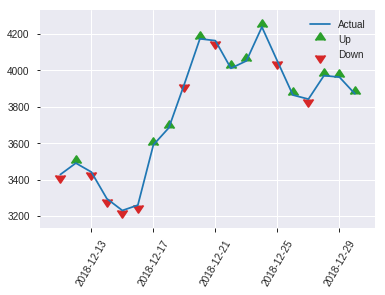


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.5436311191087749
RMSE: 0.7373134469876261
LogLoss: 4.372403362577106
Mean Per-Class Error: 0.40590867219370974
AUC: 0.5958678773522832
pr_auc: 0.48666714377610437
Gini: 0.19173575470456639
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13497547146784736: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      7    142  0.953    (142.0/149.0)
1      0    102  0        (0.0/102.0)
Total  7    244  0.5657   (142.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.134975     0.589595  237
max f2                       0.134975     0.782209  237
max f0point5                 0.999919     0.518672  88
max accuracy                 0.999985     0.621514  44
max precision                0.999999     1         0
max recall                   0.134975     1         237
max specificity              0.999999     1         0
max absolute_mcc             0.999919     0.190567  88
max min_per_class_accuracy   0.999797     0.578431  112
max mean_per_class_accuracy  0.999919     0.594091  88

Gains/Lift Table: Avg response rate: 40.64 %, avg score: 92.79 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.999999           0.820261  0.820261           0.333333         0.999999  0.333333                    0.999999            0.00980392      0.00980392                 -17.9739  -17.9739
    2        0.0239044                   0.999999           1.64052   1.23039            0.666667         0.999999  0.5                         0.999999            0.0196078       0.0294118                  64.0523   23.0392
    3        0.0318725                   0.999998           2.46078   1.53799            1                0.999998  0.625                       0.999999            0.0196078       0.0490196                  146.078   53.799
    4        0.0438247                   0.999998           0.820261  1.34225            0.333333         0.999998  0.545455                    0.999999            0.00980392      0.0588235                  -17.9739  34.2246
    5        0.0517928                   0.999996           2.46078   1.51433            1                0.999997  0.615385                    0.999998            0.0196078       0.0784314                  146.078   51.4329
    6        0.103586                    0.999994           1.32504   1.41968            0.538462         0.999995  0.576923                    0.999997            0.0686275       0.147059                   32.5038   41.9683
    7        0.151394                    0.999991           1.23039   1.35991            0.5              0.999992  0.552632                    0.999995            0.0588235       0.205882                   23.0392   35.9907
    8        0.203187                    0.999985           1.51433   1.39927            0.615385         0.999988  0.568627                    0.999993            0.0784314       0.284314                   51.4329   39.927
    9        0.302789                    0.999958           0.984314  1.26277            0.4              0.999971  0.513158                    0.999986            0.0980392       0.382353                   -1.56863  26.2771
    10       0.40239                     0.999905           1.27961   1.26694            0.52             0.999934  0.514851                    0.999973            0.127451        0.509804                   27.9608   26.6938
    11       0.501992                    0.999759           0.68902   1.15227            0.28             0.999829  0.468254                    0.999945            0.0686275       0.578431                   -31.098   15.2272
    12       0.601594                    0.999511           0.885882  1.10817            0.36             0.99965   0.450331                    0.999896            0.0882353       0.666667                   -11.4118  10.8168
    13       0.701195                    0.998614           1.08275   1.10456            0.44             0.999146  0.448864                    0.999789            0.107843        0.77451                    8.27451   10.4557
    14       0.800797                    0.988736           0.590588  1.04063            0.24             0.994731  0.422886                    0.99916             0.0588235       0.833333                   -40.9412  4.06302
    15       0.900398                    0.826091           0.885882  1.02351            0.36             0.930066  0.415929                    0.991517            0.0882353       0.921569                   -11.4118  2.35121
    16       1                           0.00158196         0.787451  1                  0.32             0.353272  0.406375                    0.927947          

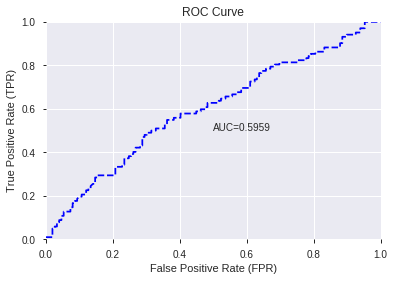

This function is available for GLM models only


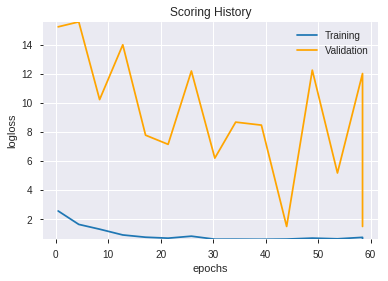

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLDRAGONFLYDOJI',
 'CDLHANGINGMAN',
 'ULTOSC',
 'CDLLONGLINE',
 'CDLTAKURI',
 'CDLMARUBOZU',
 'ATAN',
 'CDLBELTHOLD',
 'MINUS_DM_20',
 'STOCHF_fastk',
 'STOCH_slowd',
 'MINUS_DM_24',
 'aroondown_14',
 'STOCHF_fastd',
 'WILLR_14',
 'MINUS_DM_30',
 'WILLR_12',
 'LN',
 'LOG10',
 'STOCH_slowk',
 'aroondown_24',
 'CDLSHORTLINE',
 'aroondown_30',
 'ATR_20',
 'ATR_24',
 'WILLR_8',
 'STOCHRSI_fastk',
 'aroonup_8',
 'aroondown_8',
 'AROONOSC_24',
 'aroonup_12',
 'WILLR_20',
 'CDLENGULFING',
 'WILLR_24',
 'aroondown_12',
 'PLUS_DI_8',
 'aroonup_24',
 'LINEARREG_ANGLE_12',
 'ATR_30',
 'ROCP_30',
 'ROC_30',
 'ROCR100_30',
 'ADOSC',
 'aroonup_30',
 'WILLR_30',
 'aroonup_14',
 'ROC_20',
 'aroondown_20',
 'ROCR100_20',
 'ROCR_30',
 'ROCR_20',
 'PLUS_DI_14',
 'LINEARREG_ANGLE_8',
 'LINEARREG_ANGLE_20',
 'ROCR_24',
 'CCI_14',
 'ROCP_20',
 'PLUS_DI_30',
 'PLUS_DI_12',
 'LINEARREG_ANGLE_30',
 'CCI_8',
 'AROONOSC_30',
 'MFI_30',
 'ROCR100_24',
 'LINEARREG_ANGLE_24',
 'PLU

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_050254_model_1  0.563429  1.612483              0.434399  0.615084  0.378328

variable  relative_importance  scaled_importance    percentage
0                         BOP             0.196846           1.000000  5.490374e-02
1          CDLCLOSINGMARUBOZU             0.115427           0.586380  3.219448e-02
2                 CDLLONGLINE             0.090731           0.460921  2.530627e-02
3                      ULTOSC             0.082617           0.419703  2.304329e-02
4                STOCHF_fastk             0.074554           0.378741  2.079430e-02
..                        ...                  ...                ...           ...
874  BBANDS_middleband_20_2_4             0.000005           0.000025  1.377940e-06
875  BBANDS_middleband_30_2_2             0.000004           0.000022  1.221453e-06
876  BBANDS_middleband_30_2_3             0.000003           0.000015  7.975233e-07
877  BBANDS_middleband_14_2_2             0.000003           0.000014  7.412323e-07
878               AROONOSC_20             0.000002           0.000011  6.070788e-07

[879 rows x 4 columns]

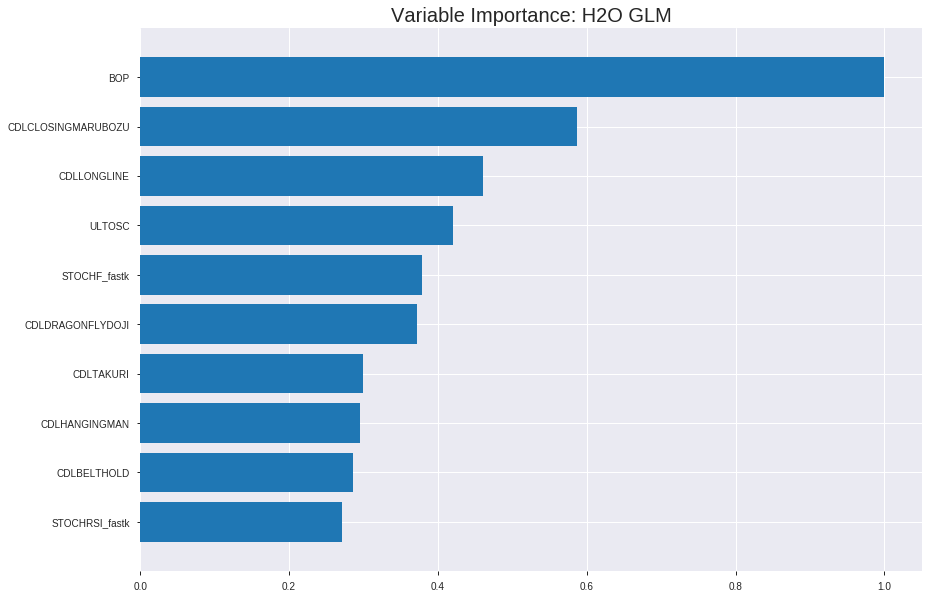

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_050254_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.20283749213114277
RMSE: 0.450374835144175
LogLoss: 0.5918439718987135
Null degrees of freedom: 1751
Residual degrees of freedom: 872
Null deviance: 2421.1017340295916
Residual deviance: 2073.821277533092
AIC: 3833.821277533092
AUC: 0.7538625047774118
pr_auc: 0.7314927484086532
Gini: 0.5077250095548236
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.39917566453013675: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      499  435   0.4657   (435.0/934.0)
1      145  673   0.1773   (145.0/818.0)
Total  644  1108  0.3311   (580.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.399176     0.698858  247
max f2                       0.254306     0.824902  339
max f0point5                 0.507299     0.666393  173
max accuracy                 0.507299     0.684361  173
max precision                0.875523     1         0
max recall                   0.112614     1         393
max specificity              0.875523     1         0
max absolute_mcc             0.429486     0.377001  228
max min_per_class_accuracy   0.467178     0.673594  201
max mean_per_class_accuracy  0.429486     0.687013  228

Gains/Lift Table: Avg response rate: 46.69 %, avg score: 46.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.837455           1.90383   1.90383            0.888889         0.854567  0.888889                    0.854567            0.0195599       0.0195599                  90.383    90.383
    2        0.0205479                   0.81211            2.02282   1.96333            0.944444         0.825631  0.916667                    0.840099            0.0207824       0.0403423                  102.282   96.3325
    3        0.0302511                   0.788077           2.01582   1.98016            0.941176         0.796481  0.924528                    0.826108            0.0195599       0.0599022                  101.582   98.0163
    4        0.0405251                   0.770043           2.02282   1.99098            0.944444         0.778416  0.929577                    0.814017            0.0207824       0.0806846                  102.282   99.0978
    5        0.0502283                   0.756953           2.14181   2.02012            1                0.762748  0.943182                    0.804113            0.0207824       0.101467                   114.181   102.012
    6        0.100457                    0.704844           1.80107   1.91059            0.840909         0.728568  0.892045                    0.76634             0.0904645       0.191932                   80.1067   91.0591
    7        0.150114                    0.653506           1.72329   1.84863            0.804598         0.6764    0.863118                    0.736588            0.0855746       0.277506                   72.3295   84.8634
    8        0.200342                    0.61673            1.31429   1.71467            0.613636         0.634102  0.80057                     0.710894            0.0660147       0.343521                   31.4292   71.4668
    9        0.300228                    0.559945           1.27285   1.56767            0.594286         0.586001  0.731939                    0.669342            0.127139        0.47066                    27.2847   56.7674
    10       0.400114                    0.507858           1.17494   1.46963            0.548571         0.533947  0.686163                    0.635541            0.117359        0.58802                    17.4935   46.9629
    11       0.5                         0.457397           0.966874  1.36919            0.451429         0.483949  0.639269                    0.605257            0.096577        0.684597                   -3.31261  36.9193
    12       0.599886                    0.41409            1.05255   1.31647            0.491429         0.43655   0.614653                    0.577166            0.105134        0.789731                   5.25463   31.6469
    13       0.699772                    0.362243           0.795529  1.24211            0.371429         0.388499  0.579935                    0.550236            0.0794621       0.869193                   -20.4471  24.211
    14       0.799658                    0.310664           0.636423  1.16645            0.297143         0.337969  0.544611                    0.523721            0.0635697       0.932763                   -36.3577  16.6453
    15       0.899543                    0.252069           0.440601  1.08585            0.205714         0.283166  0.50698                     0.49701             0.0440098       0.976773                   -55.9399  8.58538
    16       1                           0.0721516          0.231218  1                  0.107955         0.197229  0.466895                    0.466895           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.38421526935332617
RMSE: 0.6198510057693914
LogLoss: 1.6360259059678204
Null degrees of freedom: 499
Residual degrees of freedom: -380
Null deviance: 702.7702737716033
Residual deviance: 1636.0259059678078
AIC: 3396.025905967808
AUC: 0.6068280510726554
pr_auc: 0.6757578241645822
Gini: 0.21365610214531072
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.00011779296604404349: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      15   207  0.9324   (207.0/222.0)
1      5    273  0.018    (5.0/278.0)
Total  20   480  0.424    (212.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.000117793  0.720317  397
max f2                       7.9956e-06   0.862283  399
max f0point5                 0.00161268   0.628116  384
max accuracy                 0.00161268   0.588     384
max precision                0.796131     1         0
max recall                   7.9956e-06   1         399
max specificity              0.796131     1         0
max absolute_mcc             0.407664     0.232968  83
max min_per_class_accuracy   0.0938719    0.563063  244
max mean_per_class_accuracy  0.306441     0.592472  134

Gains/Lift Table: Avg response rate: 55.60 %, avg score: 18.39 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.69864            1.43885   1.43885            0.8              0.744405     0.8                         0.744405            0.0143885       0.0143885                  43.8849   43.8849
    2        0.02                        0.634253           1.79856   1.61871            1                0.662738     0.9                         0.703571            0.0179856       0.0323741                  79.8561   61.8705
    3        0.03                        0.597411           1.79856   1.67866            1                0.62302      0.933333                    0.676721            0.0179856       0.0503597                  79.8561   67.8657
    4        0.04                        0.577719           1.07914   1.52878            0.6              0.590008     0.85                        0.655043            0.0107914       0.0611511                  7.91367   52.8777
    5        0.05                        0.558259           1.43885   1.51079            0.8              0.573134     0.84                        0.638661            0.0143885       0.0755396                  43.8849   51.0791
    6        0.1                         0.473027           1.51079   1.51079            0.84             0.520624     0.84                        0.579642            0.0755396       0.151079                   51.0791   51.0791
    7        0.15                        0.422484           1.36691   1.46283            0.76             0.447681     0.813333                    0.535655            0.0683453       0.219424                   36.6906   46.283
    8        0.2                         0.375853           1.00719   1.34892            0.56             0.400654     0.75                        0.501905            0.0503597       0.269784                   0.719424  34.8921
    9        0.3                         0.282136           1.04317   1.247              0.58             0.3317       0.693333                    0.44517             0.104317        0.374101                   4.31655   24.7002
    10       0.4                         0.192278           0.935252  1.16906            0.52             0.237044     0.65                        0.393138            0.0935252       0.467626                   -6.47482  16.9065
    11       0.5                         0.103824           0.899281  1.11511            0.5              0.142971     0.62                        0.343105            0.0899281       0.557554                   -10.0719  11.5108
    12       0.6                         0.0536815          0.935252  1.08513            0.52             0.0715718    0.603333                    0.297849            0.0935252       0.651079                   -6.47482  8.51319
    13       0.7                         0.0207886          0.899281  1.05858            0.5              0.0375971    0.588571                    0.26067             0.0899281       0.741007                   -10.0719  5.85817
    14       0.8                         0.00571133         0.863309  1.03417            0.48             0.0113428    0.575                       0.229505            0.0863309       0.827338                   -13.6691  3.41727
    15       0.9                         0.000583678        1.07914   1.03917            0.6              0.00251704   0.577778                    0.204284            0.107914        0.935252                   7.91367   3.91687
    16       1                           1.48138e-07        0.647482  1                  0.36             0.000


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 05:02:58  0.000 sec   3            20        880           1.33227           4.01372
    2019-07-25 05:02:59  1.458 sec   5            14        880           1.32542           4.12478
    2019-07-25 05:03:01  2.884 sec   7            10        880           1.3179            4.13503
    2019-07-25 05:03:02  4.334 sec   9            7.6       880           1.30951           4.05333
    2019-07-25 05:03:03  5.778 sec   11           5.5       880           1.30007           3.96332
    2019-07-25 05:03:05  7.253 sec   13           4         880           1.28945           3.85271
    2019-07-25 05:03:06  8.689 sec   15           2.9       880           1.2776            3.76086
    2019-07-25 05:03:08  10.126 sec  17           2.1       880           1.26465           3.66031
    2019-07-25 05:03:09  11.631 sec  19           1.5       880           1.25084           3.56953
    2019-07-25 05:03:11  13.074 sec  21           1.1       880           1.23658           3.48513
    2019-07-25 05:03:12  14.602 sec  23           0.82      880           1.22234           3.41125
    2019-07-25 05:03:14  16.065 sec  25           0.6       880           1.20857           3.34444
    2019-07-25 05:03:15  17.516 sec  27           0.43      880           1.1956            3.29452
    2019-07-25 05:03:17  18.952 sec  29           0.32      880           1.18369           3.27205
    2019-07-25 05:03:18  20.380 sec  31           0.23      880           1.17292           3.28502
    2019-07-25 05:03:20  21.874 sec  33           0.17      880           1.1633            3.34442
    2019-07-25 05:03:21  23.300 sec  35           0.12      880           1.15473           3.46645
    2019-07-25 05:03:23  24.837 sec  37           0.089     880           1.14712           3.65436
    2019-07-25 05:03:24  26.292 sec  39           0.065     880           1.14037           3.91138

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5976095617529881)

('F1', 0.588628762541806)

('auc', 0.5634293986050797)

('logloss', 1.6124828005914864)

('mean_per_class_error', 0.41837741808132645)

('rmse', 0.6150838040585193)

('mse', 0.3783280860150989)

glm prediction progress: |████████████████████████████████████████████████| 100%


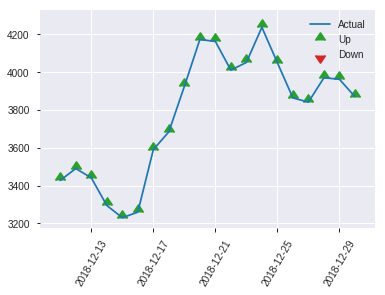


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.3783280860150989
RMSE: 0.6150838040585193
LogLoss: 1.6124828005914864
Null degrees of freedom: 250
Residual degrees of freedom: -629
Null deviance: 342.8297670320054
Residual deviance: 809.4663658969257
AIC: 2569.4663658969257
AUC: 0.5634293986050797
pr_auc: 0.4358542663259111
Gini: 0.12685879721015936
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.007458936913967492: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      40   109  0.7315   (109.0/149.0)
1      14   88   0.1373   (14.0/102.0)
Total  54   197  0.49     (123.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.00745894   0.588629  196
max f2                       0.000363487  0.779817  245
max f0point5                 0.00978647   0.504988  174
max accuracy                 0.598994     0.59761   4
max precision                0.598994     0.6       4
max recall                   0.000363487  1         245
max specificity              0.72488      0.993289  0
max absolute_mcc             0.00978647   0.174505  174
max min_per_class_accuracy   0.0191131    0.539216  121
max mean_per_class_accuracy  0.00978647   0.581623  174

Gains/Lift Table: Avg response rate: 40.64 %, avg score:  5.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.611936           0.820261  0.820261           0.333333         0.65956     0.333333                    0.65956             0.00980392      0.00980392                 -17.9739  -17.9739
    2        0.0239044                   0.578696           1.64052   1.23039            0.666667         0.592805    0.5                         0.626183            0.0196078       0.0294118                  64.0523   23.0392
    3        0.0318725                   0.336969           0         0.922794           0                0.429293    0.375                       0.57696             0               0.0294118                  -100      -7.72059
    4        0.0438247                   0.193143           0         0.671123           0                0.273007    0.272727                    0.494064            0               0.0294118                  -100      -32.8877
    5        0.0517928                   0.166102           2.46078   0.946456           1                0.172398    0.384615                    0.444577            0.0196078       0.0490196                  146.078   -5.35445
    6        0.103586                    0.0985609          0.946456  0.946456           0.384615         0.126595    0.384615                    0.285586            0.0490196       0.0980392                  -5.35445  -5.35445
    7        0.151394                    0.0798629          1.23039   1.03612            0.5              0.0874497   0.421053                    0.223017            0.0588235       0.156863                   23.0392   3.61197
    8        0.203187                    0.0572566          0.946456  1.01326            0.384615         0.0663876   0.411765                    0.183092            0.0490196       0.205882                   -5.35445  1.32641
    9        0.302789                    0.0369891          1.37804   1.13326            0.56             0.0459529   0.460526                    0.13798             0.137255        0.343137                   37.8039   13.3256
    10       0.40239                     0.0243336          1.27961   1.16948            0.52             0.0280389   0.475248                    0.110767            0.127451        0.470588                   27.9608   16.9482
    11       0.501992                    0.0168169          0.787451  1.09368            0.32             0.0210153   0.444444                    0.0929591           0.0784314       0.54902                    -21.2549  9.36819
    12       0.601594                    0.0127548          0.885882  1.05928            0.36             0.0147475   0.430464                    0.0800102           0.0882353       0.637255                   -11.4118  5.9278
    13       0.701195                    0.00972019         1.5749    1.13252            0.64             0.0111543   0.460227                    0.0702295           0.156863        0.794118                   57.4902   13.252
    14       0.800797                    0.00728373         0.68902   1.07736            0.28             0.00829541  0.437811                    0.0625263           0.0686275       0.862745                   -31.098   7.73583
    15       0.900398                    0.00388568         0.590588  1.02351            0.24             0.00562906  0.415929                    0.0562323           0.0588235       0.921569                   -40.9412  2.35121
    16       1                           0.000169877        0.787451  1                  0.32             0.00119398  0.4063

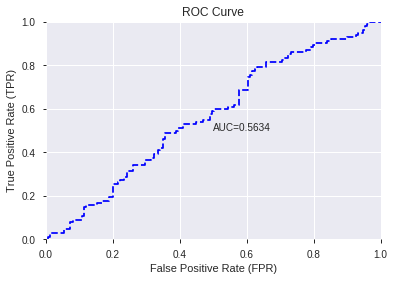

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


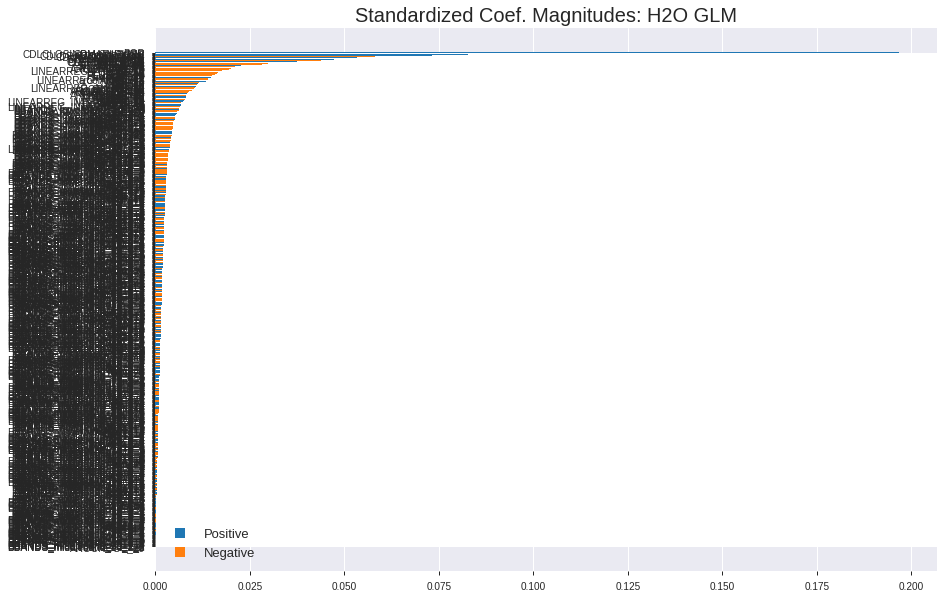

'log_likelihood'
--2019-07-25 05:03:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.99.75
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.99.75|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_050254_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_050254_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_be36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['BOP',
 'CDLCLOSINGMARUBOZU',
 'CDLLONGLINE',
 'ULTOSC',
 'STOCHF_fastk',
 'CDLDRAGONFLYDOJI',
 'CDLTAKURI',
 'CDLHANGINGMAN',
 'CDLBELTHOLD',
 'STOCHRSI_fastk',
 'WILLR_8',
 'CDLSHORTLINE',
 'WILLR_12',
 'WILLR_14',
 'STOCH_slowd',
 'CDLMARUBOZU',
 'CDLENGULFING',
 'ADOSC',
 'WILLR_24',
 'STOCHF_fastd',
 'STOCH_slowk',
 'aroondown_14',
 'WILLR_20',
 'WILLR_30',
 'PLUS_DI_8',
 'aroondown_24',
 'AROONOSC_24',
 'RSI_8',
 'CCI_20',
 'CMO_8',
 'LINEARREG_ANGLE_12',
 'CCI_14',
 'PLUS_DI_12',
 'ATR_30',
 'TRIX_8',
 'CCI_12',
 'PLUS_DI_30',
 'PLUS_DI_14',
 'PLUS_DI_24',
 'PLUS_DI_20',
 'aroonup_8',
 'ATR_24',
 'RSI_12',
 'aroonup_24',
 'CMO_12',
 'ATAN',
 'aroondown_12',
 'LINEARREG_ANGLE_8',
 'ATR_20',
 'CMO_14',
 'RSI_14',
 'MFI_30',
 'CCI_24',
 'High',
 'CCI_30',
 'RSI_20',
 'CMO_20',
 'Open',
 'RSI_24',
 'CMO_24',
 'LINEARREG_ANGLE_30',
 'CMO_30',
 'AROONOSC_8',
 'RSI_30',
 'aroonup_12',
 'AROONOSC_14',
 'MEDPRICE',
 'MINUS_DM_30',
 'MINUS_DI_14',
 'ADD',
 'aroondown_20',
 'PPO',
 'aroon

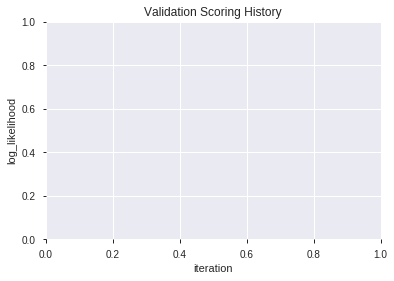

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190725_050350_model_1  0.741677  0.598367              0.275365  0.455545  0.207521
1  XGBoost_grid_1_AutoML_20190725_050350_model_4  0.725885  0.611888              0.318233  0.461356  0.212850
2               XGBoost_1_AutoML_20190725_050350  0.718450  0.607744              0.321062  0.458303  0.210041
3  XGBoost_grid_1_AutoML_20190725_050350_model_3  0.716213  0.622616              0.318233  0.466454  0.217579
4               XGBoost_3_AutoML_20190725_050350  0.710357  0.618098              0.310995  0.464121  0.215408
5               XGBoost_2_AutoML_20190725_050350  0.709567  0.619005              0.313594  0.465238  0.216446
6  XGBoost_grid_1_AutoML_20190725_050350_model_7  0.705817  0.610330              0.364456  0.459841  0.211454
7  XGBoost_grid_1_AutoML_20190725_050350_model_6  0.704764  0.622038              0.296289  0.466829  0.217929
8  XGBoost_grid_1_AutoML_20190725_050350_model_2  0.702198  0.619067              0.297835  0.464390  0.215658
9  XGBoost_grid_1_AutoML_20190725_050350_model_5  0.620937  0.661402              0.411962  0.484243  0.234491

variable  relative_importance  scaled_importance  percentage
0                        BOP          2670.343506           1.000000    0.300572
1               STOCHF_fastk           725.717102           0.271769    0.081686
2                   WILLR_12           557.544373           0.208791    0.062757
3                     ULTOSC           260.167999           0.097429    0.029284
4                    WILLR_8           241.784790           0.090544    0.027215
..                       ...                  ...                ...         ...
176   LINEARREG_INTERCEPT_24             1.003164           0.000376    0.000113
177             LINEARREG_24             0.836140           0.000313    0.000094
178  BBANDS_lowerband_30_0_5             0.807139           0.000302    0.000091
179  BBANDS_lowerband_24_5_2             0.394337           0.000148    0.000044
180                 SAR_0.14             0.029812           0.000011    0.000003

[181 rows x 4 columns]

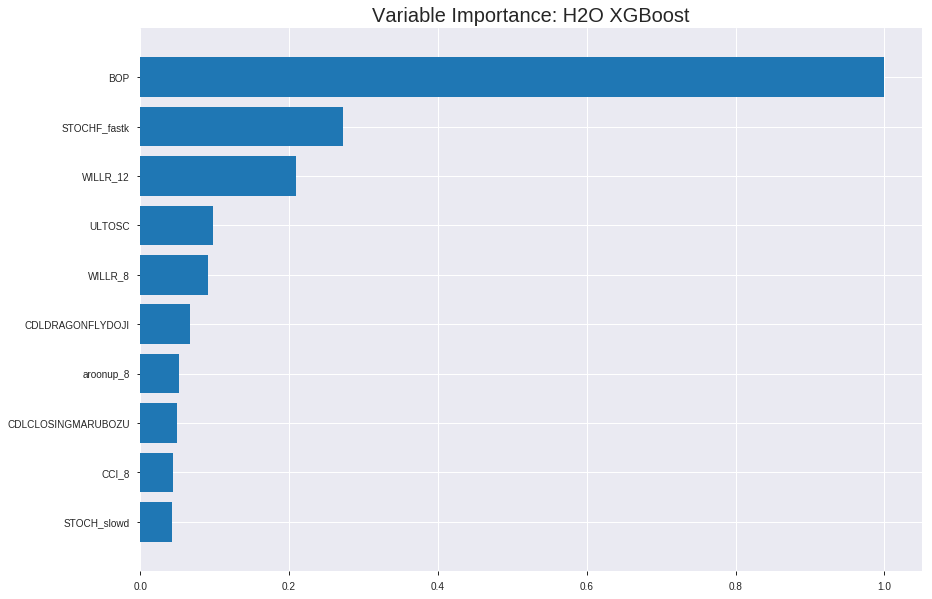

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190725_050350_model_1


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.1407972620543274
RMSE: 0.3752296124432711
LogLoss: 0.44404262659873783
Mean Per-Class Error: 0.17230619414354753
AUC: 0.9131695575462165
pr_auc: 0.906017383833534
Gini: 0.8263391150924331
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45606042941411334: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      733  201  0.2152   (201.0/934.0)
1      108  710  0.132    (108.0/818.0)
Total  841  911  0.1764   (309.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.45606      0.821284  221
max f2                       0.373567     0.88342   261
max f0point5                 0.527547     0.837085  181
max accuracy                 0.50978      0.830479  189
max precision                0.971474     1         0
max recall                   0.152432     1         356
max specificity              0.971474     1         0
max absolute_mcc             0.50978      0.660541  189
max min_per_class_accuracy   0.478225     0.822738  208
max mean_per_class_accuracy  0.470323     0.827694  214

Gains/Lift Table: Avg response rate: 46.69 %, avg score: 46.78 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.953437           2.14181    2.14181            1                0.961478  1                           0.961478            0.0220049       0.0220049                  114.181   114.181
    2        0.0205479                   0.939454           2.14181    2.14181            1                0.946243  1                           0.95386             0.0220049       0.0440098                  114.181   114.181
    3        0.0302511                   0.930573           2.14181    2.14181            1                0.935716  1                           0.948041            0.0207824       0.0647922                  114.181   114.181
    4        0.0405251                   0.921014           2.14181    2.14181            1                0.924558  1                           0.942087            0.0220049       0.0867971                  114.181   114.181
    5        0.0502283                   0.906368           2.14181    2.14181            1                0.912079  1                           0.93629             0.0207824       0.107579                   114.181   114.181
    6        0.100457                    0.811987           2.11747    2.12964            0.988636         0.861507  0.994318                    0.898899            0.106357        0.213936                   111.747   112.964
    7        0.150114                    0.73611            2.09257    2.11738            0.977011         0.772986  0.988593                    0.857247            0.103912        0.317848                   109.257   111.738
    8        0.200342                    0.663643           2.02012    2.09299            0.943182         0.693286  0.977208                    0.81614             0.101467        0.419315                   102.012   109.299
    9        0.300228                    0.575889           1.71345    1.96672            0.8              0.616885  0.918251                    0.749848            0.171149        0.590465                   71.3447   96.6718
    10       0.400114                    0.520153           1.48091    1.84544            0.691429         0.54762   0.861626                    0.699363            0.147922        0.738386                   48.0908   84.5439
    11       0.5                         0.466935           1.11374    1.69927            0.52             0.492417  0.793379                    0.658021            0.111247        0.849633                   11.3741   69.9267
    12       0.599886                    0.403908           0.709857   1.53452            0.331429         0.436565  0.716461                    0.621147            0.0709046       0.920538                   -29.0143  53.4522
    13       0.699772                    0.335695           0.416123   1.37488            0.194286         0.371663  0.641925                    0.585535            0.0415648       0.962103                   -58.3877  37.4881
    14       0.799658                    0.245799           0.305973   1.24136            0.142857         0.293982  0.579586                    0.549117            0.0305623       0.992665                   -69.4027  24.1363
    15       0.899543                    0.13683            0.0734335  1.11168            0.0342857        0.181654  0.519036                    0.508314            0.00733496      1                          -92.6567  11.1675
    16       1                           0.0558478          0          1                  0                0.105248  0.466895                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.19128271846865955
RMSE: 0.43735879832085184
LogLoss: 0.5580831725143908
Mean Per-Class Error: 0.2664949121783654
AUC: 0.8047588955862338
pr_auc: 0.8231739516176472
Gini: 0.6095177911724676
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.37178701162338257: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      130  92   0.4144   (92.0/222.0)
1      33   245  0.1187   (33.0/278.0)
Total  163  337  0.25     (125.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.371787     0.796748  265
max f2                       0.162947     0.884465  339
max f0point5                 0.429009     0.763386  219
max accuracy                 0.371787     0.75      265
max precision                0.962614     1         0
max recall                   0.0883742    1         385
max specificity              0.962614     1         0
max absolute_mcc             0.371787     0.494875  265
max min_per_class_accuracy   0.440527     0.720721  209
max mean_per_class_accuracy  0.41456      0.733505  235

Gains/Lift Table: Avg response rate: 55.60 %, avg score: 45.16 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.958881           1.79856    1.79856            1                0.96067    1                           0.96067             0.0179856       0.0179856                  79.8561   79.8561
    2        0.02                        0.931665           1.79856    1.79856            1                0.940093   1                           0.950381            0.0179856       0.0359712                  79.8561   79.8561
    3        0.03                        0.920528           1.43885    1.67866            0.8              0.926146   0.933333                    0.942303            0.0143885       0.0503597                  43.8849   67.8657
    4        0.04                        0.909019           1.79856    1.70863            1                0.915034   0.95                        0.935486            0.0179856       0.0683453                  79.8561   70.8633
    5        0.05                        0.90165            1.79856    1.72662            1                0.90474    0.96                        0.929337            0.0179856       0.0863309                  79.8561   72.6619
    6        0.1                         0.784659           1.65468    1.69065            0.92             0.855411   0.94                        0.892374            0.0827338       0.169065                   65.4676   69.0647
    7        0.15                        0.676354           1.65468    1.67866            0.92             0.726461   0.933333                    0.83707             0.0827338       0.251799                   65.4676   67.8657
    8        0.2                         0.607471           1.29496    1.58273            0.72             0.643476   0.88                        0.788671            0.0647482       0.316547                   29.4964   58.2734
    9        0.3                         0.541768           1.33094    1.4988             0.74             0.57146    0.833333                    0.716267            0.133094        0.44964                    33.0935   49.8801
    10       0.4                         0.500274           1.22302    1.42986            0.68             0.520654   0.795                       0.667364            0.122302        0.571942                   22.3022   42.9856
    11       0.5                         0.455976           1.18705    1.38129            0.66             0.477103   0.768                       0.629312            0.118705        0.690647                   18.705    38.1295
    12       0.6                         0.414502           1.15108    1.34293            0.64             0.43052    0.746667                    0.59618             0.115108        0.805755                   15.1079   34.2926
    13       0.7                         0.357831           0.791367   1.26413            0.44             0.386985   0.702857                    0.566295            0.0791367       0.884892                   -20.8633  26.4132
    14       0.8                         0.218228           0.719424   1.19604            0.4              0.302253   0.665                       0.53329             0.0719424       0.956835                   -28.0576  19.6043
    15       0.9                         0.112397           0.359712   1.10312            0.2              0.158189   0.613333                    0.491612            0.0359712       0.992806                   -64.0288  10.3118
    16       1                           0.0527267          0.0719424  1                  0.04             0.0918615  0.556    


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 05:04:07  0.018 sec   0                  0.5              0.693147            0.5             0                  1                0.533105                         0.5                0.693147              0.5               0                    1                  0.444
    2019-07-25 05:04:07  0.591 sec   5                  0.472332         0.638835            0.82118         0.814605           2.14181          0.28653                          0.475675           0.645155              0.772936          0.716563             1.79856            0.286
    2019-07-25 05:04:07  0.770 sec   10                 0.45322          0.601556            0.832423        0.826095           2.14181          0.269406                         0.460592           0.615205              0.787527          0.818646             1.79856            0.278
    2019-07-25 05:04:07  0.962 sec   15                 0.438322         0.571914            0.844485        0.837503           2.14181          0.256849                         0.452862           0.59901               0.789512          0.818076             1.79856            0.274
    2019-07-25 05:04:08  1.173 sec   20                 0.427433         0.549601            0.851544        0.843991           2.14181          0.239726                         0.447168           0.586029              0.790233          0.818162             1.79856            0.266
    2019-07-25 05:04:08  1.368 sec   25                 0.418665         0.531081            0.858232        0.851748           2.14181          0.233447                         0.444068           0.57817               0.794559          0.822333             1.79856            0.27
    2019-07-25 05:04:08  1.552 sec   30                 0.411216         0.515226            0.86562         0.856353           2.14181          0.231164                         0.440489           0.569342              0.799339          0.825786             1.79856            0.266
    2019-07-25 05:04:08  1.733 sec   35                 0.403945         0.50035             0.876315        0.867828           2.14181          0.208904                         0.438406           0.564281              0.799995          0.82301              1.79856            0.262
    2019-07-25 05:04:08  1.908 sec   40                 0.398534         0.489205            0.881641        0.872114           2.14181          0.209475                         0.436454           0.559905              0.800425          0.821512             1.79856            0.256
    2019-07-25 05:04:09  2.087 sec   45                 0.393145         0.478679            0.890472        0.882389           2.14181          0.208333                         0.435002           0.555779              0.803195          0.825467             1.79856            0.258
    2019-07-25 05:04:09  2.248 sec   50                 0.389783         0.471502            0.893557        0.885297           2.14181          0.199201                         0.435742           0.556516              0.803471          0.823222             1.79856            0.25
    2019-07-25 05:04:09  2.405 sec   55                 0.38693          0.465668            0.896278        0.888404           2.14181          0.193493                         0.435701           0.555849              0.805399          0.824019             1.79856        

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      2670.343505859375      1.0                     0.30057171876138894
STOCHF_fastk             725.7171020507812      0.27176919391021553     0.08168613371999067
WILLR_12                 557.5443725585938      0.2087912552580623      0.06275674645526366
ULTOSC                   260.1679992675781      0.09742866365196352     0.029284300890495933
WILLR_8                  241.7847900390625      0.09054445224313973     0.027215101635029004
---                      ---                    ---                     ---
LINEARREG_INTERCEPT_24   1.003164291381836      0.00037566863183730953  0.00011291536635607956
LINEARREG_24             0.8361396789550781     0.0003131206442618288   9.411521022545131e-05
BBANDS_lowerband_30_0_5  0.8071393966674805     0.00030226051251324885  9.085096175980552e-05
BBANDS_lowerband_24_5_2  0.3943367004394531     0.00014767264944535552  4.438622205783857e-05
SAR_0.14                 0.029812097549438477   1.1164143296180276e-05  3.355625739031343e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7171314741035857)

('F1', 0.6872246696035241)

('auc', 0.7416765363863667)

('logloss', 0.5983667141520748)

('mean_per_class_error', 0.2753651796288985)

('rmse', 0.45554499095534184)

('mse', 0.2075212387845025)

xgboost prediction progress: |████████████████████████████████████████████| 100%


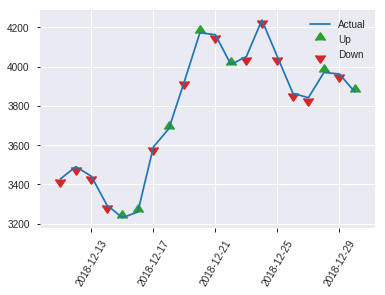


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2075212387845025
RMSE: 0.45554499095534184
LogLoss: 0.5983667141520748
Mean Per-Class Error: 0.2753651796288985
AUC: 0.7416765363863667
pr_auc: 0.6205477703626344
Gini: 0.4833530727727333
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3702656924724579: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      102  47   0.3154   (47.0/149.0)
1      24   78   0.2353   (24.0/102.0)
Total  126  125  0.2829   (71.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.370266     0.687225  124
max f2                       0.255842     0.796233  175
max f0point5                 0.370266     0.647841  124
max accuracy                 0.370266     0.717131  124
max precision                0.909645     1         0
max recall                   0.0943758    1         238
max specificity              0.909645     1         0
max absolute_mcc             0.370266     0.441327  124
max min_per_class_accuracy   0.375971     0.697987  116
max mean_per_class_accuracy  0.370266     0.724635  124

Gains/Lift Table: Avg response rate: 40.64 %, avg score: 34.97 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.849401           2.46078   2.46078            1                0.894115   1                           0.894115            0.0294118       0.0294118                  146.078   146.078
    2        0.0239044                   0.733104           1.64052   2.05065            0.666667         0.77526    0.833333                    0.834687            0.0196078       0.0490196                  64.0523   105.065
    3        0.0318725                   0.718877           1.23039   1.84559            0.5              0.726036   0.75                        0.807525            0.00980392      0.0588235                  23.0392   84.5588
    4        0.0438247                   0.623509           0.820261  1.56595            0.333333         0.657914   0.636364                    0.766722            0.00980392      0.0686275                  -17.9739  56.5954
    5        0.0517928                   0.593381           1.23039   1.51433            0.5              0.602851   0.615385                    0.741511            0.00980392      0.0784314                  23.0392   51.4329
    6        0.103586                    0.532376           2.0822    1.79827            0.846154         0.549114   0.730769                    0.645312            0.107843        0.186275                   108.22    79.8265
    7        0.151394                    0.494833           1.43546   1.68369            0.583333         0.512704   0.684211                    0.603436            0.0686275       0.254902                   43.5458   68.3695
    8        0.203187                    0.480815           1.51433   1.64052            0.615385         0.486966   0.666667                    0.573748            0.0784314       0.333333                   51.4329   64.0523
    9        0.302789                    0.442265           1.47647   1.58656            0.6              0.462053   0.644737                    0.537006            0.147059        0.480392                   47.6471   58.6558
    10       0.40239                     0.401788           1.37804   1.53494            0.56             0.421021   0.623762                    0.508297            0.137255        0.617647                   37.8039   53.4945
    11       0.501992                    0.368624           1.47647   1.52334            0.6              0.382111   0.619048                    0.48326             0.147059        0.764706                   47.6471   52.3343
    12       0.601594                    0.327118           0.393725  1.33632            0.16             0.34913    0.543046                    0.461053            0.0392157       0.803922                   -60.6275  33.632
    13       0.701195                    0.255842           1.08275   1.3003             0.44             0.294179   0.528409                    0.437349            0.107843        0.911765                   8.27451   30.0301
    14       0.800797                    0.164308           0.196863  1.16306            0.08             0.198343   0.472637                    0.407622            0.0196078       0.931373                   -80.3137  16.3057
    15       0.900398                    0.121056           0.492157  1.08884            0.2              0.140904   0.442478                    0.378118            0.0490196       0.980392                   -50.7843  8.88426
    16       1                           0.061817           0.196863  1                  0.08             0.0923799  0.406375                    

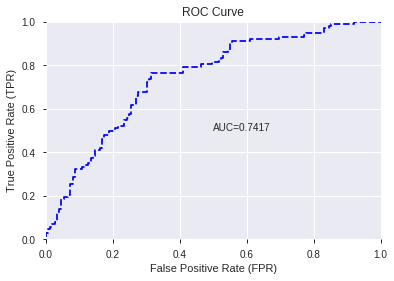

This function is available for GLM models only


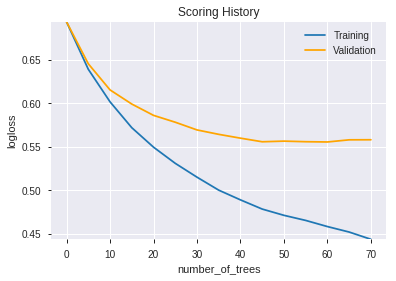

--2019-07-25 05:04:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.238.219
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.238.219|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190725_050350_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190725_050350_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_be36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'STOCHF_fastk',
 'WILLR_12',
 'ULTOSC',
 'WILLR_8',
 'CDLDRAGONFLYDOJI',
 'aroonup_8',
 'CDLCLOSINGMARUBOZU',
 'CCI_8',
 'STOCH_slowd',
 'ATR_30',
 'PLUS_DI_8',
 'MFI_24',
 'MINUS_DM_24',
 'ROC_24',
 'CDLSHORTLINE',
 'CCI_12',
 'ROC_20',
 'CCI_14',
 'WILLR_20',
 'PLUS_DI_12',
 'ROC_30',
 'ROC_8',
 'WILLR_14',
 'WILLR_30',
 'MINUS_DI_12',
 'aroondown_14',
 'STOCH_slowk',
 'aroondown_30',
 'AD',
 'ADOSC',
 'WILLR_24',
 'CCI_20',
 'AROONOSC_24',
 'aroondown_12',
 'CDLENGULFING',
 'ROC_12',
 'CMO_30',
 'MFI_20',
 'PPO',
 'ROCP_24',
 'MINUS_DM_30',
 'ATR_24',
 'BBANDS_upperband_8_4_5',
 'CMO_24',
 'MFI_30',
 'MOM_12',
 'MFI_14',
 'MFI_12',
 'aroondown_24',
 'BBANDS_lowerband_24_5_5',
 'TRIX_12',
 'ATR_20',
 'BBANDS_upperband_30_0_3',
 'aroondown_8',
 'LINEARREG_ANGLE_20',
 'LINEARREG_ANGLE_8',
 'BBANDS_lowerband_12_3_5',
 'ROCP_12',
 'MINUS_DI_30',
 'BBANDS_lowerband_14_3_5',
 'LINEARREG_INTERCEPT_30',
 'BBANDS_upperband_14_4_4',
 'LINEARREG_ANGLE_30',
 'CDLTAKURI',
 'ROC_14',
 'LI

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

114

['BBANDS_middleband_14_4_4',
 'BBANDS_lowerband_14_4_5',
 'MAVP_14_5',
 'BBANDS_middleband_14_5_3',
 'MAVP_14_6',
 'BBANDS_middleband_14_6_3',
 'BBANDS_middleband_14_6_5',
 'BBANDS_lowerband_14_7_5',
 'BBANDS_lowerband_20_0_3',
 'BBANDS_lowerband_20_0_4',
 'BBANDS_lowerband_20_0_5',
 'BBANDS_upperband_20_1_4',
 'BBANDS_lowerband_20_2_3',
 'BBANDS_lowerband_20_2_4',
 'BBANDS_upperband_20_2_5',
 'BBANDS_lowerband_30_1_4',
 'BBANDS_lowerband_30_7_5',
 'BOP',
 'ADX_8',
 'AROONOSC_8',
 'CCI_8',
 'CMO_8',
 'MINUS_DI_8',
 'PLUS_DI_8',
 'PLUS_DM_8',
 'ROC_8',
 'aroondown_12',
 'aroonup_12',
 'CCI_12',
 'CMO_12',
 'DX_12',
 'MFI_12',
 'PLUS_DI_12',
 'ROCP_12',
 'ROCR_12',
 'WILLR_12',
 'ADX_14',
 'aroonup_14',
 'AROONOSC_14',
 'CCI_14',
 'MACDFIX_14',
 'MACDFIX_hist_14',
 'MINUS_DI_14',
 'PLUS_DI_14',
 'ROCR100_14',
 'RSI_14',
 'WILLR_14',
 'aroondown_20',
 'CCI_20',
 'MACDFIX_signal_20',
 'MACDFIX_hist_20',
 'MFI_20',
 'PLUS_DI_20',
 'PLUS_DM_20',
 'ROC_20',
 'ROCR_20',
 'ROCR100_20',
 'WILLR_

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190725_050557_model_4  0.679366  2.008912              0.351527  0.616718  0.380341
1  DeepLearning_grid_1_AutoML_20190725_050557_model_9  0.653573  0.773757              0.387156  0.520516  0.270936
2  DeepLearning_grid_1_AutoML_20190725_050557_model_6  0.638439  0.952470              0.418410  0.532083  0.283112
3  DeepLearning_grid_1_AutoML_20190725_050557_model_3  0.632781  3.549426              0.395414  0.606846  0.368262
4  DeepLearning_grid_1_AutoML_20190725_050557_model_8  0.599026  0.739631              0.455323  0.499577  0.249578
5  DeepLearning_grid_1_AutoML_20190725_050557_model_2  0.596690  5.232127              0.392321  0.693255  0.480602
6  DeepLearning_grid_1_AutoML_20190725_050557_model_1  0.594223  3.650667              0.428741  0.624260  0.389701
7  DeepLearning_grid_1_AutoML_20190725_050557_model_5  0.589354  1.778657              0.407290  0.610613  0.372848
8  DeepLearning_grid_1_AutoML_20190725_050557_model_7  0.577181  2.256157              0.479339  0.614383  0.377466
9               DeepLearning_1_AutoML_20190725_050557  0.510922  3.485278              0.489933  0.634249  0.402272

variable  relative_importance  scaled_importance  percentage
0     BBANDS_lowerband_14_7_5             1.000000           1.000000    0.009440
1                     ROCR_12             0.995411           0.995411    0.009397
2                 MINUS_DI_14             0.980204           0.980204    0.009253
3                     ROCR_20             0.979975           0.979975    0.009251
4      LINEARREG_INTERCEPT_12             0.979523           0.979523    0.009247
..                        ...                  ...                ...         ...
109  BBANDS_middleband_14_5_3             0.873130           0.873130    0.008242
110                 PLUS_DI_8             0.871394           0.871394    0.008226
111                 MACD_hist             0.861690           0.861690    0.008134
112                  TYPPRICE             0.860190           0.860190    0.008120
113           MACDFIX_hist_24             0.851934           0.851934    0.008042

[114 rows x 4 columns]

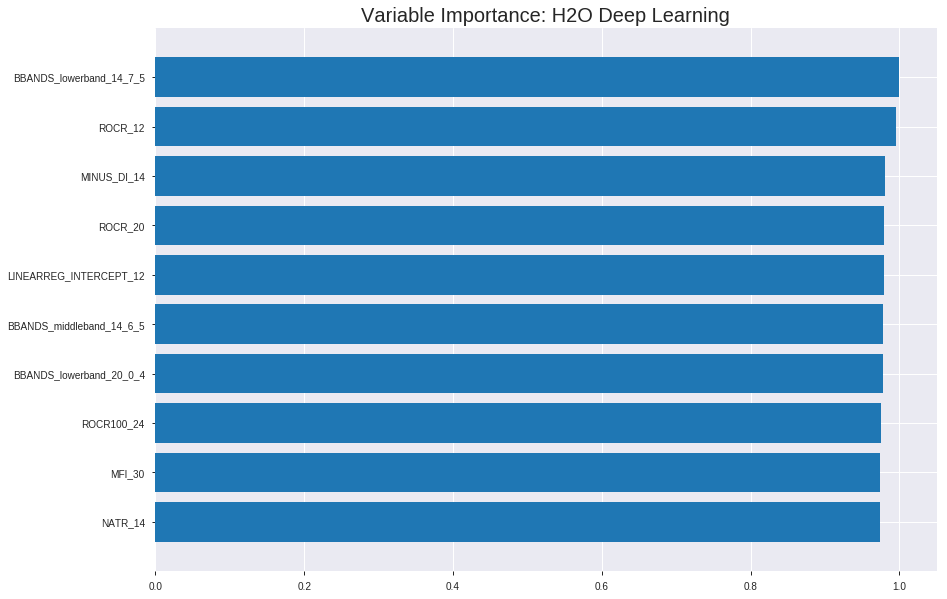

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190725_050557_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.4309861800569819
RMSE: 0.6564953770263595
LogLoss: 2.633297697475248
Mean Per-Class Error: 0.31591257728936195
AUC: 0.7534057056695445
pr_auc: 0.5241700241305998
Gini: 0.5068114113390889
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.9899340463532095: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      450  484   0.5182   (484.0/934.0)
1      117  701   0.143    (117.0/818.0)
Total  567  1185  0.343    (601.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.989934     0.69995   41
max f2                       0.893617     0.825581  155
max f0point5                 0.99958      0.6738    5
max accuracy                 0.99958      0.688356  5
max precision                0.999994     0.812227  0
max recall                   0.0803463    1         372
max specificity              0.999994     0.953961  0
max absolute_mcc             0.99958      0.372686  5
max min_per_class_accuracy   0.998644     0.673448  11
max mean_per_class_accuracy  0.999078     0.684087  8

Gains/Lift Table: Avg response rate: 46.69 %, avg score: 90.88 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    1                  1.54686   1.54686            0.722222         1         0.722222                    1                   0.0158924       0.0158924                  54.6862   54.6862
    2        0.0205479                   1                  1.90383   1.72535            0.888889         1         0.805556                    1                   0.0195599       0.0354523                  90.383    72.5346
    3        0.0302511                   0.999999           1.63785   1.69728            0.764706         0.999999  0.792453                    1                   0.0158924       0.0513447                  63.7854   69.7283
    4        0.0405251                   0.999998           1.90383   1.74965            0.888889         0.999999  0.816901                    0.999999            0.0195599       0.0709046                  90.383    74.9647
    5        0.0502283                   0.999998           1.76384   1.75239            0.823529         0.999998  0.818182                    0.999999            0.0171149       0.0880196                  76.3843   75.2389
    6        0.100457                    0.99999            1.70371   1.72805            0.795455         0.999995  0.806818                    0.999997            0.0855746       0.173594                   70.3712   72.8051
    7        0.150114                    0.999975           1.87101   1.77534            0.873563         0.999983  0.828897                    0.999992            0.0929095       0.266504                   87.1006   77.534
    8        0.200342                    0.999949           1.53334   1.71467            0.715909         0.999964  0.80057                     0.999985            0.0770171       0.343521                   53.3341   71.4668
    9        0.300228                    0.999797           1.30956   1.57989            0.611429         0.999885  0.737643                    0.999952            0.130807        0.474328                   30.9563   57.989
    10       0.400114                    0.99942            1.19941   1.48491            0.56             0.99962   0.693295                    0.999869            0.119804        0.594132                   19.9413   48.4906
    11       0.5                         0.998473           1.01583   1.3912             0.474286         0.99899   0.649543                    0.999693            0.101467        0.695599                   1.58295   39.1198
    12       0.599886                    0.995892           0.917918  1.31239            0.428571         0.997375  0.61275                     0.999307            0.091687        0.787286                   -8.20817  31.2393
    13       0.699772                    0.985427           0.820007  1.24211            0.382857         0.991828  0.579935                    0.99824             0.0819071       0.869193                   -17.9993  24.211
    14       0.799658                    0.934599           0.636423  1.16645            0.297143         0.965841  0.544611                    0.994193            0.0635697       0.932763                   -36.3577  16.6453
    15       0.899543                    0.639148           0.416123  1.08314            0.194286         0.832958  0.505711                    0.976289            0.0415648       0.974328                   -58.3877  8.31358
    16       1                           0.000511912        0.255557  1                  0.119318         0.304737  0.466895                    0.908827            



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.3156239313088256
RMSE: 0.5618041752326388
LogLoss: 2.089048380488142
Mean Per-Class Error: 0.3583349536586946
AUC: 0.6567421738285047
pr_auc: 0.6456392184291082
Gini: 0.3134843476570095
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.7129804383694972e-05: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      16   206  0.9279   (206.0/222.0)
1      3    275  0.0108   (3.0/278.0)
Total  19   481  0.418    (209.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.71298e-05  0.724638  397
max f2                       3.17172e-06  0.863579  398
max f0point5                 0.709789     0.683007  245
max accuracy                 0.709789     0.654     245
max precision                0.999886     0.765625  14
max recall                   2.16386e-07  1         399
max specificity              1            0.954955  0
max absolute_mcc             0.709789     0.290937  245
max min_per_class_accuracy   0.945916     0.617117  189
max mean_per_class_accuracy  0.709789     0.641665  245

Gains/Lift Table: Avg response rate: 55.60 %, avg score: 67.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score       cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        1                  1.07914   1.07914            0.6              1           0.6                         1                   0.0107914       0.0107914                  7.91367   7.91367
    2        0.02                        1                  0.359712  0.719424           0.2              1           0.4                         1                   0.00359712      0.0143885                  -64.0288  -28.0576
    3        0.03                        0.999999           0.719424  0.719424           0.4              1           0.4                         1                   0.00719424      0.0215827                  -28.0576  -28.0576
    4        0.04                        0.999997           1.43885   0.899281           0.8              0.999999    0.5                         1                   0.0143885       0.0359712                  43.8849   -10.0719
    5        0.05                        0.999989           1.43885   1.00719            0.8              0.999994    0.56                        0.999999            0.0143885       0.0503597                  43.8849   0.719424
    6        0.1                         0.999926           1.65468   1.33094            0.92             0.999966    0.74                        0.999982            0.0827338       0.133094                   65.4676   33.0935
    7        0.15                        0.999752           1.22302   1.29496            0.68             0.999859    0.72                        0.999941            0.0611511       0.194245                   22.3022   29.4964
    8        0.2                         0.999217           1.51079   1.34892            0.84             0.999513    0.75                        0.999834            0.0755396       0.269784                   51.0791   34.8921
    9        0.3                         0.995773           1.00719   1.23501            0.56             0.997856    0.686667                    0.999175            0.100719        0.370504                   0.719424  23.5012
    10       0.4                         0.986063           1.18705   1.22302            0.66             0.991678    0.68                        0.997301            0.118705        0.489209                   18.705    22.3022
    11       0.5                         0.958372           1.15108   1.20863            0.64             0.975776    0.672                       0.992996            0.115108        0.604317                   15.1079   20.8633
    12       0.6                         0.798738           1.18705   1.20504            0.66             0.887658    0.67                        0.975439            0.118705        0.723022                   18.705    20.5036
    13       0.7                         0.522794           0.791367  1.14594            0.44             0.66749     0.637143                    0.931447            0.0791367       0.802158                   -20.8633  14.594
    14       0.8                         0.050593           0.683453  1.08813            0.38             0.21289     0.605                       0.841627            0.0683453       0.870504                   -31.6547  8.81295
    15       0.9                         0.000429799        0.647482  1.03917            0.36             0.0132623   0.577778                    0.749587            0.0647482       0.935252                   -35.2518  3.91687
    16       1                           5.83202e-12        0.647482  1                  0.36             7.4494e-05  0.556 


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 05:08:01  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-07-25 05:08:10  10.343 sec        326 obs/sec       1.72146   1             3016       0.656495         2.6333              -0.731535      0.753406        0.52417            1.54686          0.343037                         0.561804           2.08905               -0.278534        0.656742          0.645639             1.07914            0.418
    2019-07-25 05:08:25  25.343 sec        386 obs/sec       5.10388   3             8942       0.524479         1.19929             -0.105158      0.747727        0.726657           2.14181          0.34589                          0.739345           12.3879               -1.2143          0.581178          0.650178             1.79856            0.444
    2019-07-25 05:08:38  38.338 sec        426 obs/sec       8.51826   5             14924      0.467591         0.795472            0.121583       0.765602        0.753697           2.14181          0.310502                         0.739896           12.3774               -1.2176          0.580344          0.651023             1.79856            0.444
    2019-07-25 05:08:51  51.335 sec        444 obs/sec       11.9264   7             20895      0.43722          0.633838            0.231988       0.81139         0.794147           2.14181          0.285388                         0.728534           11.3074               -1.15002         0.585594          0.657009             1.79856            0.444
    2019-07-25 05:09:02  1 min  2.305 sec  473 obs/sec       15.3721   9             26932      0.404828         0.513194            0.341571       0.84745         0.825055           2.14181          0.248288                         0.712406           9.35726               -1.05588         0.58113           0.648866             1.43885            0.444
    2019-07-25 05:09:17  1 min 16.836 sec  510 obs/sec       20.5166   12            35945      0.34899          0.381259            0.51068        0.913516        0.896354           2.14181          0.167237                         0.685401           5.06785               -0.902971        0.606318          0.666419             1.79856            0.444
    2019-07-25 05:09:30  1 min 30.368 sec  541 obs/sec       25.645    15            44930      0.341572         0.369393            0.53126        0.918461        0.883491           2.14181          0.158105                         0.71047            8.03512               -1.04472         0.582086          0.654321             1.43885            0.444
    2019-07-25 05:09:43  1 min 43.384 sec  568 obs/sec       30.7751   18            53918      0.310338         0.311894            0.613065       0.940882        0.904334           2.14181          0.134132                         0.690691           5.18888               -0.932459        0.572064          0.63375              1.43885            0.444
    2019-07-25 05:09:56  1 min 56.337 sec  589 

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  --------------------
BBANDS_lowerband_14_7_5   1.0                    1.0                  0.009440038300010431
ROCR_12                   0.9954109787940979     0.9954109787940979   0.009396717764067156
MINUS_DI_14               0.9802043437957764     0.9802043437957764   0.009253166547268722
ROCR_20                   0.9799750447273254     0.9799750447273254   0.009251001955280388
LINEARREG_INTERCEPT_12    0.9795225262641907     0.9795225262641907   0.009246730163656933
---                       ---                    ---                  ---
BBANDS_middleband_14_5_3  0.8731299042701721     0.8731299042701721   0.008242379737194867
PLUS_DI_8                 0.8713940978050232     0.8713940978050232   0.008225993657682455
MACD_hist                 0.8616902232170105     0.8616902232170105   0.008134388709913117
TYPPRICE                  0.8601899147033691     0.8601899147033691   0.008120225740082511
MACDFIX_hist_24           0.8519344925880432     0.8519344925880432   0.008042294239131081


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.6533864541832669)

('F1', 0.633587786259542)

('auc', 0.6793657060139492)

('logloss', 2.008912065603833)

('mean_per_class_error', 0.35152651664692725)

('rmse', 0.6167178621205445)

('mse', 0.3803409214585349)

deeplearning prediction progress: |███████████████████████████████████████| 100%


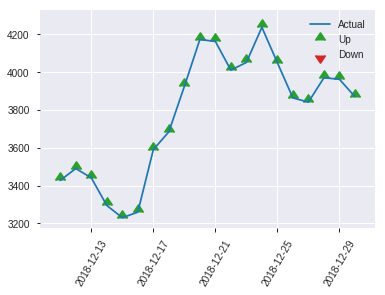


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3803409214585349
RMSE: 0.6167178621205445
LogLoss: 2.008912065603833
Mean Per-Class Error: 0.35152651664692725
AUC: 0.6793657060139492
pr_auc: 0.5885403293580324
Gini: 0.3587314120278984
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.8425252480059416: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      72   77   0.5168   (77.0/149.0)
1      19   83   0.1863   (19.0/102.0)
Total  91   160  0.3825   (96.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.842525     0.633588  159
max f2                       0.00169206   0.789474  237
max f0point5                 0.997455     0.559701  74
max accuracy                 0.997601     0.653386  72
max precision                0.999999     1         0
max recall                   0.00169206   1         237
max specificity              0.999999     1         0
max absolute_mcc             0.842525     0.303383  159
max min_per_class_accuracy   0.975063     0.61745   119
max mean_per_class_accuracy  0.842525     0.648473  159

Gains/Lift Table: Avg response rate: 40.64 %, avg score: 71.28 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.999996           2.46078   2.46078            1                0.999998   1                           0.999998            0.0294118       0.0294118                  146.078   146.078
    2        0.0239044                   0.999976           1.64052   2.05065            0.666667         0.999984   0.833333                    0.999991            0.0196078       0.0490196                  64.0523   105.065
    3        0.0318725                   0.99997            2.46078   2.15319            1                0.999974   0.875                       0.999987            0.0196078       0.0686275                  146.078   115.319
    4        0.0438247                   0.999961           2.46078   2.23708            1                0.999964   0.909091                    0.99998             0.0294118       0.0980392                  146.078   123.708
    5        0.0517928                   0.999938           1.23039   2.0822             0.5              0.999954   0.846154                    0.999976            0.00980392      0.107843                   23.0392   108.22
    6        0.103586                    0.999837           1.51433   1.79827            0.615385         0.99988    0.730769                    0.999928            0.0784314       0.186275                   51.4329   79.8265
    7        0.151394                    0.999723           1.23039   1.61894            0.5              0.999794   0.657895                    0.999886            0.0588235       0.245098                   23.0392   61.8937
    8        0.203187                    0.999309           1.32504   1.54402            0.538462         0.999524   0.627451                    0.999793            0.0686275       0.313725                   32.5038   54.4022
    9        0.302789                    0.997401           1.27961   1.45704            0.52             0.998505   0.592105                    0.99937             0.127451        0.441176                   27.9608   45.7043
    10       0.40239                     0.992739           0.885882  1.31567            0.36             0.995406   0.534653                    0.998388            0.0882353       0.529412                   -11.4118  31.5667
    11       0.501992                    0.971016           1.27961   1.30851            0.52             0.980966   0.531746                    0.994932            0.127451        0.656863                   27.9608   30.8512
    12       0.601594                    0.884971           0.885882  1.23854            0.36             0.936751   0.503311                    0.985299            0.0882353       0.745098                   -11.4118  23.854
    13       0.701195                    0.603503           0.984314  1.20243            0.4              0.774419   0.488636                    0.955345            0.0980392       0.843137                   -1.56863  20.2429
    14       0.800797                    0.168017           0.68902   1.13857            0.28             0.3495     0.462687                    0.879991            0.0686275       0.911765                   -31.098   13.8572
    15       0.900398                    0.0232104          0.492157  1.06707            0.2              0.0773363  0.433628                    0.791202            0.0490196       0.960784                   -50.7843  6.70658
    16       1                           1.63011e-07        0.393725  1                  0.16             0.0036639  0.406375                    0

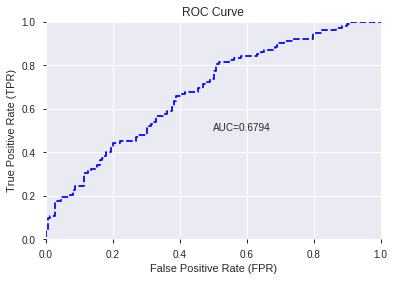

This function is available for GLM models only


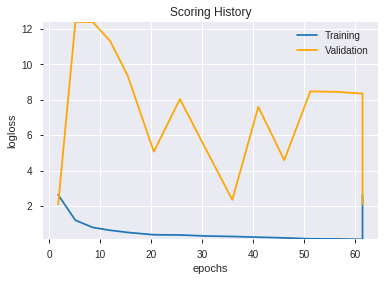

--2019-07-25 05:21:30--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.101.203
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.101.203|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190725_050557_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190725_050557_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_be36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['BBANDS_lowerband_14_7_5',
 'ROCR_12',
 'MINUS_DI_14',
 'ROCR_20',
 'LINEARREG_INTERCEPT_12',
 'BBANDS_middleband_14_6_5',
 'BBANDS_lowerband_20_0_4',
 'ROCR100_24',
 'MFI_30',
 'NATR_14',
 'BOP',
 'BBANDS_lowerband_20_0_5',
 'CDLLONGLINE',
 'aroondown_20',
 'CORREL_12',
 'ROCR100_20',
 'LINEARREG_ANGLE_12',
 'CDLHIKKAKE',
 'CORREL_14',
 'aroonup_24',
 'PLUS_DM_20',
 'CMO_24',
 'TRANGE',
 'CDLBELTHOLD',
 'BETA_14',
 'ROC_24',
 'AROONOSC_8',
 'WILLR_14',
 'ROC_30',
 'ULTOSC',
 'BETA_8',
 'BBANDS_lowerband_30_1_4',
 'LINEARREG_ANGLE_14',
 'CDLSHORTLINE',
 'MACDFIX_hist_20',
 'MFI_20',
 'RSI_24',
 'STOCHF_fastd',
 'CDLDRAGONFLYDOJI',
 'BETA_12',
 'PLUS_DM_8',
 'BBANDS_middleband_14_4_4',
 'WILLR_12',
 'CMO_12',
 'CDLHAMMER',
 'HT_PHASOR_inphase',
 'ADX_8',
 'MAVP_14_5',
 'CCI_8',
 'MACDFIX_hist_14',
 'aroonup_14',
 'BBANDS_lowerband_20_2_4',
 'DX_12',
 'ATR_12',
 'CCI_30',
 'OBV',
 'BBANDS_lowerband_20_0_3',
 'BBANDS_middleband_14_6_3',
 'MINUS_DI_30',
 'AROONOSC_24',
 'PLUS_DI_12',
 'ST

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  GLM_grid_1_AutoML_20190725_052135_model_1  0.560074  0.781084              0.478056  0.530225  0.281138

variable  relative_importance  scaled_importance  percentage
0                   BOP             0.009106           1.000000    0.035913
1          STOCHF_fastk             0.006453           0.708695    0.025452
2           CDLLONGLINE             0.005859           0.643468    0.023109
3    CDLCLOSINGMARUBOZU             0.005786           0.635383    0.022819
4                ULTOSC             0.005237           0.575153    0.020656
..                  ...                  ...                ...         ...
109     MACDFIX_hist_20             0.000247           0.027165    0.000976
110             BETA_14             0.000109           0.011968    0.000430
111      CDLSPINNINGTOP             0.000083           0.009147    0.000328
112           CORREL_14             0.000045           0.004890    0.000176
113   HT_PHASOR_inphase             0.000023           0.002505    0.000090

[114 rows x 4 columns]

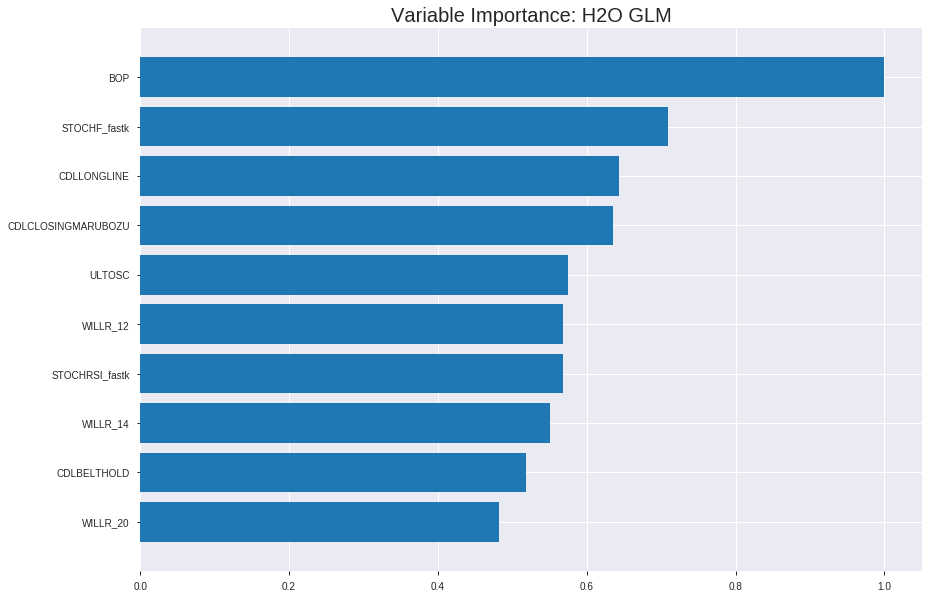

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190725_052135_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.23973621659108735
RMSE: 0.4896286517260682
LogLoss: 0.6724830106472066
Null degrees of freedom: 1751
Residual degrees of freedom: 1637
Null deviance: 2421.1017340295916
Residual deviance: 2356.380469307812
AIC: 2586.380469307812
AUC: 0.6631898451856777
pr_auc: 0.6293986060687536
Gini: 0.3263796903713554
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4254531399693778: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      173  761   0.8148   (761.0/934.0)
1      53   765   0.0648   (53.0/818.0)
Total  226  1526  0.4646   (814.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.425453     0.65273   330
max f2                       0.385261     0.814417  397
max f0point5                 0.467282     0.593552  204
max accuracy                 0.475956     0.623858  177
max precision                0.585015     1         0
max recall                   0.385261     1         397
max specificity              0.585015     1         0
max absolute_mcc             0.453629     0.242211  247
max min_per_class_accuracy   0.464846     0.612469  211
max mean_per_class_accuracy  0.467282     0.6188    204

Gains/Lift Table: Avg response rate: 46.69 %, avg score: 46.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.552359           1.90383   1.90383            0.888889         0.562067  0.888889                    0.562067            0.0195599       0.0195599                  90.383    90.383
    2        0.0205479                   0.545512           1.42787   1.66585            0.666667         0.548358  0.777778                    0.555213            0.0146699       0.0342298                  42.7873   66.5852
    3        0.0302511                   0.542737           2.01582   1.77811            0.941176         0.543969  0.830189                    0.551606            0.0195599       0.0537897                  101.582   77.8106
    4        0.0405251                   0.537241           1.66585   1.74965            0.777778         0.539372  0.816901                    0.548504            0.0171149       0.0709046                  66.5852   74.9647
    5        0.0502283                   0.532908           1.51187   1.70371            0.705882         0.534766  0.795455                    0.54585             0.0146699       0.0855746                  51.1865   70.3712
    6        0.100457                    0.517373           1.43599   1.56985            0.670455         0.523886  0.732955                    0.534868            0.0721271       0.157702                   43.5986   56.9849
    7        0.150114                    0.508069           1.47711   1.53917            0.689655         0.512531  0.718631                    0.527479            0.0733496       0.231051                   47.711    53.9171
    8        0.200342                    0.500477           1.21694   1.45838            0.568182         0.503782  0.680912                    0.521538            0.0611247       0.292176                   21.6937   45.8383
    9        0.300228                    0.484615           1.1627    1.36001            0.542857         0.492163  0.634981                    0.511765            0.116137        0.408313                   16.2696   36.0008
    10       0.400114                    0.473388           1.12598   1.30158            0.525714         0.47905   0.607703                    0.503598            0.112469        0.520782                   12.598    30.1585
    11       0.5                         0.463814           1.00359   1.24205            0.468571         0.468761  0.579909                    0.496639            0.100244        0.621027                   0.359064  24.2054
    12       0.599886                    0.45482            1.01583   1.20439            0.474286         0.459148  0.562322                    0.490396            0.101467        0.722494                   1.58295   20.4386
    13       0.699772                    0.444867           0.78329   1.14428            0.365714         0.44983   0.534258                    0.484606            0.0782396       0.800733                   -21.671   14.4278
    14       0.799658                    0.434705           0.820007  1.10377            0.382857         0.439642  0.515346                    0.478989            0.0819071       0.882641                   -17.9993  10.3773
    15       0.899543                    0.421252           0.709857  1.06003            0.331429         0.428272  0.494924                    0.473358            0.0709046       0.953545                   -29.0143  6.00325
    16       1                           0.381962           0.462436  1                  0.215909         0.409025  0.466895                    0.466895          



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.3083345182219127
RMSE: 0.5552787752308859
LogLoss: 0.854146171163289
Null degrees of freedom: 499
Residual degrees of freedom: 385
Null deviance: 702.7702737716033
Residual deviance: 854.1461711632887
AIC: 1084.1461711632887
AUC: 0.5891746062609372
pr_auc: 0.6366475999517339
Gini: 0.1783492125218744
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.10337546272746344: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      36   186  0.8378   (186.0/222.0)
1      16   262  0.0576   (16.0/278.0)
Total  52   448  0.404    (202.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.103375     0.721763  355
max f2                       0.0477931    0.866044  394
max f0point5                 0.162194     0.636612  303
max accuracy                 0.162194     0.6       303
max precision                0.516875     1         0
max recall                   0.0477931    1         394
max specificity              0.516875     1         0
max absolute_mcc             0.108765     0.17342   350
max min_per_class_accuracy   0.335429     0.536036  187
max mean_per_class_accuracy  0.402092     0.570808  119

Gains/Lift Table: Avg response rate: 55.60 %, avg score: 30.68 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.498689           1.07914   1.07914            0.6              0.506578   0.6                         0.506578            0.0107914       0.0107914                  7.91367   7.91367
    2        0.02                        0.487856           1.43885   1.25899            0.8              0.496467   0.7                         0.501522            0.0143885       0.0251799                  43.8849   25.8993
    3        0.03                        0.485748           1.43885   1.31894            0.8              0.486777   0.733333                    0.496607            0.0143885       0.0395683                  43.8849   31.8945
    4        0.04                        0.483832           1.43885   1.34892            0.8              0.484744   0.75                        0.493641            0.0143885       0.0539568                  43.8849   34.8921
    5        0.05                        0.479687           1.43885   1.36691            0.8              0.48305    0.76                        0.491523            0.0143885       0.0683453                  43.8849   36.6906
    6        0.1                         0.465646           1.36691   1.36691            0.76             0.47213    0.76                        0.481827            0.0683453       0.136691                   36.6906   36.6906
    7        0.15                        0.456416           1.22302   1.31894            0.68             0.460378   0.733333                    0.474677            0.0611511       0.197842                   22.3022   31.8945
    8        0.2                         0.446242           1.07914   1.25899            0.6              0.451027   0.7                         0.468765            0.0539568       0.251799                   7.91367   25.8993
    9        0.3                         0.419523           1.00719   1.17506            0.56             0.431193   0.653333                    0.456241            0.100719        0.352518                   0.719424  17.506
    10       0.4                         0.380092           0.935252  1.11511            0.52             0.400368   0.62                        0.442273            0.0935252       0.446043                   -6.47482  11.5108
    11       0.5                         0.336057           0.863309  1.06475            0.48             0.357736   0.592                       0.425365            0.0863309       0.532374                   -13.6691  6.47482
    12       0.6                         0.291878           1.04317   1.06115            0.58             0.319098   0.59                        0.407654            0.104317        0.636691                   4.31655   6.11511
    13       0.7                         0.210277           1.04317   1.05858            0.58             0.252406   0.588571                    0.385476            0.104317        0.741007                   4.31655   5.85817
    14       0.8                         0.147162           1.15108   1.07014            0.64             0.178574   0.595                       0.359613            0.115108        0.856115                   15.1079   7.01439
    15       0.9                         0.102284           0.863309  1.04716            0.48             0.127016   0.582222                    0.333769            0.0863309       0.942446                   -13.6691  4.71623
    16       1                           0.0430315          0.57554   1                  0.32             0.0638985  0.556                       


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-07-25 05:21:36  0.000 sec   2            20        115           1.34497           1.70829
    2019-07-25 05:21:36  0.036 sec   4            14        115           1.33685           1.84355
    2019-07-25 05:21:36  0.072 sec   6            10        115           1.32795           2.01224
    2019-07-25 05:21:36  0.106 sec   8            7.6       115           1.31828           2.20583
    2019-07-25 05:21:36  0.144 sec   10           5.5       115           1.30782           2.41789

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.601593625498008)

('F1', 0.5872093023255814)

('auc', 0.560073693907093)

('logloss', 0.7810837095244072)

('mean_per_class_error', 0.4180813264903276)

('rmse', 0.5302248553493113)

('mse', 0.2811383972301981)

glm prediction progress: |████████████████████████████████████████████████| 100%


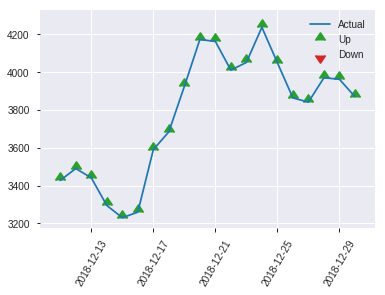


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2811383972301981
RMSE: 0.5302248553493113
LogLoss: 0.7810837095244072
Null degrees of freedom: 250
Residual degrees of freedom: 136
Null deviance: 342.8297670320054
Residual deviance: 392.10402218125233
AIC: 622.1040221812523
AUC: 0.560073693907093
pr_auc: 0.43687282083812623
Gini: 0.1201473878141861
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13106327428586953: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      8    141  0.9463   (141.0/149.0)
1      1    101  0.0098   (1.0/102.0)
Total  9    242  0.5657   (142.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.131063     0.587209  241
max f2                       0.131063     0.776923  241
max f0point5                 0.198041     0.504587  137
max accuracy                 0.317462     0.601594  5
max precision                0.317462     0.666667  5
max recall                   0.126503     1         248
max specificity              0.330825     0.993289  0
max absolute_mcc             0.198041     0.161744  137
max min_per_class_accuracy   0.201544     0.558824  121
max mean_per_class_accuracy  0.198041     0.581919  137

Gains/Lift Table: Avg response rate: 40.64 %, avg score: 20.48 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.322847           0.820261  0.820261           0.333333         0.327108  0.333333                    0.327108            0.00980392      0.00980392                 -17.9739  -17.9739
    2        0.0239044                   0.317462           2.46078   1.64052            1                0.319418  0.666667                    0.323263            0.0294118       0.0392157                  146.078   64.0523
    3        0.0318725                   0.312874           0         1.23039            0                0.314937  0.5                         0.321182            0               0.0392157                  -100      23.0392
    4        0.0438247                   0.308054           0.820261  1.11854            0.333333         0.310098  0.454545                    0.318159            0.00980392      0.0490196                  -17.9739  11.8538
    5        0.0517928                   0.296964           0         0.946456           0                0.301136  0.384615                    0.31554             0               0.0490196                  -100      -5.35445
    6        0.103586                    0.278496           1.13575   1.0411             0.461538         0.286303  0.423077                    0.300921            0.0588235       0.107843                   13.5747   4.11011
    7        0.151394                    0.238042           0.615196  0.906605           0.25             0.262698  0.368421                    0.288851            0.0294118       0.137255                   -38.4804  -9.33953
    8        0.203187                    0.223437           1.32504   1.01326            0.538462         0.228359  0.411765                    0.273431            0.0686275       0.205882                   32.5038   1.32641
    9        0.302789                    0.214954           1.27961   1.10088            0.52             0.218609  0.447368                    0.255397            0.127451        0.333333                   27.9608   10.0877
    10       0.40239                     0.204573           1.37804   1.16948            0.56             0.209049  0.475248                    0.243925            0.137255        0.470588                   37.8039   16.9482
    11       0.501992                    0.200354           0.984314  1.13274            0.4              0.202613  0.460317                    0.235728            0.0980392       0.568627                   -1.56863  13.2742
    12       0.601594                    0.193828           1.08275   1.12446            0.44             0.197261  0.456954                    0.22936             0.107843        0.676471                   8.27451   12.4464
    13       0.701195                    0.184922           0.885882  1.09057            0.36             0.18908   0.443182                    0.223638            0.0882353       0.764706                   -11.4118  9.05749
    14       0.800797                    0.173352           0.590588  1.02839            0.24             0.179532  0.41791                     0.218152            0.0588235       0.823529                   -40.9412  2.83875
    15       0.900398                    0.157322           1.08275   1.0344             0.44             0.165695  0.420354                    0.212349            0.107843        0.931373                   8.27451   3.44005
    16       1                           0.117316           0.68902   1                  0.28             0.137009  0.406375                    0.204845      

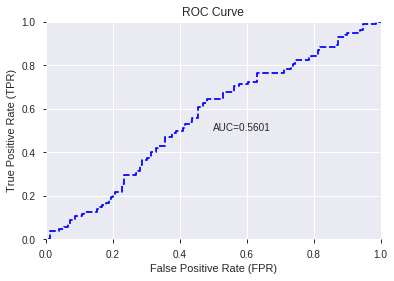

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


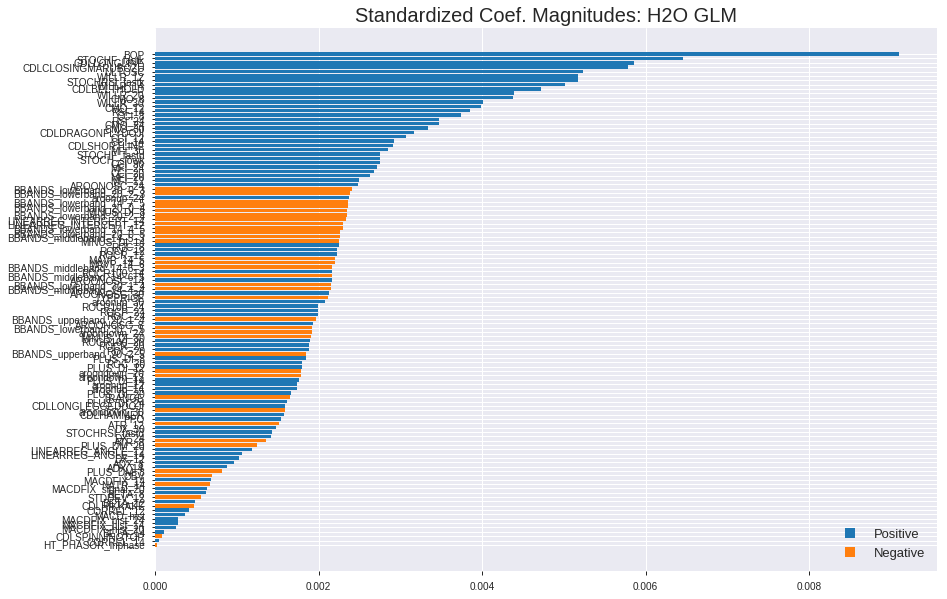

'log_likelihood'
--2019-07-25 05:21:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.107.108
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.107.108|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190725_052135_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190725_052135_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_be36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'STOCHF_fastk',
 'CDLLONGLINE',
 'CDLCLOSINGMARUBOZU',
 'ULTOSC',
 'WILLR_12',
 'STOCHRSI_fastk',
 'WILLR_14',
 'CDLBELTHOLD',
 'WILLR_20',
 'CMO_8',
 'WILLR_30',
 'CMO_12',
 'RSI_14',
 'CCI_8',
 'RSI_24',
 'CMO_24',
 'CMO_30',
 'CDLDRAGONFLYDOJI',
 'CCI_12',
 'CCI_14',
 'CDLSHORTLINE',
 'MFI_30',
 'STOCHF_fastd',
 'STOCH_slowk',
 'CCI_30',
 'MFI_24',
 'CCI_20',
 'MFI_20',
 'MFI_12',
 'AROONOSC_24',
 'BBANDS_lowerband_20_0_3',
 'BBANDS_lowerband_20_2_3',
 'aroonup_24',
 'BBANDS_lowerband_14_7_5',
 'BBANDS_lowerband_20_0_4',
 'MINUS_DI_8',
 'BBANDS_lowerband_20_2_4',
 'LINEARREG_INTERCEPT_14',
 'LINEARREG_INTERCEPT_12',
 'BBANDS_lowerband_14_4_5',
 'BBANDS_lowerband_20_0_5',
 'BBANDS_middleband_14_5_3',
 'MINUS_DI_14',
 'ROC_8',
 'ROCP_12',
 'ROCR_12',
 'MAVP_14_5',
 'MAVP_14_6',
 'BBANDS_middleband_14_6_3',
 'ROCR100_14',
 'BBANDS_middleband_14_6_5',
 'AROONOSC_14',
 'BBANDS_lowerband_30_1_4',
 'BBANDS_middleband_14_4_4',
 'AROONOSC_30',
 'TYPPRICE',
 'aroonup_30',
 'ROCR100_2

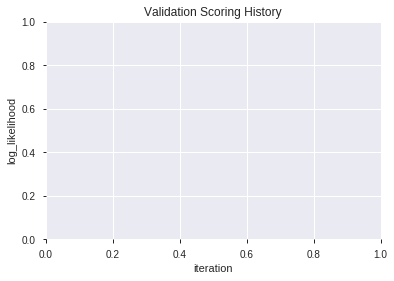

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_3_AutoML_20190725_052150  0.727662  0.627399              0.313857  0.468661  0.219643
1  XGBoost_grid_1_AutoML_20190725_052150_model_6  0.723714  0.622066              0.316686  0.465411  0.216607
2               XGBoost_1_AutoML_20190725_052150  0.722463  0.618794              0.327510  0.463309  0.214655
3  XGBoost_grid_1_AutoML_20190725_052150_model_2  0.715884  0.625374              0.317969  0.468087  0.219106
4  XGBoost_grid_1_AutoML_20190725_052150_model_7  0.715489  0.637443              0.300171  0.473220  0.223937
5  XGBoost_grid_1_AutoML_20190725_052150_model_4  0.715028  0.635502              0.317969  0.471852  0.222645
6  XGBoost_grid_1_AutoML_20190725_052150_model_1  0.714765  0.627731              0.311258  0.467292  0.218362
7  XGBoost_grid_1_AutoML_20190725_052150_model_3  0.714634  0.628644              0.319779  0.469011  0.219971
8               XGBoost_2_AutoML_20190725_052150  0.698250  0.641512              0.304283  0.473604  0.224301
9  XGBoost_grid_1_AutoML_20190725_052150_model_5  0.690815  0.630440              0.366232  0.468017  0.219040

variable  relative_importance  scaled_importance  percentage
0                        BOP          1897.151611           1.000000    0.215732
1               STOCHF_fastk           919.402283           0.484622    0.104549
2                     TRANGE           494.510895           0.260660    0.056233
3                   WILLR_12           490.097870           0.258334    0.055731
4                    NATR_14           237.075531           0.124964    0.026959
..                       ...                  ...                ...         ...
107  BBANDS_lowerband_20_0_4             2.273320           0.001198    0.000259
108               ROCR100_20             1.467227           0.000773    0.000167
109               aroonup_30             1.273945           0.000672    0.000145
110               CDLHIKKAKE             1.175957           0.000620    0.000134
111              CDLLONGLINE             0.013288           0.000007    0.000002

[112 rows x 4 columns]

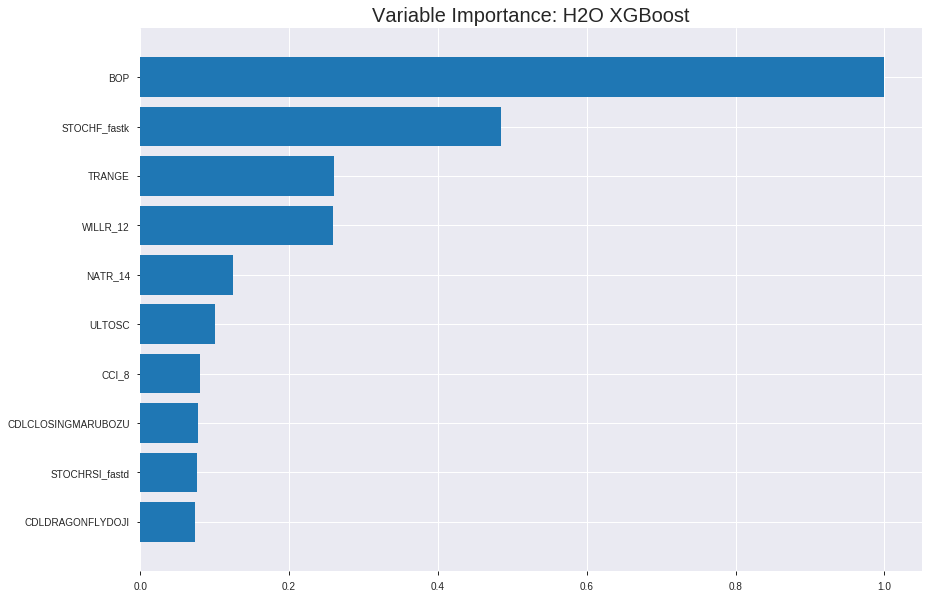

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_3_AutoML_20190725_052150


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.13295053788244204
RMSE: 0.364623830656256
LogLoss: 0.4289756376100448
Mean Per-Class Error: 0.1506455395988544
AUC: 0.930554101244483
pr_auc: 0.9250271747309362
Gini: 0.861108202488966
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5034506519635519: 


0    1    Error    Rate
-----  ---  ---  -------  --------------
0      833  101  0.1081   (101.0/934.0)
1      158  660  0.1932   (158.0/818.0)
Total  991  761  0.1478   (259.0/1752.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.503451     0.835972  188
max f2                       0.353449     0.895354  268
max f0point5                 0.561989     0.873549  157
max accuracy                 0.503451     0.852169  188
max precision                0.957309     1         0
max recall                   0.120174     1         374
max specificity              0.957309     1         0
max absolute_mcc             0.503451     0.703262  188
max min_per_class_accuracy   0.477988     0.837408  202
max mean_per_class_accuracy  0.503451     0.849354  188

Gains/Lift Table: Avg response rate: 46.69 %, avg score: 46.83 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.010274                    0.935094           2.14181    2.14181            1                0.946061  1                           0.946061            0.0220049       0.0220049                  114.181   114.181
    2        0.0205479                   0.92145            2.14181    2.14181            1                0.928965  1                           0.937513            0.0220049       0.0440098                  114.181   114.181
    3        0.0302511                   0.912276           2.14181    2.14181            1                0.916725  1                           0.930845            0.0207824       0.0647922                  114.181   114.181
    4        0.0405251                   0.901224           2.14181    2.14181            1                0.907029  1                           0.924807            0.0220049       0.0867971                  114.181   114.181
    5        0.0502283                   0.889965           2.14181    2.14181            1                0.893516  1                           0.918762            0.0207824       0.107579                   114.181   114.181
    6        0.100457                    0.80819            2.11747    2.12964            0.988636         0.854561  0.994318                    0.886662            0.106357        0.213936                   111.747   112.964
    7        0.150114                    0.731418           2.09257    2.11738            0.977011         0.764169  0.988593                    0.846141            0.103912        0.317848                   109.257   111.738
    8        0.200342                    0.683384           1.9471     2.07469            0.909091         0.708335  0.968661                    0.811592            0.0977995       0.415648                   94.7099   107.469
    9        0.300228                    0.598104           2.03166    2.06037            0.948571         0.638064  0.961977                    0.753859            0.202934        0.618582                   103.166   106.037
    10       0.400114                    0.527347           1.45643    1.9096             0.68             0.561728  0.891583                    0.705895            0.145477        0.764059                   45.643    90.9602
    11       0.5                         0.465274           0.954635   1.71883            0.445714         0.494235  0.802511                    0.663611            0.0953545       0.859413                   -4.5365   71.8826
    12       0.599886                    0.388954           0.758812   1.55898            0.354286         0.426453  0.727878                    0.624122            0.0757946       0.935208                   -24.1188  55.8976
    13       0.699772                    0.324651           0.440601   1.39934            0.205714         0.358381  0.653344                    0.58619             0.0440098       0.979218                   -55.9399  39.9339
    14       0.799658                    0.244021           0.122389   1.23983            0.0571429        0.284169  0.578872                    0.548465            0.0122249       0.991443                   -87.7611  23.9834
    15       0.899543                    0.13821            0.0734335  1.11032            0.0342857        0.188839  0.518401                    0.508531            0.00733496      0.998778                   -92.6567  11.0316
    16       1                           0.0654186          0.0121694  1                  0.00568182       0.107838  0.466895                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.20051732522733404
RMSE: 0.44779160915244276
LogLoss: 0.5785421032681236
Mean Per-Class Error: 0.27989500291658564
AUC: 0.7944779311685787
pr_auc: 0.8213522577594501
Gini: 0.5889558623371574
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.28077325224876404: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      102  120  0.5405   (120.0/222.0)
1      23   255  0.0827   (23.0/278.0)
Total  125  375  0.286    (143.0/500.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.280773     0.781011  301
max f2                       0.13756      0.880846  363
max f0point5                 0.452263     0.764014  175
max accuracy                 0.369704     0.726     237
max precision                0.940129     1         0
max recall                   0.102262     1         386
max specificity              0.940129     1         0
max absolute_mcc             0.369704     0.44179   237
max min_per_class_accuracy   0.398687     0.716216  216
max mean_per_class_accuracy  0.417129     0.720105  200

Gains/Lift Table: Avg response rate: 55.60 %, avg score: 43.69 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.01                        0.928585           1.79856   1.79856            1                0.934198  1                           0.934198            0.0179856       0.0179856                  79.8561   79.8561
    2        0.02                        0.919572           1.79856   1.79856            1                0.925803  1                           0.930001            0.0179856       0.0359712                  79.8561   79.8561
    3        0.03                        0.916779           1.79856   1.79856            1                0.91885   1                           0.926284            0.0179856       0.0539568                  79.8561   79.8561
    4        0.04                        0.908522           1.79856   1.79856            1                0.912401  1                           0.922813            0.0179856       0.0719424                  79.8561   79.8561
    5        0.05                        0.898592           1.43885   1.72662            0.8              0.903121  0.96                        0.918875            0.0143885       0.0863309                  43.8849   72.6619
    6        0.1                         0.820657           1.65468   1.69065            0.92             0.874556  0.94                        0.896715            0.0827338       0.169065                   65.4676   69.0647
    7        0.15                        0.687171           1.58273   1.65468            0.88             0.770297  0.92                        0.854576            0.0791367       0.248201                   58.2734   65.4676
    8        0.2                         0.594758           1.36691   1.58273            0.76             0.644497  0.88                        0.802056            0.0683453       0.316547                   36.6906   58.2734
    9        0.3                         0.519351           1.36691   1.51079            0.76             0.555463  0.84                        0.719858            0.136691        0.453237                   36.6906   51.0791
    10       0.4                         0.459922           1.33094   1.46583            0.74             0.489458  0.815                       0.662258            0.133094        0.586331                   33.0935   46.5827
    11       0.5                         0.412638           1.07914   1.38849            0.6              0.434596  0.772                       0.616726            0.107914        0.694245                   7.91367   38.8489
    12       0.6                         0.36487            0.971223  1.31894            0.54             0.390551  0.733333                    0.57903             0.0971223       0.791367                   -2.8777   31.8945
    13       0.7                         0.310216           0.755396  1.23844            0.42             0.338067  0.688571                    0.544607            0.0755396       0.866906                   -24.4604  23.8438
    14       0.8                         0.229768           0.755396  1.17806            0.42             0.274431  0.655                       0.510835            0.0755396       0.942446                   -24.4604  17.8058
    15       0.9                         0.136367           0.467626  1.09912            0.26             0.174511  0.611111                    0.473465            0.0467626       0.989209                   -53.2374  9.91207
    16       1                           0.0754479          0.107914  1                  0.06             0.108184  0.556                       0.436937         


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-07-25 05:21:55  0.004 sec   0                  0.5              0.693147            0.5             0                  1                0.533105                         0.5                0.693147              0.5               0                    1                  0.444
    2019-07-25 05:21:55  0.102 sec   5                  0.473768         0.641677            0.837113        0.759723           2.14181          0.247717                         0.479254           0.652125              0.768164          0.725042             1.79856            0.288
    2019-07-25 05:21:55  0.227 sec   10                 0.453328         0.602223            0.855628        0.817804           2.14181          0.230594                         0.464952           0.623615              0.783233          0.783918             1.79856            0.28
    2019-07-25 05:21:55  0.279 sec   15                 0.440086         0.576493            0.86173         0.849194           2.14181          0.229452                         0.459334           0.61182               0.782552          0.811519             1.79856            0.284
    2019-07-25 05:21:55  0.331 sec   20                 0.428391         0.553318            0.86916         0.859038           2.14181          0.228311                         0.453124           0.598088              0.786093          0.814638             1.79856            0.284
    2019-07-25 05:21:55  0.387 sec   25                 0.417737         0.532285            0.879131        0.86942            2.14181          0.218037                         0.449825           0.590202              0.792412          0.819274             1.79856            0.276
    2019-07-25 05:21:55  0.442 sec   30                 0.409319         0.515198            0.886056        0.876318           2.14181          0.209475                         0.447718           0.584407              0.79413           0.819408             1.79856            0.268
    2019-07-25 05:21:55  0.503 sec   35                 0.401252         0.49886             0.893148        0.884118           2.14181          0.211187                         0.44682            0.580705              0.793117          0.818443             1.79856            0.268
    2019-07-25 05:21:55  0.561 sec   40                 0.393292         0.483172            0.901668        0.89343            2.14181          0.194635                         0.44652            0.578957              0.79191           0.817437             1.79856            0.278
    2019-07-25 05:21:55  0.620 sec   45                 0.386726         0.470549            0.909115        0.902229           2.14181          0.184932                         0.446652           0.578098              0.79387           0.819397             1.79856            0.278
    2019-07-25 05:21:55  0.690 sec   50                 0.381024         0.459082            0.913453        0.905925           2.14181          0.188927                         0.445776           0.575782              0.793579          0.820402             1.79856            0.286
    2019-07-25 05:21:56  0.767 sec   55                 0.374407         0.446805            0.921177        0.914281           2.14181          0.177511                         0.446451           0.576603              0.794713          0.820918             1.79856       

Variable Importances: 


variable                 relative_importance    scaled_importance      percentage
-----------------------  ---------------------  ---------------------  ----------------------
BOP                      1897.151611328125      1.0                    0.21573245879516986
STOCHF_fastk             919.4022827148438      0.4846224609698982     0.10454879509240238
TRANGE                   494.5108947753906      0.26065966042070937    0.05623274945127365
WILLR_12                 490.0978698730469      0.2583335285101161     0.05573092729471946
NATR_14                  237.07553100585938     0.12496393519118466    0.026958776999514523
---                      ---                    ---                    ---
BBANDS_lowerband_20_0_4  2.273320198059082      0.0011982807196245194  0.0002585080459714431
ROCR100_20               1.4672269821166992     0.0007733841477695862  0.00016684406379153982
aroonup_30               1.2739453315734863     0.0006715042297972404  0.00014486525858551546
CDLHIKKAKE               1.1759567260742188     0.0006198538477644258  0.00013372259467186648
CDLLONGLINE              0.013288497924804688   7.004447006479311e-06  1.511086575208249e-06


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.7091633466135459)

('F1', 0.671641791044776)

('auc', 0.7276615344124227)

('logloss', 0.6273993473742608)

('mean_per_class_error', 0.29753914988814323)

('rmse', 0.46866118610879065)

('mse', 0.2196433073648985)

xgboost prediction progress: |████████████████████████████████████████████| 100%


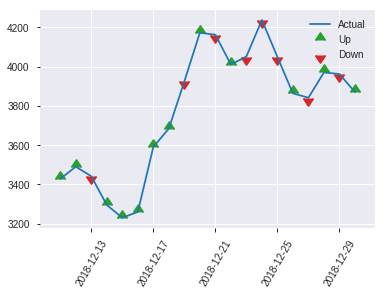


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2196433073648985
RMSE: 0.46866118610879065
LogLoss: 0.6273993473742608
Mean Per-Class Error: 0.29753914988814323
AUC: 0.7276615344124227
pr_auc: 0.5950185698690629
Gini: 0.4553230688248453
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.23992519080638885: 


0    1    Error    Rate
-----  ---  ---  -------  ------------
0      73   76   0.5101   (76.0/149.0)
1      12   90   0.1176   (12.0/102.0)
Total  85   166  0.3506   (88.0/251.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.239925     0.671642  165
max f2                       0.0980098    0.788253  238
max f0point5                 0.325969     0.641509  106
max accuracy                 0.325969     0.709163  106
max precision                0.913423     1         0
max recall                   0.0980098    1         238
max specificity              0.913423     1         0
max absolute_mcc             0.325969     0.402153  106
max min_per_class_accuracy   0.315435     0.686275  115
max mean_per_class_accuracy  0.325969     0.702461  106

Gains/Lift Table: Avg response rate: 40.64 %, avg score: 31.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0119522                   0.853199           1.64052   1.64052            0.666667         0.89597   0.666667                    0.89597             0.0196078       0.0196078                  64.0523   64.0523
    2        0.0239044                   0.80688            1.64052   1.64052            0.666667         0.824547  0.666667                    0.860258            0.0196078       0.0392157                  64.0523   64.0523
    3        0.0318725                   0.726963           2.46078   1.84559            1                0.749977  0.75                        0.832688            0.0196078       0.0588235                  146.078   84.5588
    4        0.0438247                   0.658859           1.64052   1.78966            0.666667         0.689668  0.727273                    0.793682            0.0196078       0.0784314                  64.0523   78.9661
    5        0.0517928                   0.596685           1.23039   1.70362            0.5              0.620192  0.692308                    0.766992            0.00980392      0.0882353                  23.0392   70.362
    6        0.103586                    0.509681           1.13575   1.41968            0.461538         0.543366  0.576923                    0.655179            0.0588235       0.147059                   13.5747   41.9683
    7        0.151394                    0.455879           1.43546   1.42466            0.583333         0.479273  0.578947                    0.59963             0.0686275       0.215686                   43.5458   42.4665
    8        0.203187                    0.433508           2.0822    1.59227            0.846154         0.443377  0.647059                    0.5598              0.107843        0.323529                   108.22    59.2272
    9        0.302789                    0.384102           1.47647   1.55418            0.6              0.402942  0.631579                    0.508202            0.147059        0.470588                   47.6471   55.418
    10       0.40239                     0.334959           1.37804   1.51058            0.56             0.358387  0.613861                    0.471119            0.137255        0.607843                   37.8039   51.058
    11       0.501992                    0.30428            1.18118   1.44522            0.48             0.319263  0.587302                    0.440989            0.117647        0.72549                    18.1176   44.5223
    12       0.601594                    0.272301           0.68902   1.32002            0.28             0.286302  0.536424                    0.415379            0.0686275       0.794118                   -31.098   32.0023
    13       0.701195                    0.227005           0.984314  1.27234            0.4              0.246422  0.517045                    0.391379            0.0980392       0.892157                   -1.56863  27.2337
    14       0.800797                    0.178038           0.393725  1.16306            0.16             0.199049  0.472637                    0.367457            0.0392157       0.931373                   -60.6275  16.3057
    15       0.900398                    0.130806           0.295294  1.06707            0.12             0.151035  0.433628                    0.343517            0.0294118       0.960784                   -70.4706  6.70658
    16       1                           0.0717353          0.393725  1                  0.16             0.102047  0.406375                    0.319466            

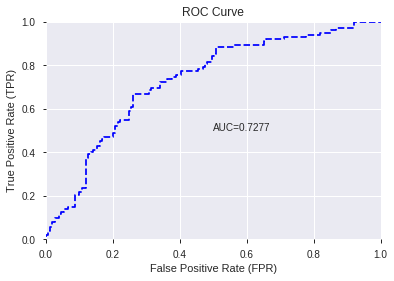

This function is available for GLM models only


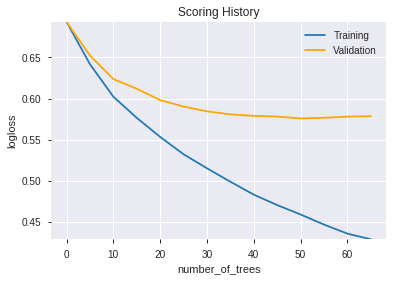

--2019-07-25 05:22:11--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.228.208
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.228.208|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.findInclusiveNa(SharedTreeNode.java:129)
	at hex.genmodel.algos.tree.SharedTreeNode.calculateChildInclusiveNa(SharedTreeNode.java:133)
	at hex.genmodel.algos.tree.SharedTreeNode.setLeftChild(SharedTreeNode.java:207)
	at hex.genmodel.algos.tree.SharedTreeSubgraph.makeLeftEdge(Share

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_3_AutoML_20190725_052150',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_3_AutoML_20190725_052150',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_be36',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_114_sid_be36',
   'ty

['BOP',
 'STOCHF_fastk',
 'TRANGE',
 'WILLR_12',
 'NATR_14',
 'ULTOSC',
 'CCI_8',
 'CDLCLOSINGMARUBOZU',
 'STOCHRSI_fastd',
 'CDLDRAGONFLYDOJI',
 'STOCH_slowk',
 'STOCHRSI_fastk',
 'BETA_14',
 'BETA_12',
 'ADX_14',
 'HT_PHASOR_inphase',
 'ROC_24',
 'CDLHAMMER',
 'DX_30',
 'MINUS_DI_14',
 'OBV',
 'aroonup_12',
 'BBANDS_lowerband_30_7_5',
 'DX_24',
 'CCI_12',
 'BBANDS_lowerband_14_4_5',
 'WILLR_14',
 'BETA_8',
 'CORREL_14',
 'MINUS_DI_30',
 'ROC_8',
 'CDLSPINNINGTOP',
 'ADX_8',
 'aroondown_30',
 'WILLR_30',
 'DX_12',
 'CDLSHORTLINE',
 'CORREL_12',
 'MACDFIX_signal_20',
 'CCI_14',
 'CCI_20',
 'ATR_8',
 'PLUS_DM_20',
 'MFI_24',
 'LINEARREG_ANGLE_12',
 'ROC_30',
 'MACD_hist',
 'ROCP_24',
 'PLUS_DM_8',
 'RSI_14',
 'STOCHF_fastd',
 'WILLR_20',
 'ROCP_12',
 'STDDEV_12',
 'PLUS_DI_8',
 'AROONOSC_24',
 'ROCR_20',
 'ROC_20',
 'CMO_24',
 'CCI_30',
 'CMO_12',
 'MINUS_DI_8',
 'PPO',
 'PLUS_DI_24',
 'aroondown_24',
 'PLUS_DI_14',
 'MFI_12',
 'aroonup_14',
 'PLUS_DI_20',
 'MFI_30',
 'MFI_20',
 'LINEAR

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.653
GLM             0.610
XGBoost         0.717
dtype: float64

DeepLearning    GLM  XGBoost
All          0.602  0.594    0.697
DLF          0.622  0.610    0.709
Fwe          0.622  0.598    0.717
RFE          0.653  0.602    0.709
XGBF         0.602  0.610    0.709





F1


DeepLearning    0.634
GLM             0.589
XGBoost         0.687
dtype: float64

DeepLearning    GLM  XGBoost
All          0.581  0.588    0.674
DLF          0.628  0.589    0.676
Fwe          0.590  0.589    0.687
RFE          0.634  0.587    0.672
XGBF         0.620  0.589    0.676





auc


DeepLearning    0.679
GLM             0.575
XGBoost         0.747
dtype: float64

DeepLearning    GLM  XGBoost
All          0.584  0.542    0.735
DLF          0.614  0.575    0.747
Fwe          0.596  0.563    0.742
RFE          0.679  0.560    0.728
XGBF         0.565  0.575    0.747





logloss


DeepLearning    8.232
GLM             1.946
XGBoost         0.627
dtype: float64

DeepLearning    GLM  XGBoost
All          8.232  1.946    0.603
DLF          0.671  0.690    0.611
Fwe          4.372  1.612    0.598
RFE          2.009  0.781    0.627
XGBF         0.714  0.690    0.611





mean_per_class_error


DeepLearning    0.407
GLM             0.422
XGBoost         0.307
dtype: float64

DeepLearning    GLM  XGBoost
All          0.387  0.422    0.307
DLF          0.386  0.396    0.301
Fwe          0.406  0.418    0.275
RFE          0.352  0.418    0.298
XGBF         0.407  0.396    0.301





rmse


DeepLearning    0.737
GLM             0.626
XGBoost         0.469
dtype: float64

DeepLearning    GLM  XGBoost
All          0.640  0.626    0.457
DLF          0.490  0.498    0.460
Fwe          0.737  0.615    0.456
RFE          0.617  0.530    0.469
XGBF         0.508  0.498    0.460





mse


DeepLearning    0.544
GLM             0.391
XGBoost         0.220
dtype: float64

DeepLearning    GLM  XGBoost
All          0.410  0.391    0.209
DLF          0.240  0.248    0.212
Fwe          0.544  0.378    0.208
RFE          0.380  0.281    0.220
XGBF         0.258  0.248    0.212

{'F1':       DeepLearning    GLM  XGBoost
 All          0.581    NaN      NaN
 DLF          0.628    NaN      NaN
 DLF            NaN  0.589      NaN
 DLF            NaN    NaN    0.676
 All            NaN  0.588      NaN
 All            NaN    NaN    0.674
 XGBF         0.620    NaN      NaN
 XGBF           NaN  0.589      NaN
 XGBF           NaN    NaN    0.676
 Fwe          0.590    NaN      NaN
 Fwe            NaN  0.589      NaN
 Fwe            NaN    NaN    0.687
 RFE          0.634    NaN      NaN
 RFE            NaN  0.587      NaN
 RFE            NaN    NaN    0.672,
 'accuracy':       DeepLearning    GLM  XGBoost
 All          0.602    NaN      NaN
 DLF          0.622    NaN      NaN
 DLF            NaN  0.610      NaN
 DLF            NaN    NaN    0.709
 All            NaN  0.594      NaN
 All            NaN    NaN    0.697
 XGBF         0.602    NaN      NaN
 XGBF           NaN  0.610      NaN
 XGBF           NaN    NaN    0.709
 Fwe          0.622    NaN      NaN
 Fwe     